In [1]:
# User variables
SAVE_ELEMENTS = True # True if figures and models shall be saved

MAX_DURATION_JOURNEY = 180

compute_dfg = False
compute_sequence = False
compute_sequence_distance = False

In [2]:
# Imports
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import copy
from pm4py.objects.log.util import dataframe_utils
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
import pygraphviz as pgv
import json
import seaborn as sns
from collections import Counter
import subprocess

In [3]:
VERIFYTA_PATH = "/home/paul/Downloads/uppaal-4.1.20-stratego-9-linux64/bin/verifyta"

# Preprocessing
The data is loaded and preprocessed.
Names of events are parsed and unused events are removed.

In [4]:
# removes unused events and parses event names
def process_touchpoint_names(df):
    print("Found types", set(df['Type']))
    running_df = df[df['Type'].isin(['state', 'feedback','subject', 'task', 'resultsShared'])].copy()
    #prelims = df[df['concept:name'].str.contains("Preliminary results updated for overall score")] # include prelim results - doesnt make a lot of sense...
    #running_df = running_df.append(prelims)
    running_df['concept:name'] = running_df['concept:name'].str.replace('\n', "") # rows might contain line-breaks; for different A, B, C tasks
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes
    running_df['concept:name'] = running_df['concept:name'].str.replace(",", "")
    running_df['concept:name'] = running_df['concept:name'].str.split('version').str[0]
    
    running_df['concept:name'] = running_df['concept:name'].str.split('Time used').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('taskDownloaded').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('testCompleted').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.split('itemCompleted').str[0]

    running_df['concept:name'] = running_df['concept:name'].str.strip()

    m = running_df['concept:name'].str.contains("survey:")
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].str.split('survey: ').str[1]
    
    m = running_df['Type'] == 'state'
    running_df.loc[m, 'concept:name'] = running_df['concept:name'][m].values
    running_df.loc[~m, 'concept:name'] = running_df['concept:name'][~m].values
    return running_df

# Filters the dataset to only contain traces with length in [lower_bound, upper_bound]
def get_filtered_df(path, lower_bound = 15, upper_bound = 60):
    df = pd.read_csv(path, sep = ";")
    log_csv = dataframe_utils.convert_timestamp_columns_in_df(df)
    log_csv = log_csv.sort_values('Timestamp')

    developers_finished_ids = set(log_csv[log_csv['Message'] == "finished"]['Developer ID'].sort_values().values)

    #rename columns to process mining notation
    log_csv.rename(columns={'Developer ID': 'case:DeveloperID', 'Message' : 'concept:name', 'Timestamp':'time:timestamp'}, inplace=True)
    log_csv['time:timestamp'] = pd.to_datetime(log_csv['time:timestamp'], unit='s')
    
    # process touchpoint names
    developers_df = process_touchpoint_names(log_csv)

    #filter used logs
    developers_df = developers_df.groupby(['case:DeveloperID']).filter(lambda x: len(x) >= lower_bound and len(x) <= upper_bound)

    unsuccesfull = developers_df[~developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    succesfull = developers_df[developers_df['case:DeveloperID'].isin(list(developers_finished_ids))]['case:DeveloperID'].value_counts().to_list()
    plt.scatter(range(len(unsuccesfull)), unsuccesfull, c = "r", s = 7)
    plt.scatter(range(len(unsuccesfull),len(unsuccesfull)+(len(succesfull))), succesfull, c = "b", s = 7)
    plt.xlabel("Journeys")
    plt.ylabel("Length")
    plt.show()
    print("Includes #unsuccesfull:", len(unsuccesfull),"and #succesfull", len(succesfull))
    
    print("Histograms")
    sns.displot(data=pd.DataFrame({"Journey Length - Successfull": succesfull}),
            x="Journey Length - Successfull", color='blueviolet', height=3)
    plt.show()
    
    sns.displot(data=pd.DataFrame({"Journey Length - Unsuccessfull": unsuccesfull}),
            x="Journey Length - Unsuccessfull", color='blueviolet', height=3)
    plt.show()
    

    developers_df = developers_df.sort_values(by=['time:timestamp'])

    return developers_df

Found types {'task', 'latency', 'state', 'feedback', 'activate', 'subject', 'vpcInstance', 'resultsShared', 'score'}


/tmp/ipykernel_135209/3795938980.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/tmp/ipykernel_135209/3795938980.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


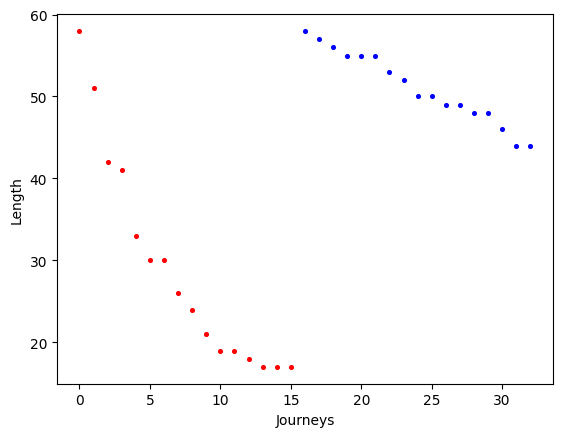

Includes #unsuccesfull: 16 and #succesfull 17
Histograms


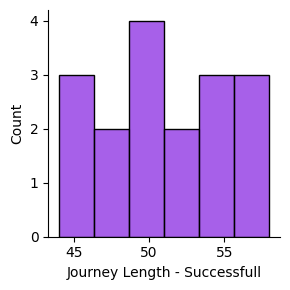

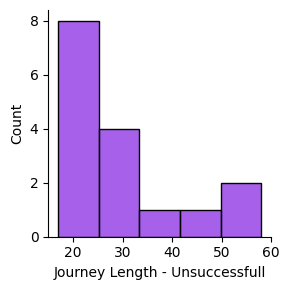

1970-01-27 15:22:16 1970-03-17 16:00:20
49 days 00:38:04 4235884.0


In [5]:
filtered_df_old = get_filtered_df("data.csv")
s1 = set(filtered_df_old["concept:name"])

started = filtered_df_old[filtered_df_old["concept:name"]=="registered"]
times = started["time:timestamp"]
print(min(times), max(times)) # two years
print(max(times)-min(times), (max(times)-min(times)).total_seconds())
WINDOW_SIZE = (max(times)-min(times)).total_seconds()

Found types {'task', 'latency', 'state', 'feedback', 'activate', 'subject', 'vpcInstance', 'resultsShared', 'score'}


/tmp/ipykernel_135209/3795938980.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"loggedIn.*","loggedIn") # removes feedback attributes
/tmp/ipykernel_135209/3795938980.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  running_df['concept:name'] = running_df['concept:name'].str.replace(r"\[.*\]","") # removes feedback attributes


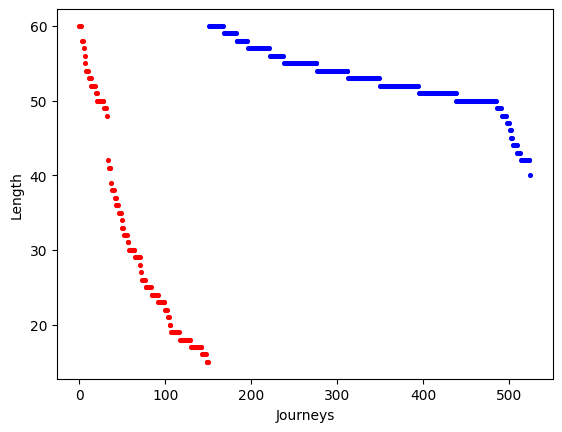

Includes #unsuccesfull: 151 and #succesfull 375
Histograms


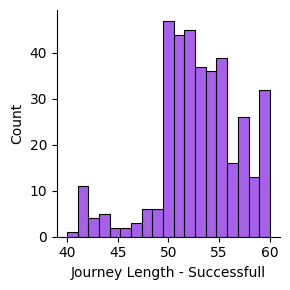

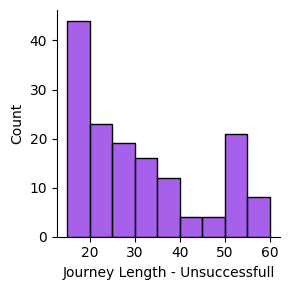

In [6]:
filtered_df = get_filtered_df("data_extended.csv")
s2 = set(filtered_df["concept:name"])

In [7]:
filtered_df.to_csv("data_reduced_ProM.csv")

       Company ID Category  case:DeveloperID      time:timestamp     Type  \
25807           9      B2B               571 1970-03-25 23:51:59    state   
25808           9      B2B               571 1970-03-26 22:32:28    state   
25809           9      B2B               571 1970-03-26 22:32:28  subject   
25811           9      B2B               571 1970-03-26 22:32:29    state   
25810           9      B2B               571 1970-03-26 22:32:29    state   

                  concept:name  Unnamed: 6  
25807               registered         NaN  
25808                activated         NaN  
25809      Logged in: Web page         NaN  
25811  vpcCreateUserOnInstance         NaN  
25810        vpcAssignInstance         NaN  
number companies 18


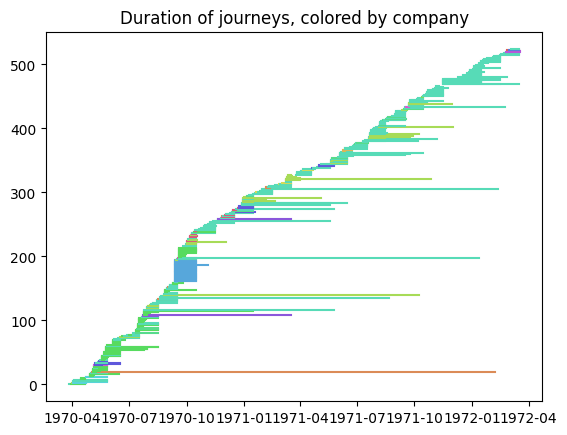

1970-03-25 23:51:59 1972-03-09 21:53:49


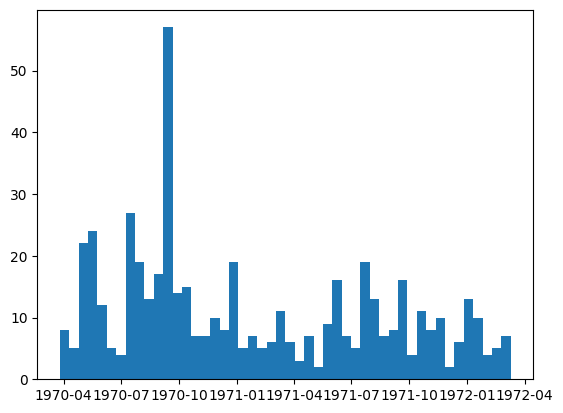

In [8]:
# investigate starting time-stamp
print(filtered_df.head())
times = {}
companies = {}
developers = set(filtered_df['case:DeveloperID'])

for d in developers:
    reduced = filtered_df[filtered_df['case:DeveloperID']==d]
    assert(len(set(reduced["Company ID"])) == 1)
    companies[d] = list(set(reduced["Company ID"]))[0]
    times[d] = (min(reduced["time:timestamp"]), max(reduced["time:timestamp"]))

number_companies = len(set(companies.values()))
company_iterator = {c : i for c,i in zip(set(companies.values()), range(number_companies))}
print("number companies", number_companies)

sorted_times = sorted(times.items(), key=lambda item: item[1])

count = 0
for t in sorted_times:
    company_it = company_iterator[companies[t[0]]]
    plt.plot([t[1][0],t[1][1]], [count, count], c=sns.color_palette("hls", number_companies)[company_it])
    count += 1
plt.title("Duration of journeys, colored by company")
plt.show()

started = filtered_df[filtered_df["concept:name"]=="registered"]
starting_times = started["time:timestamp"]
end_times = filtered_df.groupby(['case:DeveloperID']).max()["time:timestamp"]
print(min(starting_times), max(starting_times)) # two years
plt.hist(starting_times, 48)
plt.show()

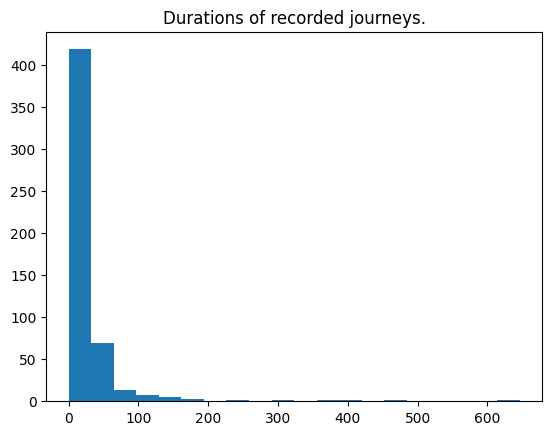

235


In [9]:
time_diffs = []
for t in times.values():
    time_diffs.append((t[1]-t[0]).days)

plt.hist(time_diffs, 20)
plt.title("Durations of recorded journeys.")
plt.show()

print(len([t for t in time_diffs if t > 21]))

In [10]:
print(sorted(s1))
print(sorted(s2))

print("In s1, not s2")
for a in s1:
    if a not in s2:
        print(a)

print("In s2, not s1")
for a in s2:
    if a not in s1:
        print(a, type(a))

['Give feedback', 'Logged in: Web page', 'Results automatically shared', 'Results shared', 'Task event:', 'Task event: loggedIn', 'activated', 'finished', 'readyToStart', 'registered', 'started', 'subjectAcceptanceReceived', 'vpcAssignInstance', 'vpcCreateUserOnInstance', 'waitingForActivityReport', 'waitingForManualScores', 'waitingForResultApproval', 'waitingForScores', 'waitingForSubjectAcceptance']
['Give feedback', 'Logged in: Web page', 'Results automatically shared', 'Results not shared', 'Results shared', 'Task event:', 'Task event: loggedIn', 'activated', 'finished', 'null', 'readyToStart', 'registered', 'started', 'subjectAcceptanceDeclined', 'subjectAcceptanceReceived', 'vpcAssignInstance', 'vpcCreateUserOnInstance', 'waitingForActivityReport', 'waitingForManualScores', 'waitingForResultApproval', 'waitingForScores', 'waitingForSubjectAcceptance']
In s1, not s2
In s2, not s1
subjectAcceptanceDeclined <class 'str'>
null <class 'str'>
Results not shared <class 'str'>


# Build log
The dataset is flattened to a log structure

In [11]:
success_states = ['finished']
# A log consists of traces, where each trace contains all elements from one developer 
def build_log(df, return_start_times = False):
    log = []
    start_times = [] # maps from developer to timestamp
    running_df = df.copy()
    running_df = running_df.sort_values(by=['time:timestamp'])
    developers_id = set(running_df['case:DeveloperID'].values)
    for dev_id in developers_id:
        current_trace = running_df[running_df['case:DeveloperID'] == dev_id]['concept:name'].values

        trace_start = min(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp'])
        trace_end = max(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp'])

        if ((trace_end-trace_start).days > MAX_DURATION_JOURNEY):
            print("omitted developer", dev_id, "due to length")
            continue
        
        # add unique start node "start"
        current_trace = np.insert(current_trace,0,"start")
        # attach final node finPos / finNeg
        if(any(s in current_trace for s in success_states)):
            current_trace = np.append(current_trace,"finPos")
        else:
            current_trace = np.append(current_trace,"finNeg")
        log.append(current_trace)
        start_times.append(min(running_df[running_df['case:DeveloperID'] == dev_id]['time:timestamp']))
        
    # alter "logged in: Web page" to determine phase of journey:
    # Phase (1) sign up, (2) solve all programming tasks, and  (3) review and share the skill report with the customer.
    for t in log:
        indices = [i for i, x in enumerate(t) if x == "Logged in: Web page"]
        for i in indices:
            t[i] = "Logged in: Web page - Sign up"
            result = np.where(t == "Task event:")
            if "Task event:" in t and result[0][0] < i:
                t[i] = "Logged in: Web page - Task"
            result = np.where(t == "waitingForResultApproval")
            if "waitingForResultApproval" in t and result[0][0] < i:
                t[i] = "Logged in: Web page - Approval"
                
    # add task number
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x == "Task event:"]
        for i in indices_task:
            count_indices = [j for j in indices_feedback if j < i] # uses feedback to increase task counter after giving feedback
            t[i] += " "+str(len(count_indices))
    # add feedback number        
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_task = [i for i, x in enumerate(t) if x == "Task event:"]
        for i in indices_feedback:
            count_indices = [j for j in indices_feedback if j < i]
            t[i] += " "+str(len(count_indices))
    """
    # add number to log in:
    for t in log:
        indices_feedback = [i for i, x in enumerate(t) if x == "Give feedback"]
        indices_loggin = [i for i, x in enumerate(t) if x == "Task event: loggedIn"]
        for i in indices_loggin:
            count_indices = [j for j in indices_feedback if j < i]
            t[i] += " "+str(len(count_indices))
    """

    if return_start_times:
        return log, start_times
    return log

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

In [12]:
def filter_doubles(log):
    filtered_log = []
    for index in range(len(log)):
        # remove sequential same elements
        trace = log[index]
        current_trace = [trace[0]]

        for pos in range(1,len(trace)):
            if trace[pos]==trace[pos-1]:
                continue
            current_trace.append(trace[pos])

        filtered_log.append(current_trace)
    return filtered_log

In [13]:
def ignore_loggin(log):
    filtered_log = []
    for index in range(len(log)):
        # remove sequential same elements
        trace = log[index]
        current_trace = [trace[0]]

        for pos in range(1,len(trace)):
            if "Task event: loggedIn" in trace[pos] or "Logged in: Web page" in trace[pos]:
                continue
            current_trace.append(trace[pos])

        filtered_log.append(current_trace)
    return filtered_log

In [14]:
log, start_times = build_log(filtered_df, return_start_times=True)
log = ignore_loggin(log)
log = filter_doubles(log)

omitted developer 40 due to length
omitted developer 93 due to length
omitted developer 233 due to length
omitted developer 270 due to length
omitted developer 658 due to length
omitted developer 720 due to length
omitted developer 1041 due to length
omitted developer 1103 due to length
omitted developer 1249 due to length


In [15]:
log_old = build_log(filtered_df_old)
log_old = ignore_loggin(log_old)
log_old = filter_doubles(log_old)

In [16]:
for trace_old in log_old:
    found = False
    for trace in log:
        if len(trace) != len(trace_old):
            continue
        if trace_old == trace:
            found = True
            break
    if not found:
        print("not found", trace_old)
        break

not found ['start', 'registered', 'activated', 'vpcCreateUserOnInstance', 'vpcAssignInstance', 'readyToStart', 'started', 'Task event: 0', 'Give feedback 0', 'Task event: 1', 'Give feedback 1', 'Task event: 2', 'Give feedback 2', 'Task event: 3', 'Give feedback 3', 'Task event: 4', 'waitingForManualScores', 'Task event: 4', 'waitingForScores', 'waitingForResultApproval', 'waitingForActivityReport', 'finNeg']


Variants before removing trivial elements
89


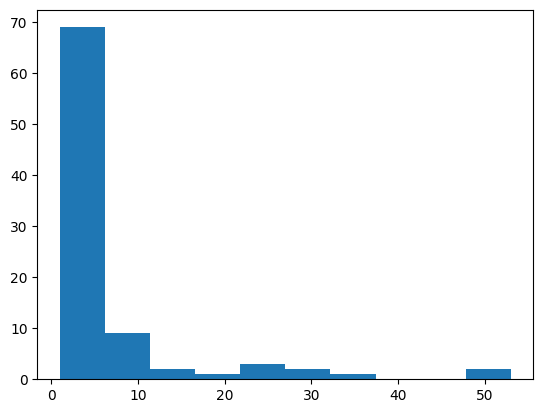

In [17]:
# variants in log
print("Variants before removing trivial elements")
variants_counter = Counter(str(e) for e in log)
plt.hist(variants_counter.values(), 10)
print(len(Counter(str(e) for e in log).keys()))

# Create DFG

In [18]:
# Builds the directly follows graph according to the log
# Removes all edges which are traversed less than "threshold" times
def build_dfg(log, threshold):
    states = list(set([item for sublist in log for item in sublist])) # flatten list

    edges = []
    edge_counter = {}
    for trace in log:
        s = "start"
        assert(trace[0]=="start")
        for pos in trace[1:]:
            t = pos
            e = (s,t)
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
            else:
                edge_counter[e] = edge_counter[e]+1
            s = t
    
    g = nx.DiGraph()
    g.add_nodes_from(states)
    max_val = max(edge_counter.values())
    for e in edges:
        g.add_edge(e[0], e[1], edge_weight = edge_counter[e]/max_val) # adds "thickness" element

    # remove all simple loops & rarely traversed edges
    to_remove = []
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        if edge_counter[e] <= threshold:
            to_remove.append(e)

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
            
    
    # remove isolated nodes
    g.remove_nodes_from(list(nx.isolates(g)))
    
    return g

def draw_dfg(g, name):
    # build graph with variable thicknes
    scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = "20"
        if 'controllable' in g.nodes[e[1]]:
            if not g.nodes[e[1]]['controllable']:
                e.attr["style"] = "dotted"
    for e in g.edges:
        e = A.get_edge(e[0], e[1])
        if 'controllable' in g.edges[e]:
            if not g.edges[e]['controllable']:
                e.attr["style"] = "dotted"
        #A.add_edge(e[0], e[1], penwidth = edge_weights[e]*scaling)

    #A.graph_attr.update(size="7.75,10.25")
    A.layout("dot")
    if SAVE_ELEMENTS:
        A.draw(name)
    print("plotted", name)

In [19]:
g = build_dfg(log,4)
draw_dfg(g, "graph.ps")
g_old = build_dfg(log_old,3)
draw_dfg(g_old, "graph_old.ps")

plotted graph.ps
plotted graph_old.ps


# Burnd-Down Chart of Developers

In [20]:
# Draw the burn down chart of developers leaving the journey per touchpoint, Figure 6
def draw_burn_down(g,s, t, log):
    g_copy = copy.deepcopy(g)
    edge_counter = {}
    node_counter = {}
    
    for trace in log:
        s = "start"
        assert(trace[0]=="start")
        for pos in trace[1:]:
            t = pos
            e = (s,t)
            if e not in edge_counter:
                edge_counter[e] = 1
            else:
                edge_counter[e] = edge_counter[e]+1
            s = t
            
    for trace in log:
        for pos in set(trace):
            if pos in node_counter:
                node_counter[pos] = node_counter[pos]+1
            else:
                node_counter[pos] = 1
            continue

    for e in edge_counter:
        if e[1] == "finNeg":
            print(e, edge_counter[e])
    
    x = [100,81, 72, 64, 52]
    y = ["start", "T10", "T12", "T14", "T25"]
    x2 = [0,18,9,9,12]
    y2 = ["start", "T10", "T12", "T14", "T25"]
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(y,x, 'o-')
    ax.bar(y2, x2, color="r")
    plt.ylabel("Developers (in %)", fontsize=18)
    plt.xlabel("Events", fontsize=18)
    plt.show()

('waitingForActivityReport', 'finNeg') 36
('Task event: 0', 'finNeg') 14
('Task event: 1', 'finNeg') 43
('Task event: 2', 'finNeg') 28
('Task event: 4', 'finNeg') 6
('Task event: 3', 'finNeg') 17
('readyToStart', 'finNeg') 2
('vpcAssignInstance', 'finNeg') 2
('subjectAcceptanceDeclined', 'finNeg') 1
('waitingForManualScores', 'finNeg') 1


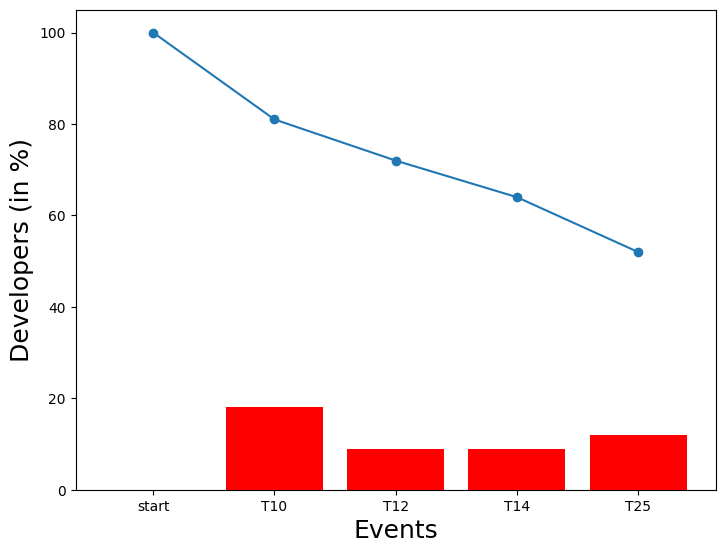

In [21]:
draw_burn_down(g, "start", "finNeg", log)

# DFG to Customer Journey Game

In [22]:
# load actors from given file
# The file maps events to actors in xml format
# Every unspecified event is controllable
with open('activities.xml') as f:
    data = f.read()
actors = json.loads(data)

In [23]:
# stores actors in graph
def extend_graph_with_actors(g, actors, transition_system=False):
    if not transition_system:
        for node in g.nodes:
            if node not in actors:
                g.nodes[node]['controllable'] = True
            else:
                g.nodes[node]['controllable'] = actors[node] == "company"
    else:
        for e in g.edges:
            controllable_set = False
            for key in actors:
                if key in g.edges[e]['action']:
                    controllable_set = True
                    g.edges[e]['controllable'] = actors[key] == 'company'
            if not controllable_set:
                g.edges[e]['controllable'] = True

In [24]:
extend_graph_with_actors(g,actors)

In [25]:
# Helper functions to compute weights for edges

def isInTrace(s,t, trace):
    for i in range(len(trace)-1):
        if trace[i] == s and trace[i+1] == t:
            return True
    return False

def weight(trace):
    return 1 if any("finished" in pos for pos in trace) else -1

def majority(s,t,log):
    maj = 0
    for trace in log:
        if isInTrace(s,t,trace):
            maj += weight(trace)
    return 1 if maj == 0 else int(maj/abs(maj))

def entropy(p1, p2):
    if p1 == 0 or p2 == 0:
        return 0
    return - p1*np.log2(p1) - p2* np.log2(p2)

def distribution(s,t,log, edge_mapping = []):
    distr = {1.0: 0 , -1.0 : 0}
    if edge_mapping == []: # old function
        for trace in log:
            if isInTrace(s,t,trace):
                w = weight(trace)
                distr[w] += 1
    else:# use abstraction
        assert((s,t) in edge_mapping)
        for trace_index in set(edge_mapping[(s,t)]):
            w = weight(log[trace_index])
            distr[w] += 1 #
    return distr[1], distr[-1]

def compute_edge_cost(g, log, edge_mapping = []):
    weights = [1 if "finished" in i else -1 for i in log]
    edge_cost = {}
    for s in g.nodes:
        for t in g[s]:
            p1, p2 = distribution(s,t,log, edge_mapping)
            if p1 +  p2 == 0:
                assert(False)
            wp1 = p1/(p1+p2)
            wp2 = p2/(p1+p2)
            #w = majority(s,t,log)
            w = 1 if p1 >= p2 else -1
            scaling = 10
            edge_cost[(s,t)] = (((1-entropy(wp1,wp2)) * w) -0.1 )*20
    print("Edge cost was computed")
    return edge_cost

In [26]:
edge_cost = compute_edge_cost(g, log)

Edge cost was computed


In [27]:
# annotates graph with cost-labels
def annotate_graph(g, edge_cost):
    for e in edge_cost:
        g[e[0]][e[1]]['label'] = round(edge_cost[e],2)
    return g

# Colors graph labels green/red depending of the weight is positive or negative
def color_graph(g):
    g = copy.deepcopy(g)
    for e in g.edges:
        if g[e[0]][e[1]]['label'] > 0:
            g[e[0]][e[1]]['color'] ="darkgreen"
        if g[e[0]][e[1]]['label'] < 0:
            g[e[0]][e[1]]['color'] ="red"
    
    return g

# Plots clustered DFG, Figure 5
def draw_dfg_clustered(g, name):
    # build graph with variable thicknes
    scaling = 10/np.mean(list(nx.get_edge_attributes(g,'edge_weight').values()))

    A = to_agraph(g)
    edge_weights = nx.get_edge_attributes(g,'edge_weight')

    for e in edge_weights:
        e = A.get_edge(e[0], e[1])
        #e.attr["penwidth"] = edge_weights[e]*scaling
        e.attr["fontsize"] = 70
        if 'controllable' in g.nodes[e[1]]:
            if not g.nodes[e[1]]['controllable']:
                e.attr["style"] = "dotted"

    for n in A.nodes():
        n.attr['fontsize'] = 80
    onboarding = ["T"+str(i) for i in range(0,6)]
    A.add_subgraph(onboarding, name='cluster_onboarding', label= "Sign-up", color = "orange", fontsize = 60, fontcolor = "orange")
    task = ["T"+str(i) for i in range(6,21)]
    A.add_subgraph(task, name='cluster_task', label= "Solve tasks", color = "blue", fontsize = 60, fontcolor = "blue")
    evaluation = ["T"+str(i) for i in range(21,27)]
    A.add_subgraph(evaluation, name='cluster_evaluation', label= "Review and share", color = "purple", fontsize = 60, fontcolor = "purple")

    reversed_naming = {naming[i] : i for i in naming}
    for n in A.nodes():
        if n not in reversed_naming:
            continue
        n.attr['label'] = reversed_naming[n]
    A.layout("dot")
    if SAVE_ELEMENTS:
        A.draw(name)
        
# Introduced naming for readable function
naming = {
    "registered" : "T0",
    "activated": "T1",
    "Logged in: Web page - Sign up" : "T2",
    "vpcCreateUserOnInstance" : "T3",
    "vpcAssignInstance" : "T4",
    "readyToStart" : "T5",
    "Task event: loggedIn" : "T6",
    "started" : "T7",
    "Task event: 0": "T8",
    "Give feedback 0" : "T9",
    "Task event: 1": "T10",
    "Give feedback 1" : "T11",
    "Task event: 2": "T12",
    "Give feedback 2" : "T13",
    "Task event: 3": "T14",
    "Give feedback 3" : "T15",
    "Task event: 4": "T16",
    "Give feedback 4" : "T17",
    "Task event: 5": "T18",
    "waitingForManualScores" : "T19",
    "Logged in: Web page - Task" : "T20",
    "waitingForScores" : "T21",
    "waitingForResultApproval" : "T22",
    "waitingForSubjectAcceptance" : "T23",
    "subjectAcceptanceReceived" : "T24",
    "Results automatically shared" : "T24",
    "waitingForActivityReport" : "T25",
    "Logged in: Web page - Approval" : "T26"
}

In [28]:
g = annotate_graph(g, edge_cost)
g_outgoing = color_graph(g)
g_outgoing = nx.relabel_nodes(g_outgoing, naming)
draw_dfg_clustered(g_outgoing, 'outgoing_clustered.png')

# Mapping to UPPAAL Model

In [29]:
# Computes all possible shift of lists
def shifted_lists(l):
    shifted_lists = []
    for j in range(len(l)):
        list_constructed = copy.deepcopy(l[j:])
        list_constructed.extend(l[:j])
        list_constructed.append(list_constructed[0])
        shifted_lists.append(list_constructed)
    return shifted_lists

# checks if history hist contains circle c
def contains(hist, c):
    n = len(c)+1
    max_count = 0
    lists = shifted_lists(c)
    for helper_list in lists:
        count = 0
        for i in range(len(hist)-(n-1)):
            if hist[i:i+n] == helper_list:
                count += 1
        max_count = max(max_count, count)
    return max_count

# returns true if edge (e,v) is on c
def is_on(e,v,c):
    for i in range(len(c)-1):
        if c[i] == e and c[i+1] == v:
            return True
    if c[-1] == e and c[0] == v:
        return True


# Presented Unrolling algorithm, Algorithm 1 with online reducing
def unroll(G, start, target, k, debug = False):
    G_gen = nx.DiGraph()
    G_gen.add_node(start, hist = [str(start)])
    if 'controllable' in G.nodes[start]:
        G_gen.nodes[start]["controllable"] = G.nodes[start]["controllable"]

    cycles = list(nx.simple_cycles(G))

    queue = [start]
    # start bf-search
    while(queue):
        s = queue[0]
        queue.pop(0)
        s_original = str(s).split(".")[0]
        neighbours = list(G[s_original])
        for t in neighbours:
            t_original = t
            local_hist = copy.deepcopy(G_gen.nodes[s]["hist"])
            local_hist.append(str(t_original))
            is_on_cycle = False
            can_traverse = False
            path = []
            circle = []
            relevant_cycle = []
            for c in cycles:
                if is_on(s_original,t_original,c):
                    relevant_cycle.append(c)
                    
            all_smaller = True
            for c in relevant_cycle:
                if contains(local_hist,c) >= k:
                    all_smaller = False
            
            if not all_smaller:
                paths = list(nx.all_simple_paths(G, source=t, target=target))
                for p in paths:
                    merged_hist = copy.deepcopy(local_hist)
                    merged_hist.extend(p[1:]) # 1.st element already added
                    can_not_traverse = False
                    
                    #test if no loop larger than k with path
                    for c_loop in relevant_cycle:
                        if contains(merged_hist,c_loop) > k : # check that there is path without completing additional cycle
                            can_not_traverse = True
                    can_traverse = not can_not_traverse
            if all_smaller or can_traverse:               
                #every node not on cycle can be unqiue ("merge point" within unrolled graph)
                if relevant_cycle:
                    while t in G_gen.nodes:
                        if "." not in t:
                            t += ".1"
                        else:
                            t = t.split(".")[0]+"."+str(int(t.split(".")[-1])+1)
                # add node t only to graph if not already treated

                if t not in queue:
                    queue.append(t)
                    G_gen.add_node(t, hist = local_hist)
                assert(s in G_gen and t in G_gen)
                G_gen.add_edge(s,t)
                if('label' in G[s_original][t_original]):
                    G_gen[s][t]['label'] = G[s_original][t_original]['label']
                if('controllable' in G[s_original][t_original]): # transition systems store controllability in edges
                    G_gen[s][t]['controllable'] = G[s_original][t_original]['controllable']
                if('controllable' in G.nodes[t_original]): # dfg stores in nodes
                    G_gen.nodes[t]['controllable'] = G.nodes[t_original]['controllable']

    print("Graph was unrolled")
    return G_gen

In [30]:
#g_unroll = unroll(g, "start", ["finPos", "finNeg"], 1)
#A = to_agraph(g_unroll)
#A.layout('dot')
#if SAVE_ELEMENTS:
#    A.draw('unrolled.ps')

In [31]:
# Method to produce unrolled graph
def to_uppaal(g):
    f = open("unrolled_graph.xml", "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog='dot', args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int gas = 0;')
    f.write('\n'+'int finalGasMax = 0;')
    f.write('\n'+'int finalGasMin = 10000;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location(f, "id"+str(i),pos[s][0],pos[s][1],s)
    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    for e in g.edges:
        final = True if "finPos" in e[1] or "finNeg" in e[1] else False
        print_edge(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g.nodes[e[1]]['controllable'], final = final)
    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    print("All written to", f.name)

def print_location(f, location_id, x, y, name):
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y))+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if "finPos" not in name and "finNeg" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge(f, s, t, pos_s, pos_t, weight, controllable, final = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
    
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    if final:
        f.write('finalGasMax = gas +'+str(int(round(weight))))
        f.write(',\n'+'finalGasMin = gas +'+str(int(round(weight))))
        f.write(',\n'+ 'gas = gas + '+str(int(round(weight))))
    else:
        f.write('gas = gas + '+str(int(round(weight))))
    
    f.write(',\n'+ 'steps += 1')
    f.write(',\n'+ 'x = 0')
    
    f.write('</label>')
    
    f.write('</transition>')


In [32]:
#if SAVE_ELEMENTS:
#    to_uppaal(g_unroll)

##  UPPAAL
This generated model can then by model checked with UPPAAL.

# Generate Simulation Plot
Generates comparison plot between GoPos and GoPosFast, Figure 7

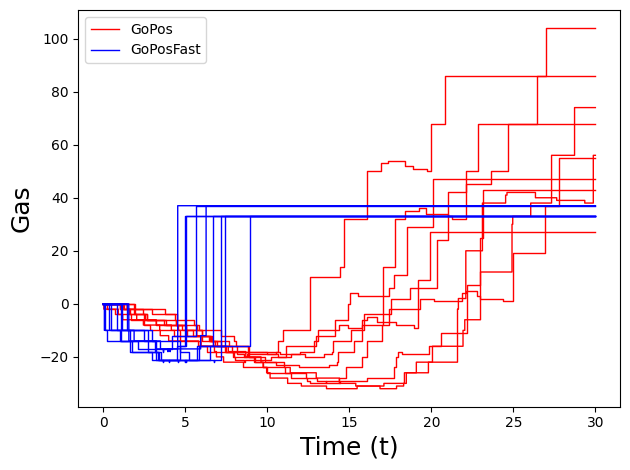

In [33]:
def read_csv(path):
    simulations = []
    lines = []
    with open(path) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
    lines = [line for line in lines if "##" not in line]
    lines.pop(0)
    x = []
    y = []
    current_x = []
    current_y = []
    current_simulation = []
    for line in lines:
        if "#" in line:
            current_x.append(30)
            current_y.append(current_y[-1])
            x.append(current_x)
            y.append(current_y)
            current_x = []
            current_y = []
        else:
            current_x.append(float(line.split(",")[0]))
            current_y.append(float(line.split(",")[1]))
    return x,y

x,y = read_csv("gopos.csv")
x_fast, y_fast = read_csv("goposfast.csv")
plt.rcParams["figure.autolayout"] = True
for i in range(len(x)):
    if i == len(x)-1:
        plt.plot(x[i],y[i], c = "r", linewidth = 1, label = "GoPos")
    else:
        plt.plot(x[i],y[i], c = "r", linewidth = 1)
for i in range(len(x_fast)):
    if i == len(x_fast)-1:
        plt.plot(x_fast[i],y_fast[i], c = "b", linewidth = 1, label = "GoPosFast")
    else:
        plt.plot(x_fast[i],y_fast[i], c = "b", linewidth = 1)
plt.legend()
plt.savefig("simulation.png")
plt.xlabel("Time (t)",  fontsize=18)
plt.ylabel("Gas",  fontsize=18)
plt.show()

## Same functions for transition systems

In [34]:
#transition system needs different write-to-xml methods

# construction of uppaal model (write model into upaal file)
def to_uppaal_transition(g, name, layout = "sfdp", debug = False):
    f = open(name, "w+")
    
    pos = nx.drawing.nx_agraph.graphviz_layout(g, prog=layout, args='-Grankdir=LR')

    f.write('<?xml version="1.0" encoding="utf-8"?>')
    f.write("<!DOCTYPE nta PUBLIC '-//Uppaal Team//DTD Flat System 1.1//EN' 'http://www.it.uu.se/research/group/darts/uppaal/flat-1_1.dtd'>")
    f.write('<nta>')
    f.write('<declaration>')
    f.write('int gas = 0;')
    f.write('\n'+'clock x;')
    f.write('\n'+'hybrid clock t;')
    f.write('\n'+'int steps;')
    f.write('\n'+'bool reached_positive = false;')
    f.write('\n'+'bool reached_negative = false;')
    f.write('\n'+'int final_gas = -1;')
    f.write('</declaration>')
    f.write('<template>')
    f.write('<name x="5" y="5">Template</name>')
    
    # print locations
    ids = {}
    for s,i in zip(pos, range(len(pos))):
        ids[s] = i
        print_location_transition(f, "id"+str(i),pos[s][0],pos[s][1],s)
        f.write('\n')
                    
    f.write('<init ref="id'+str(ids['start'])+'"/>')
    
    for e in g.edges:
        assert("label" in g[e[0]][e[1]] and "controllable" in g[e[0]][e[1]])
        print_edge_transition(f, ids[e[0]], ids[e[1]], pos[e[0]], pos[e[1]], g[e[0]][e[1]]['label'], g[e[0]][e[1]]['controllable'], e, g)

    f.write('</template>')
    f.write('<system>')
    f.write('Journey = Template();')
    f.write('system Journey;')
    f.write('</system>')
    f.write('</nta>')
    f.close()
    if debug:
        print("all written to", f.name)

def print_location_transition(f, location_id, x, y, name):
    name = str(name)
    name = name.replace('"', '-')
    name = name.replace('{', '')
    name = name.replace('}', '')
    name = name.replace("'", '-')
    name = name.replace("_", '')
    name = name.replace("(", '')
    name = name.replace(")", '')
    f.write('<location id="'+location_id+'" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write('<name x="'+str(int(x))+'" y="'+str(int(y)+20)+'">'+str(name).replace(":", "").replace(" ","").replace(".", "").replace(",", "").replace("-","")+'</name>')
    f.write('<label kind="invariant" x="'+str(int(x))+'" y="'+str(int(y)-30)+'">')
    if "finPos" not in name and "finNeg" not in name and "outOfGas" not in name:
        f.write('x &lt;= ' + str(2))
    else:
        f.write("t'==0")
    f.write('</label>')
    f.write('</location>')

def print_edge_transition(f, s, t, pos_s, pos_t, w, controllable, e, g, guard = False):
    x = (pos_s[0]+pos_t[0])/2
    y = (pos_s[1]+pos_t[1])/2
    if controllable:
        f.write('<transition action = "">')
    else:
        f.write('<transition controllable="false" action = "">')
    f.write('<source ref="id'+str(s)+'"/>')
    f.write('<target ref="id'+str(t)+'"/>')
        
    f.write('<label kind="assignment" x="'+str(int(x))+'" y="'+str(int(y))+'">')
    f.write(' steps += 1')
    f.write(',\n'+ 'x = 0')
    if "finPos" in str(e[1]):
        f.write(',\n'+ 'reached_positive = true')
        f.write(',\n'+ 'final_gas = gas +'+str(int(round(w))))
    elif "finNeg" in str(e[1]):
        f.write(',\n'+ 'reached_negative = true')
        f.write(',\n'+ 'final_gas = gas + '+str(int(round(w))))
        
    f.write(',\n'+'gas = gas + '+str(int(round(w))))
    f.write('</label>')
    
    f.write('</transition>')

In [35]:
# Concats the trace to a multiset-history
def ms(trace):
    multiset = {}
    for pos in trace:
        if pos not in multiset:
            multiset[pos] = 1
        else:
            multiset[pos] += 1
    return json.dumps(multiset, sort_keys=True).encode().decode("utf-8") # use json encodings for multisets

# Computes the sequence-history of the given trace
def sequence(trace): 
    hist = str(trace[0])
    for pos in trace[1:]:
        hist += " - " + str(pos) # construct history
    return hist

# Function to compute a transition system, given a pre-processed log
def transition_system(log, history, abstraction):
    edges = []
    edge_counter = {}
    controll = {}
    action = {}
    edge_mapping = {}
    for trace_index in range(len(log)):
        trace = log[trace_index]
        s = "start"
        assert(trace[0]=="start")
        for pos_index in range(1,len(trace)):
            pos = trace[pos_index]
            activity = pos
            #t = ms(trace[max(0,pos_index-history+1):pos_index+1])
            t = abstraction(trace[max(0,pos_index-history+1):pos_index+1])
            e = (s,t)
            action[e] = activity
            if e not in edges:
                edges.append(e)
                edge_counter[e] = 1
                edge_mapping[e] = [trace_index]
            else:
                if trace_index not in edge_mapping[e] or True:
                    # if transition observed twice in one run, dont count twice in computation
                    edge_counter[e] = edge_counter[e]+1
                    edge_mapping[e].append(trace_index)
            s = t
    g = nx.DiGraph()
    for e in edges:
        g.add_edge(e[0], e[1])
    to_remove = [] # to remove selve-loops
    for e in g.edges:
        if e[0] == e[1]:
            to_remove.append(e)
        # set properties
        g[e[0]][e[1]]['action'] = action[e]

    for e in to_remove:
        if e in g.edges():
            g.remove_edge(e[0],e[1])
    
    return g, edge_mapping

# Analysing Time Series

In [36]:
for trace in log:
    if "vpcCreateUserOnInstance" not in trace:
        print(trace)
        assert(False)
    if "vpcAssignInstance" not in trace:
        print(trace)
        assert(False)

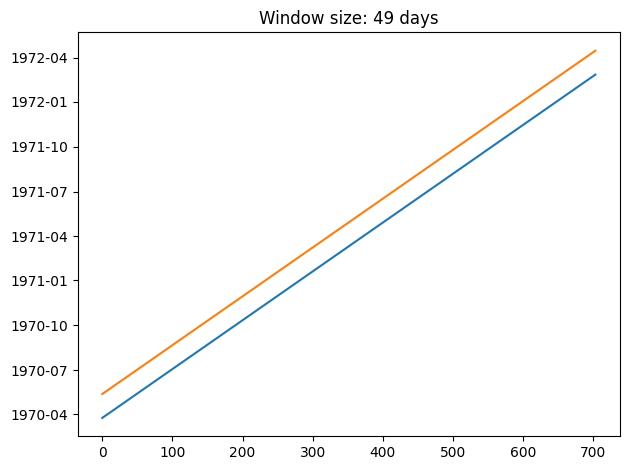

704


In [37]:
# sort log with start_times
from datetime import timedelta
import datetime

# most prominent companies
reduced_sorted_times = [t for t in sorted_times if (t[1][1]- t[1][0]).days < MAX_DURATION_JOURNEY]
company_list = []
for t in reduced_sorted_times:
    company_index = company_iterator[companies[t[0]]]
    company_list.append(company_index)


def sliding_window_logs(log, start_times, window_size_seconds, window_size_days = 49, min_size = 30, companies = [], draw_plot = False):
    assert(len(log) == len(start_times))
    merged = [(log, start_time) for log, start_time in zip (log, start_times)]
    start_times_sorted = sorted(merged, key=lambda item: item[1])
    sorted_log = [s[0] for s in start_times_sorted]
    sorted_times = [s[1] for s in start_times_sorted]

    assert(sorted(start_times) == sorted_times)
    sliced_logs = []
    sliced_companies = []
    sliced_start = []
    sliced_end = []

    latest_time = max(sorted_times)
    previous_start = 0

    #for current_start in sorted_times:
    for current_start in (min(sorted_times) + timedelta(days = n) for n in range((max(sorted_times)-min(sorted_times)).days+2)): # iterate over all days
        window_start = datetime.datetime(current_start.year, current_start.month, current_start.day, 0, 0, 0)
        window_end = datetime.datetime(current_start.year, current_start.month, current_start.day, 0, 0, 0)+timedelta(days = window_size_days)
        #if current_start == previous_start and False:
            #continue
        #previous_start = current_start
        if (latest_time - current_start).days <= min_size:
            continue
        current_log = []
        current_companies = []
        index = -1
        for trace, start_time in zip(sorted_log, sorted_times):
            index += 1
            if start_time >= window_start and start_time < window_end:
                current_log.append(trace)
                if companies != []:
                    current_companies.append(companies[index])
            #if start_time < current_start:
            #    continue
            #if (start_time - current_start).total_seconds() > window_size_seconds:
            #    break
            #current_log.append(trace)
        #if len(current_log)>min_size:
        sliced_logs.append(current_log)
        sliced_companies.append(current_companies)
        sliced_start.append(window_start)
        sliced_end.append(window_end)
    
    if draw_plot:
        plt.plot(range(len(sliced_start)), sliced_start)
        plt.plot(range(len(sliced_end)), sliced_end)
        plt.title("Window size: "+str(window_size_days)+ " days")
        plt.savefig("/home/paul/Documents/User-Journey-Games/windows/windows.png")
        plt.show()
    if companies == []:
        return sliced_logs
    else:
        return sliced_logs, sliced_companies

sliced_logs, sliced_companies = sliding_window_logs(log, start_times, WINDOW_SIZE, min_size = 10, draw_plot = True, window_size_days=49, companies=company_list)

print(len(sliced_logs))

In [38]:
# analyse same start time:
def analyse_start_time(log, start_times):
    assert(len(log) == len(start_times))
    merged = [(log, start_time) for log, start_time in zip (log, start_times)]
    start_times_sorted = sorted(merged, key=lambda item: item[1])
    sorted_log = [s[0] for s in start_times_sorted]
    sorted_times = [s[1] for s in start_times_sorted]

    assert(sorted(start_times) == sorted_times)

    latest_time = max(sorted_times)
    previous_start = 0
    for i  in range(len(sorted_times)):
        current_start = sorted_times[i]
        if current_start == previous_start:
            print("Same", i)
            continue
        previous_start = current_start
analyse_start_time(log, start_times)

Same 4
Same 5
Same 9
Same 12
Same 14
Same 15
Same 16
Same 17
Same 20
Same 21
Same 22
Same 23
Same 26
Same 27
Same 31
Same 32
Same 39
Same 40
Same 41
Same 42
Same 43
Same 44
Same 52
Same 53
Same 54
Same 55
Same 56
Same 57
Same 58
Same 63
Same 64
Same 65
Same 66
Same 67
Same 68
Same 83
Same 84
Same 88
Same 90
Same 91
Same 92
Same 93
Same 97
Same 98
Same 99
Same 100
Same 101
Same 102
Same 103
Same 108
Same 109
Same 110
Same 111
Same 112
Same 113
Same 140
Same 141
Same 142
Same 143
Same 153
Same 154
Same 159
Same 160
Same 161
Same 162
Same 163
Same 164
Same 165
Same 166
Same 167
Same 168
Same 169
Same 171
Same 172
Same 173
Same 174
Same 175
Same 176
Same 177
Same 178
Same 179
Same 180
Same 181
Same 183
Same 184
Same 185
Same 186
Same 188
Same 189
Same 194
Same 195
Same 196
Same 197
Same 198
Same 199
Same 200
Same 201
Same 202
Same 203
Same 204
Same 205
Same 206
Same 207
Same 233
Same 270
Same 271
Same 272
Same 333
Same 334
Same 348
Same 350
Same 351
Same 352
Same 357
Same 381
Same 382
Same

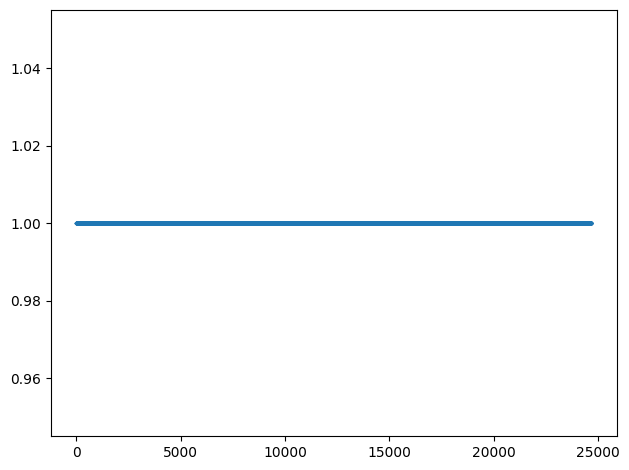

In [39]:
contained = []
for l in sliced_logs:
    for t in l:
        if "Preliminary results updated for overall score:" in t:
            contained.append(0)
            break
        contained.append(1)

plt.scatter(range(len(contained)), contained, s = 2)

704


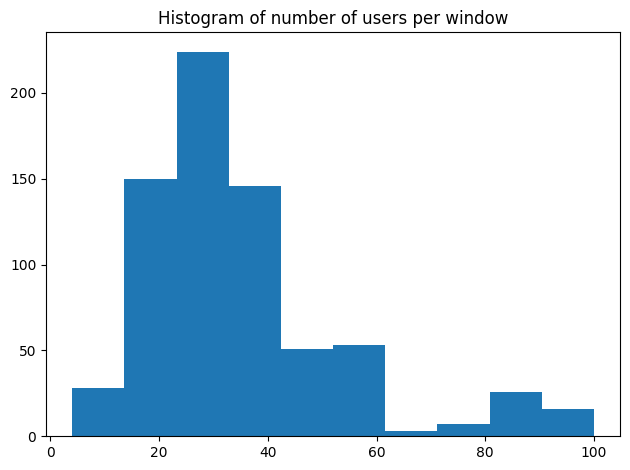

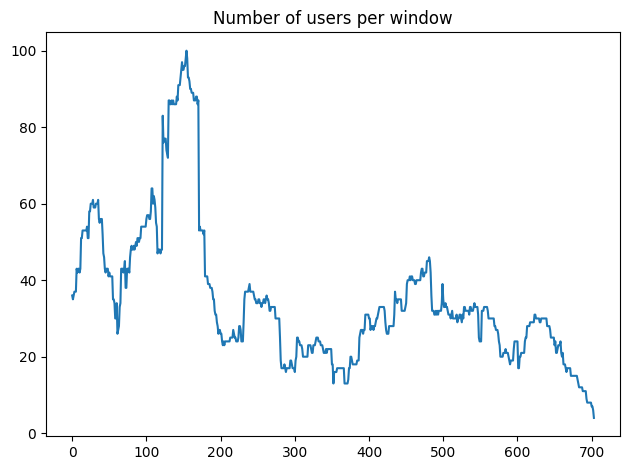

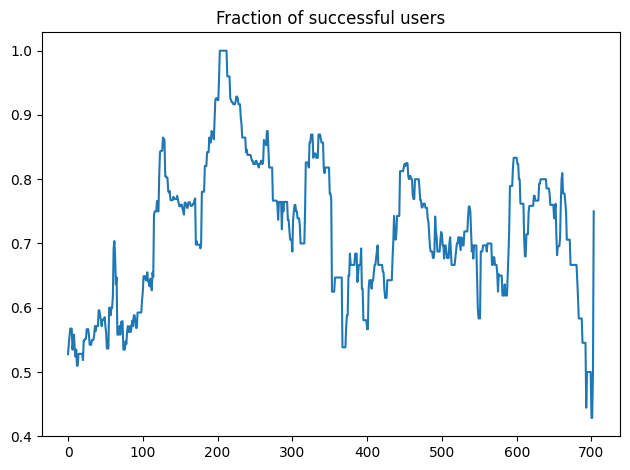

In [40]:
print(len(sliced_logs))
plt.hist([len(l) for l in sliced_logs])
plt.title("Histogram of number of users per window")
plt.show()

plt.plot(range(len(sliced_logs)), [len(l) for l in sliced_logs])
plt.title("Number of users per window")
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/#users.png")
plt.show()

fractions = []
for l in sliced_logs:
    pos = [t for t in l if "finPos" in t]
    neg = [t for t in l if "finNeg" in t]
    assert(len(l) >0)
    fractions.append(len(pos)/len(l))
    assert(len(pos)+len(neg) == len(l))
plt.plot(range(len(fractions)), fractions)
plt.title("Fraction of successful users")
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/fractions.png")
plt.show()

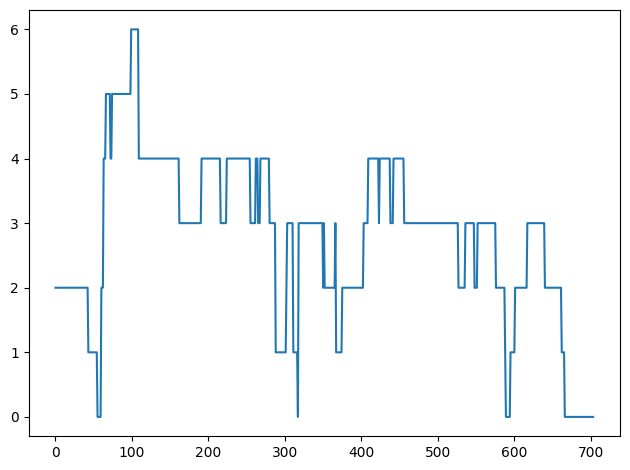

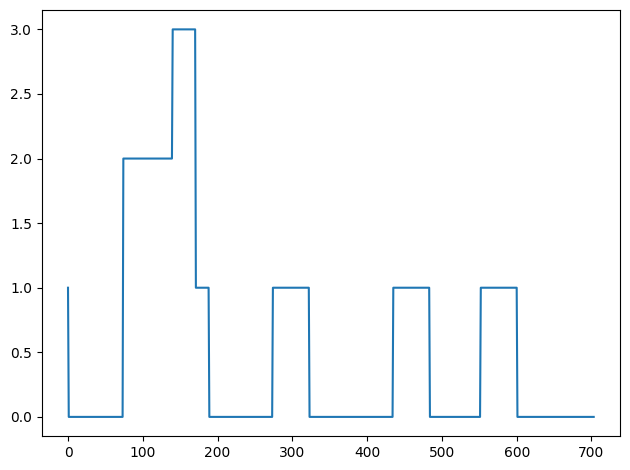

In [41]:
def analyse_models(sliced_logs):
    loops = []
    for l in sliced_logs:
        help_g = build_dfg(l, 3)
        loops.append(len(list(nx.simple_cycles(help_g))))
    plt.plot(range(len(loops)), loops)
    plt.show()

    loops = []
    for l in sliced_logs:
        help_g, edge_mapping = transition_system(l, 2, sequence)

        edge_to_remove = []
        for e in help_g.edges:
            if len(edge_mapping[e]) <= 0:
                edge_to_remove.append(e)
        help_g.remove_edges_from(edge_to_remove)
        #print("Edges removed", len(edge_to_remove), "from", len(help_g.edges))
        #print("nodes removed", len(list(nx.isolates(help_g))), "from", len(help_g.nodes))
        help_g.remove_nodes_from(list(nx.isolates(help_g)))
        
        loops.append(len(list(nx.simple_cycles(help_g))))
    plt.plot(range(len(loops)), loops)
    plt.show()

analyse_models(sliced_logs)

In [42]:
def time_analysis(sliced_logs, edge_threshold_start = 3, compute_distance = True):
    result_dict = {
        "loops" : [],
        "mc_results" : [],
        "distances" : [],
        "colors" : [],
        "distances_previous" : [0],
        "fractions" : [],
        "edge_thresholds" : [],
        "sums" : [],
        "accuracies" : [],
        "images" : [],
        "negative_edges" : []
    }

    omitted_counter = 0
    successfully_computed = 0

    for l in sliced_logs:
        result_dict["fractions"].append(len([t for t in l if "finPos" in t])/len(l))
        edge_threshold = edge_threshold_start

        if compute_distance:
            if len(result_dict["distances"]) > 0:
                result_dict["distances_previous"].append(nx.graph_edit_distance(build_dfg(l, edge_threshold), help_g, timeout = 10))

        help_g = build_dfg(l, edge_threshold)

        while not nx.is_weakly_connected(help_g) or not "finPos" in list(nx.descendants(help_g, "start")):
            print("not connected")
            draw_dfg(help_g, "graph_error.ps")
            edge_threshold -= 1
            if edge_threshold == -1:
                assert(False)
            help_g = build_dfg(l, edge_threshold)
            draw_dfg(help_g, "graph_error.ps")

        loop_number = len(list(nx.simple_cycles(help_g)))
        while(loop_number > 6):
            edge_threshold += 1
            help_g = build_dfg(l, edge_threshold)
            loop_number = len(list(nx.simple_cycles(help_g)))

        if compute_distance:
            print("compute distance")
            result_dict["distances"].append(nx.graph_edit_distance(g_old, help_g, timeout = 10))
        #assert(nx.is_weakly_connected(help_g))
        result_dict["loops"].append(loop_number)
        result_dict["edge_thresholds"].append(edge_threshold)
        #while len(list(nx.simple_cycles(help_g)))>8:
        #    edge_threshold += 1
        #    help_g = build_dfg(l, edge_threshold)
        #    print("in loop")
        if len(list(nx.simple_cycles(help_g))) > 6 or not nx.is_weakly_connected(help_g) or not "finPos" in list(nx.descendants(help_g, "start")):
            omitted_counter += 1
            result_dict["colors"].append("r")
            continue
        extend_graph_with_actors(help_g,actors)
        help_edge_cost = compute_edge_cost(help_g, l)

        negative_edges = [e for e in help_edge_cost if help_edge_cost[e] < 0]
        result_dict["negative_edges"].append(negative_edges)

        sums = [] #sums for log
        for trace in l:
            running_sum = 0
            pairs = [(trace[i], trace[i+1]) for i in range(len(trace)-1)]
            running_sum = sum(help_edge_cost[p] for p in pairs if p in help_edge_cost)
            sums.append(running_sum)
        result_dict["sums"].append(running_sum)

        # think more if accuracies good to include - seems to be difficult to defend...
        #
        #true_values = ["finPos" in t for t in l]
        #print("true vals", true_values)
        #print(len([t for t in l if "finPos" in t])/len(l))
        #correct_value = 0
        #for i in range(len(sums)):
        #    print(sums[i], true_values[i],sums[i]*true_values[i] )
        #    if sums[i]>0 and true_values[i] :
        #        correct_value+=1
        #print("accuracy", correct_value, len(l))
        #result_dict["accuracies"].append(correct_value/len(l))

        help_g = annotate_graph(help_g, help_edge_cost)
        help_g_outgoing = color_graph(help_g)
        
        if "start" not in help_g.nodes:
            print(len(l))
            print(l)
            draw_dfg(help_g, "graph_error.ps")
        
        file_name = "./gif/graph"+str(len(result_dict["loops"]))+".png"
        to_gif_g = copy.deepcopy(help_g)
        for e in to_gif_g.edges:
            if help_edge_cost[e] < 0:
                to_gif_g.edges[e]['color'] = "red"
            else:
                to_gif_g.edges[e]['color'] = "grey"
        draw_dfg(to_gif_g, file_name)
        result_dict["images"].append(file_name)

        help_g_unroll = unroll(help_g, "start", ["finPos", "finNeg"], 1)
        draw_dfg(help_g, "graph_loops.ps")
        #draw_dfg(help_g_unroll, "graph_loops_unrolled.ps")
        to_uppaal(help_g_unroll)

        out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
        out.wait()
        results, err = out.communicate()
        results = results.decode("utf-8") 
        err = err.decode("utf-8") 
        if err != "":
            results = [-1,-1,-1,-1,-1,-1]
        else:
            results = results.split("\n")
            results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
            results = [r.replace("≈", "") for r in results]
            results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
            successfully_computed += 1
        assert(len(results) == 6)

        result_dict["mc_results"].append(results)
        
        result_dict["colors"].append("b" if list(set(results)) == [-1] else "g")
        print("Progress", len(result_dict["loops"]), "/", len(sliced_logs))

    print("Successfully computed", successfully_computed)
    return result_dict

#sliced_logs = sliced_logs[::10]
#result_dict = time_analysis(sliced_logs, compute_distance=False)

In [43]:
def plot_results(result_dict):
    colors = result_dict["colors"]
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0,0].hist(result_dict["loops"], 20)

    axs[0,1].scatter(range(len(result_dict["loops"])), result_dict["loops"], s = 2)
    axs[0,1].set_title("Loops")

    axs[1,0].scatter(range(len(result_dict["distances"])), result_dict["distances"], s = 2)
    axs[1,0].set_title("Distances")

    axs[1,1].scatter(range(len(result_dict["distances_previous"])), result_dict["distances_previous"], s = 2)
    axs[1,1].set_title("Pairwise - Distances")
    
    axs[2,0].plot(range(len(result_dict["fractions"])), result_dict["fractions"])
    axs[2,0].set_title("Fractions")

    axs[2,1].plot(range(len(result_dict["sliced_logs"])), [len(l) for l in result_dict["sliced_logs"]])
    axs[2,1].set_title("#Users")

    axs[3,0].scatter(range(len(result_dict["sums"])), [np.median(s) for s in result_dict["sums"]], s = 10)
    axs[3,0].set_title("Median replays")

    axs[4,0].scatter(range(len(result_dict["negative_edges"])), [len(e) for e in result_dict["negative_edges"]], s = 10)
    axs[4,0].set_title("Number negative edges")

    axs[4,1].scatter(range(len(result_dict["negative_edges"])), [-len(e) for e in result_dict["negative_edges"]], s = 10)
    axs[4,1].set_title("Number negative edges inverted")

    fig.show()

def plot_mc_results(mc_results, colors):
    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    lables = ["max_steps", "min_gas", "max_final_gas"]
    for i in range(6):
        axs[i//3,i%3].scatter(range(len(mc_results)), [r[i] for r in mc_results], s = 2, c = colors)
        axs[i//3,i%3].plot(range(len(mc_results)), [r[i] for r in mc_results])
        axs[i//3,i%3].set_title(lables[i%3])
    fig.show()

    
#plot_results(result_dict)
#plot_mc_results(result_dict["mc_results"], result_dict["colors"])

In [44]:
"""
negative_edges = result_dict["negative_edges"]
edge_set = {}
for inner_set in negative_edges:
    for e in inner_set:
        if e not in edge_set:
            edge_set[e] = 1
        else:
            edge_set[e] += 1
dict(sorted(edge_set.items(), key=lambda item: item[1], reverse = True))
"""

'\nnegative_edges = result_dict["negative_edges"]\nedge_set = {}\nfor inner_set in negative_edges:\n    for e in inner_set:\n        if e not in edge_set:\n            edge_set[e] = 1\n        else:\n            edge_set[e] += 1\ndict(sorted(edge_set.items(), key=lambda item: item[1], reverse = True))\n'

In [45]:
# generate git from images
import imageio

def generate_gif(image_names):
    images = []
    for filename in image_names:
        images.append(imageio.imread(filename))
    imageio.mimsave('./gif/merged.gif', images, fps=3)

## Where are users lost?

In [46]:
"""

# analyse lost users
def lost_users(sliced_logs, draw_plots = True):
    lost_users = []
    name_dict = {}
    counter = 0
    for l in sliced_logs:
        current_lost_users = {}
        negative_traces = [t for t in l if "finNeg" in t]
        negative_endings = [(t[-2],t[-1]) for t in negative_traces]
        for e in negative_endings:
            if e not in name_dict:
                if "Task event: loggedIn" in e[0]:
                    assert("TE-L" not in name_dict)
                    name_dict[e] = "TE-L"
                elif "Task event" in e[0]:
                    assert("TE" + e[0][-1] not in name_dict)
                    name_dict[e] = "TE" + e[0][-1]
                else:
                    name_dict[e] = "E"+str(counter)
                counter += 1
            e = name_dict[e]
            if e not in current_lost_users:
                current_lost_users[e] = 1/len(l)
            else:
                current_lost_users[e] += 1/len(l)
        if draw_plots:
            x = [str(e) for e in current_lost_users]
            y = [current_lost_users[e] for e in current_lost_users]
            plt.bar(x,y)
            plt.savefig("./gif/bar"+str(len(lost_users))+".png")
            plt.close()
        lost_users.append(current_lost_users)
    return lost_users, name_dict

#sliced_logs = sliding_window_logs(log, start_times, WINDOW_SIZE)
lost_users, name_dict = lost_users(sliced_logs, draw_plots = False)

print("Naming", name_dict)
peaks_plot = []
peaks_plot_set = []
peaks = {}
for lost in lost_users:
    m = max(lost, key=lost.get)
    m_set = str(sorted(sorted(lost, key=lost.get, reverse = True)[:3]))
    peaks_plot_set.append(m_set)
    peaks_plot.append(m)
    if m not in peaks:
        peaks[m] = 1
    else:
        peaks[m] += 1
print("Peaks", peaks)

plt.plot(range(len(peaks_plot)), peaks_plot)
plt.title("Event with most users lost (to finNeg)")
plt.show()

differences = [0]
for i in range(1,len(peaks_plot_set)):
    diff = len([s for s in peaks_plot_set[i] if s not in peaks_plot_set[i-1]])
    assert(diff <= 2)
    differences.append(diff)
plt.scatter(range(len(differences)), differences, s = 2)
plt.title("Distances in sets")
plt.show()

colors = ["red" if c==2 else "orange" if c == 1 else "blue" for c in differences]
s = [10 if c==2 else 5 if c == 1 else 1 for c in differences]
plt.scatter(range(len(peaks_plot_set)), peaks_plot_set, s = s, c = colors)
plt.title("Event with most users lost (to finNeg) Set of 3")
plt.show()

differences = [0,0]
for i in range(2,len(peaks_plot_set)):
    diff = len([s for s in peaks_plot_set[i] if s not in peaks_plot_set[i-2]])
    assert(diff <= 3)
    differences.append(diff)
plt.scatter(range(len(differences)), differences, s = 2)
plt.title("2-Distances in sets")
plt.show()

colors = ["black" if c==3 else "red" if c==2 else "orange" if c == 1 else "blue" for c in differences]
s = [15 if c==3 else 10 if c==2 else 5 if c == 1 else 1 for c in differences]
plt.scatter(range(len(peaks_plot_set)), peaks_plot_set, s = s, c = colors)
plt.title("2Distance - Event with most users lost (to finNeg) Set of 3")
plt.show()


"""

'\n\n# analyse lost users\ndef lost_users(sliced_logs, draw_plots = True):\n    lost_users = []\n    name_dict = {}\n    counter = 0\n    for l in sliced_logs:\n        current_lost_users = {}\n        negative_traces = [t for t in l if "finNeg" in t]\n        negative_endings = [(t[-2],t[-1]) for t in negative_traces]\n        for e in negative_endings:\n            if e not in name_dict:\n                if "Task event: loggedIn" in e[0]:\n                    assert("TE-L" not in name_dict)\n                    name_dict[e] = "TE-L"\n                elif "Task event" in e[0]:\n                    assert("TE" + e[0][-1] not in name_dict)\n                    name_dict[e] = "TE" + e[0][-1]\n                else:\n                    name_dict[e] = "E"+str(counter)\n                counter += 1\n            e = name_dict[e]\n            if e not in current_lost_users:\n                current_lost_users[e] = 1/len(l)\n            else:\n                current_lost_users[e] += 1/len(l)\

In [47]:
g_old_history, h = transition_system(log_old, 2, sequence)

## Time Series Execution

In [48]:
def time_analysis(sliced_logs, abstraction_length = 1, edge_threshold = 0, compute_distance = True, distance_time = 10, draw_intermediate = False, draw_gif = False):
    result_dict = {
        "loops" : [],
        "mc_results" : [],
        "distances" : [],
        "distances_previous" : [0],
        "colors" : [],
        "fractions" : [],
        "edge_thresholds" : [],
        "sums" : [],
        "accuracies" : [],
        "images" : [],
        "negative_edges" : [],
        "sliced_logs" : sliced_logs
    }

    omitted_counter = 0
    successfully_computed = 0

    for l in sliced_logs:
        if len(l) == 0:
            result_dict["loops"].append(-1)
            result_dict["mc_results"].append([-10,-10,-10,-10,-10,-10])
            result_dict["distances"].append(-1)
            result_dict["distances_previous"].append(-1)
            result_dict["colors"].append("violet")
            result_dict["fractions"].append(-1)
            continue
        result_dict["fractions"].append(len([t for t in l if "finPos" in t])/len(l))
            

        if compute_distance:
            if len(result_dict["distances"]) > 0:
                h1, h2 = transition_system(l, abstraction_length, sequence)
                result_dict["distances_previous"].append(nx.graph_edit_distance(h1, help_g, timeout = distance_time))

        help_g, edge_mapping = transition_system(l, abstraction_length, sequence)
        extend_graph_with_actors(help_g,actors, transition_system=True)
        edge_to_remove = []
        for e in help_g.edges:
            if len(edge_mapping[e]) <= edge_threshold:
                edge_to_remove.append(e)
        help_g.remove_edges_from(edge_to_remove)
        help_g.remove_nodes_from(list(nx.isolates(help_g)))

        loop_number = len(list(nx.simple_cycles(help_g)))

        if compute_distance:
            print("compute distance")
            result_dict["distances"].append(nx.graph_edit_distance(g_old_history, help_g, timeout = distance_time))
        #assert(nx.is_weakly_connected(help_g))
        result_dict["loops"].append(loop_number)
        result_dict["edge_thresholds"].append(edge_threshold)

        if loop_number > 6 or nx.is_empty(help_g) or not nx.is_weakly_connected(help_g): #or not "finPos" in list(nx.descendants(help_g, "start")):

            result_dict["mc_results"].append([-10,-10,-10,-10,-10,-10])
            result_dict["colors"].append("brown")

            omitted_counter += 1
            #result_dict["colors"].append("r")
            if nx.is_empty(help_g):
                print("is empts")
            else:
                print("skipped analysis - is connected", nx.is_weakly_connected(help_g), "loops", loop_number)
            continue
        
        help_edge_cost = compute_edge_cost(help_g, l, edge_mapping)
        help_g = annotate_graph(help_g, help_edge_cost)
        help_g_outgoing = color_graph(help_g)

        negative_edges = [e for e in help_edge_cost if help_edge_cost[e] < 0]
        result_dict["negative_edges"].append(negative_edges)

        sums = [] #sums for log
        for trace in l:
            running_sum = 0
            pairs = [(trace[i], trace[i+1]) for i in range(len(trace)-1)]
            running_sum = sum(help_edge_cost[p] for p in pairs if p in help_edge_cost)
            sums.append(running_sum)
        result_dict["sums"].append(running_sum)

        # think more if accuracies good to include - seems to be difficult to defend...
        #
        #true_values = ["finPos" in t for t in l]
        #print("true vals", true_values)
        #print(len([t for t in l if "finPos" in t])/len(l))
        #correct_value = 0
        #for i in range(len(sums)):
        #    print(sums[i], true_values[i],sums[i]*true_values[i] )
        #    if sums[i]>0 and true_values[i] :
        #        correct_value+=1
        #print("accuracy", correct_value, len(l))
        #result_dict["accuracies"].append(correct_value/len(l))
        
        if "start" not in help_g.nodes:
            print(len(l))
            print(l)
            draw_dfg(help_g, "graph_error.ps")
        
        if draw_gif:
            file_name = "./gif/graph"+str(len(result_dict["loops"])-1)+".png" # -1 to make index = name
            to_gif_g = copy.deepcopy(help_g)
            for e in to_gif_g.edges:
                if help_edge_cost[e] < 0:
                    to_gif_g.edges[e]['color'] = "red"
                else:
                    to_gif_g.edges[e]['color'] = "grey"
            draw_dfg(to_gif_g, file_name)
            result_dict["images"].append(file_name)

        target = [s for s in help_g.nodes if "finPos" in s or "finNeg" in s]
        help_g_unroll = unroll(help_g, "start", target, 1)
        if draw_intermediate:
            draw_dfg(help_g, "graph_loops.ps")
            #draw_dfg(help_g_unroll, "graph_loops_unrolled.ps")
        to_uppaal_transition(help_g_unroll, "unrolled_graph_transition.xml", layout = "dot")

        out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
        out.wait()
        results, err = out.communicate()
        results = results.decode("utf-8") 
        err = str(err.decode("utf-8"))
        if err != "" and err != "Please restart UPPAAL with Internet.\n":
            results = [-1,-1,-1,-1,-1,-1]
        else:
            results = results.split("\n")
            results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
            results = [r.replace("≈", "") for r in results]
            results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
            successfully_computed += 1
        assert(len(results) == 6)

        result_dict["mc_results"].append(results)
        
        result_dict["colors"].append("b" if list(set(results)) == [-1] else "g")
        print("Progress", len(result_dict["loops"]), "/", len(sliced_logs))

    print("Successfully computed", successfully_computed)
    return result_dict

In [49]:
from multiprocessing import Pool
def compute_distances_pairwise(i):
    distance_time = 10
    if i == 0:
        return 0
    c1, c2 = transition_system(sliced_logs[i], 2, sequence)
    o1, o2 = transition_system(sliced_logs[i-1], 2, sequence)
    return nx.graph_edit_distance(c1, o1, timeout = distance_time)

def compute_distances(i):
    distance_time = 10
    c1, c2 = transition_system(sliced_logs[i], 2, sequence)
    return nx.graph_edit_distance(g_old_history, c1, timeout = distance_time)


In [50]:
if compute_dfg:
    result_dict_dfg = time_analysis(sliced_logs, edge_threshold = 3, compute_distance=False)

    import pickle 
    with open('result_dict_dfg.pkl', 'wb') as f:
        pickle.dump(result_dict_dfg, f)

In [51]:
import pickle
if not compute_dfg:
    with open('result_dict_dfg.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    result_dict_dfg = loaded_dict

/tmp/ipykernel_135209/4105243223.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_135209/4105243223.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


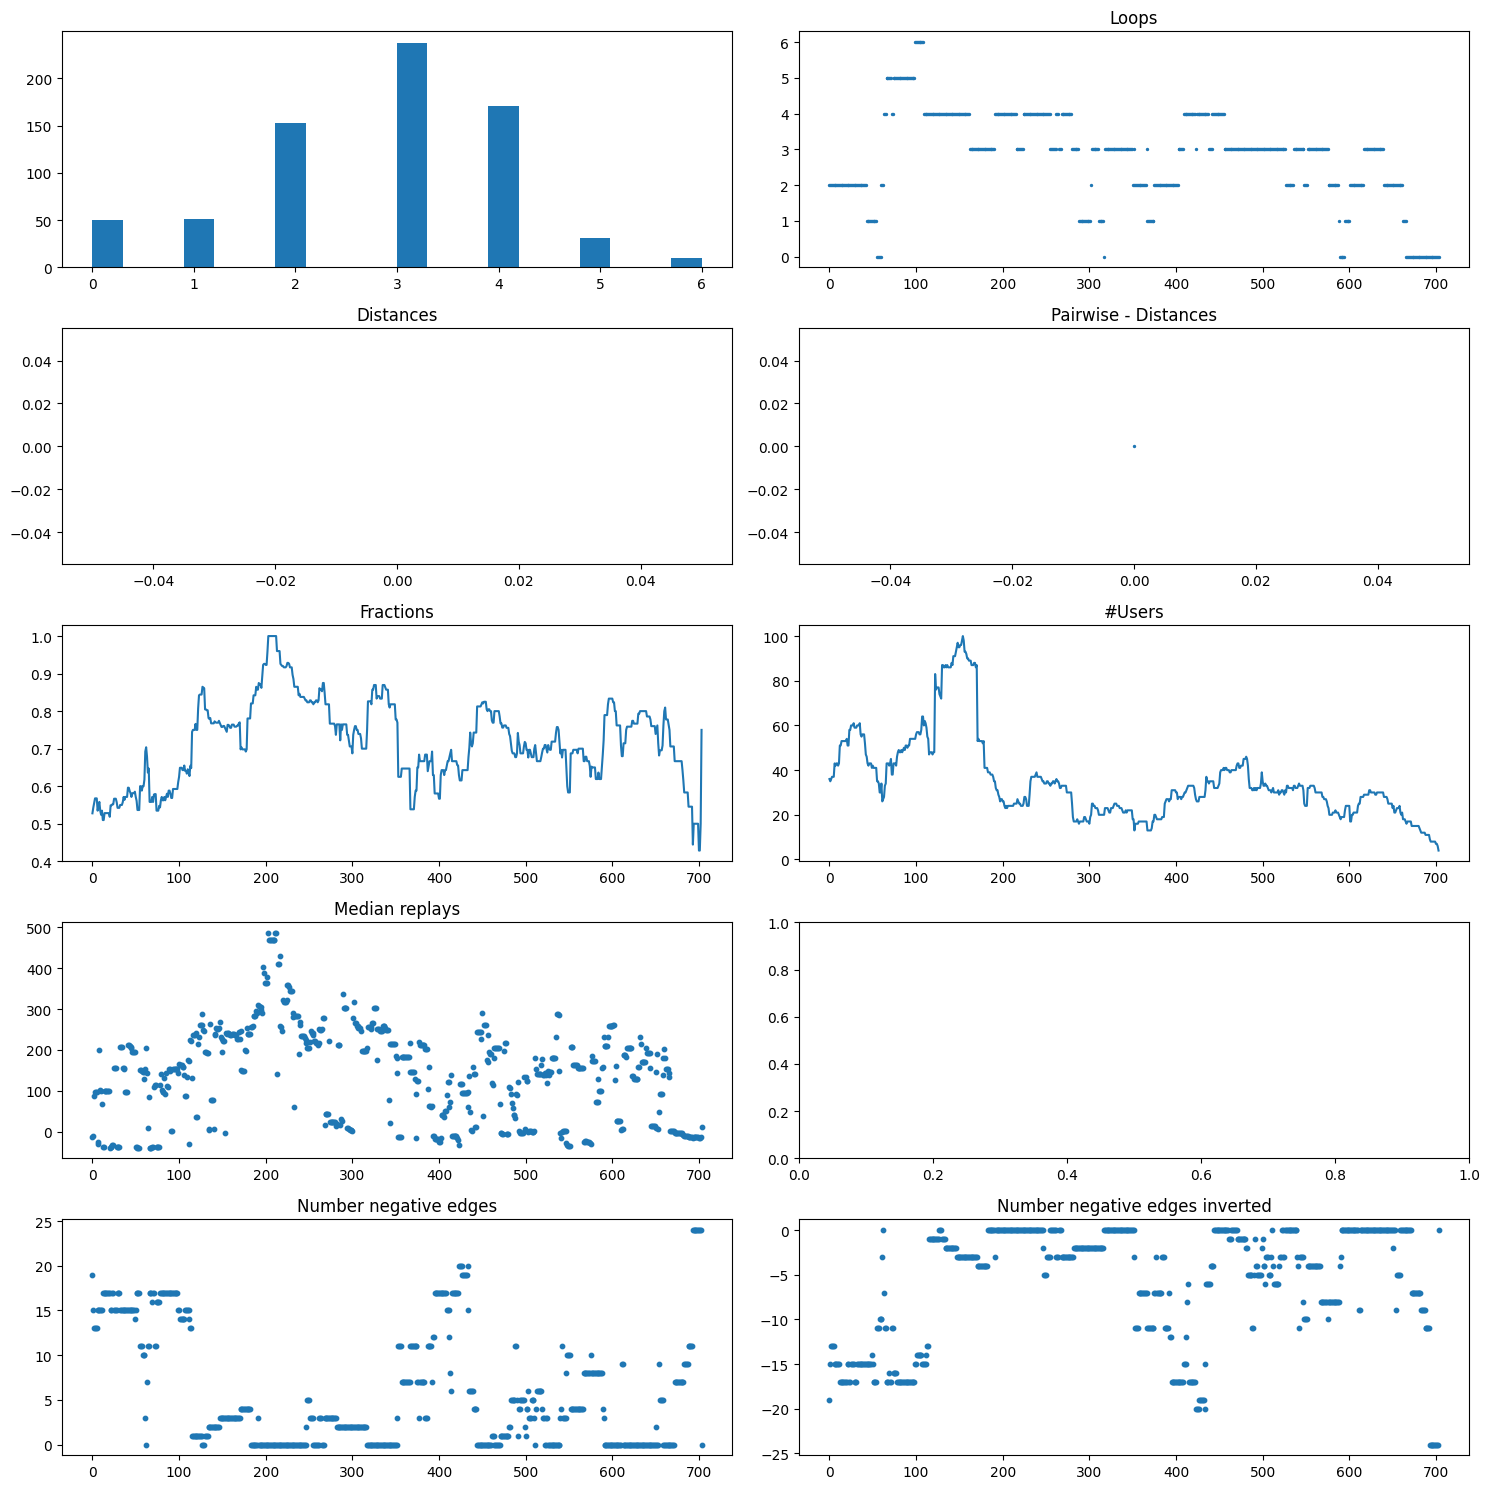

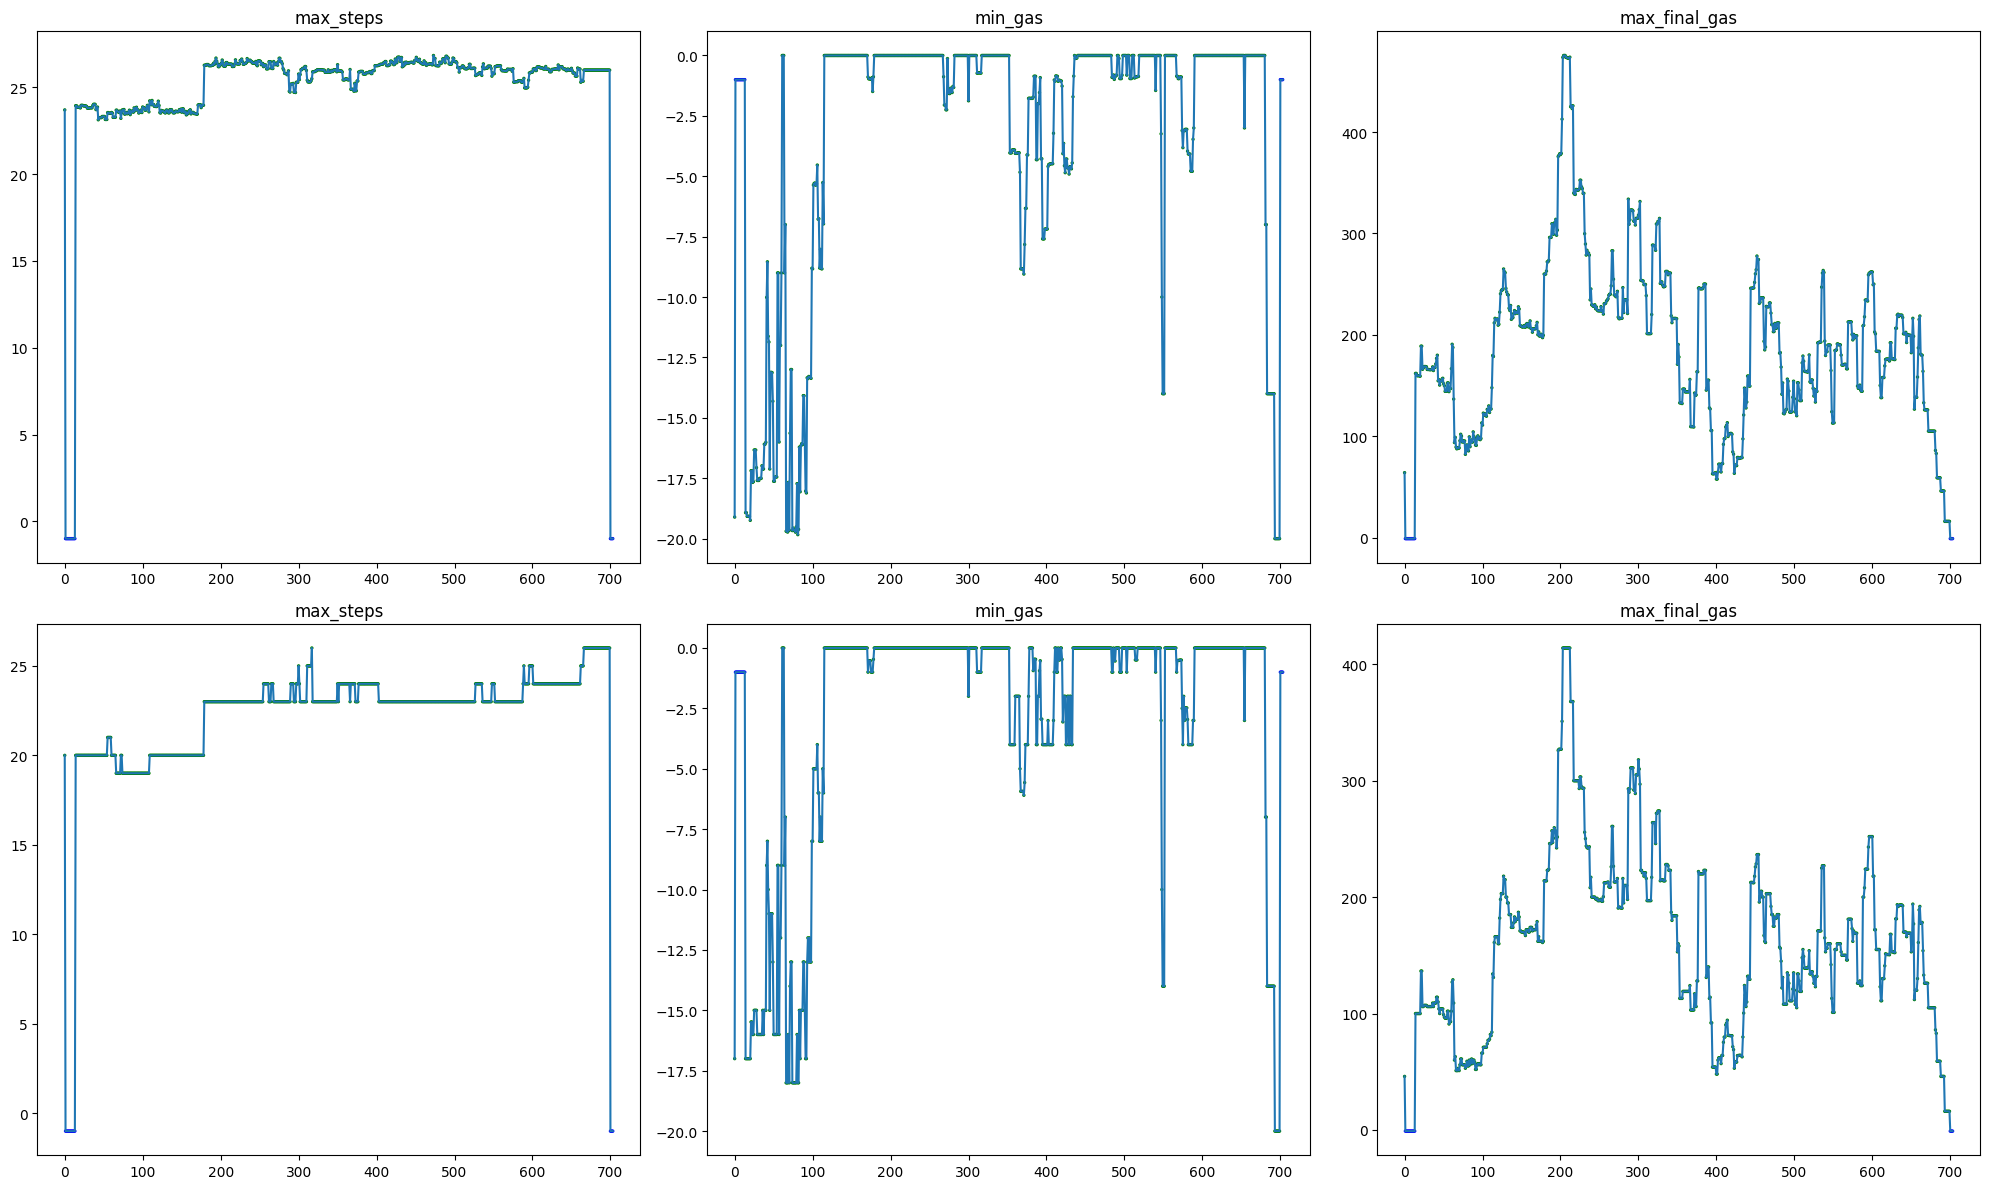

In [52]:
plot_results(result_dict_dfg)
plot_mc_results(result_dict_dfg["mc_results"], result_dict_dfg["colors"])

In [53]:
import pickle 

if compute_sequence:
    result_dict_sequence = time_analysis(sliced_logs, abstraction_length = 2, edge_threshold = 0, compute_distance=False, draw_gif=False)
    if compute_sequence_distance:
        with Pool(6) as p:
            result_dict_sequence['distances_previous'] = p.map(compute_distances_pairwise, range(len(sliced_logs)))
            result_dict_sequence['distances'] = p.map(compute_distances, range(len(sliced_logs)))
    with open('result_dict_sequence.pkl', 'wb') as f:
        pickle.dump(result_dict_sequence, f)

In [54]:
import pickle
if not compute_sequence:
    with open('result_dict_sequence.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    result_dict_sequence = loaded_dict

/tmp/ipykernel_135209/4105243223.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_135209/4105243223.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


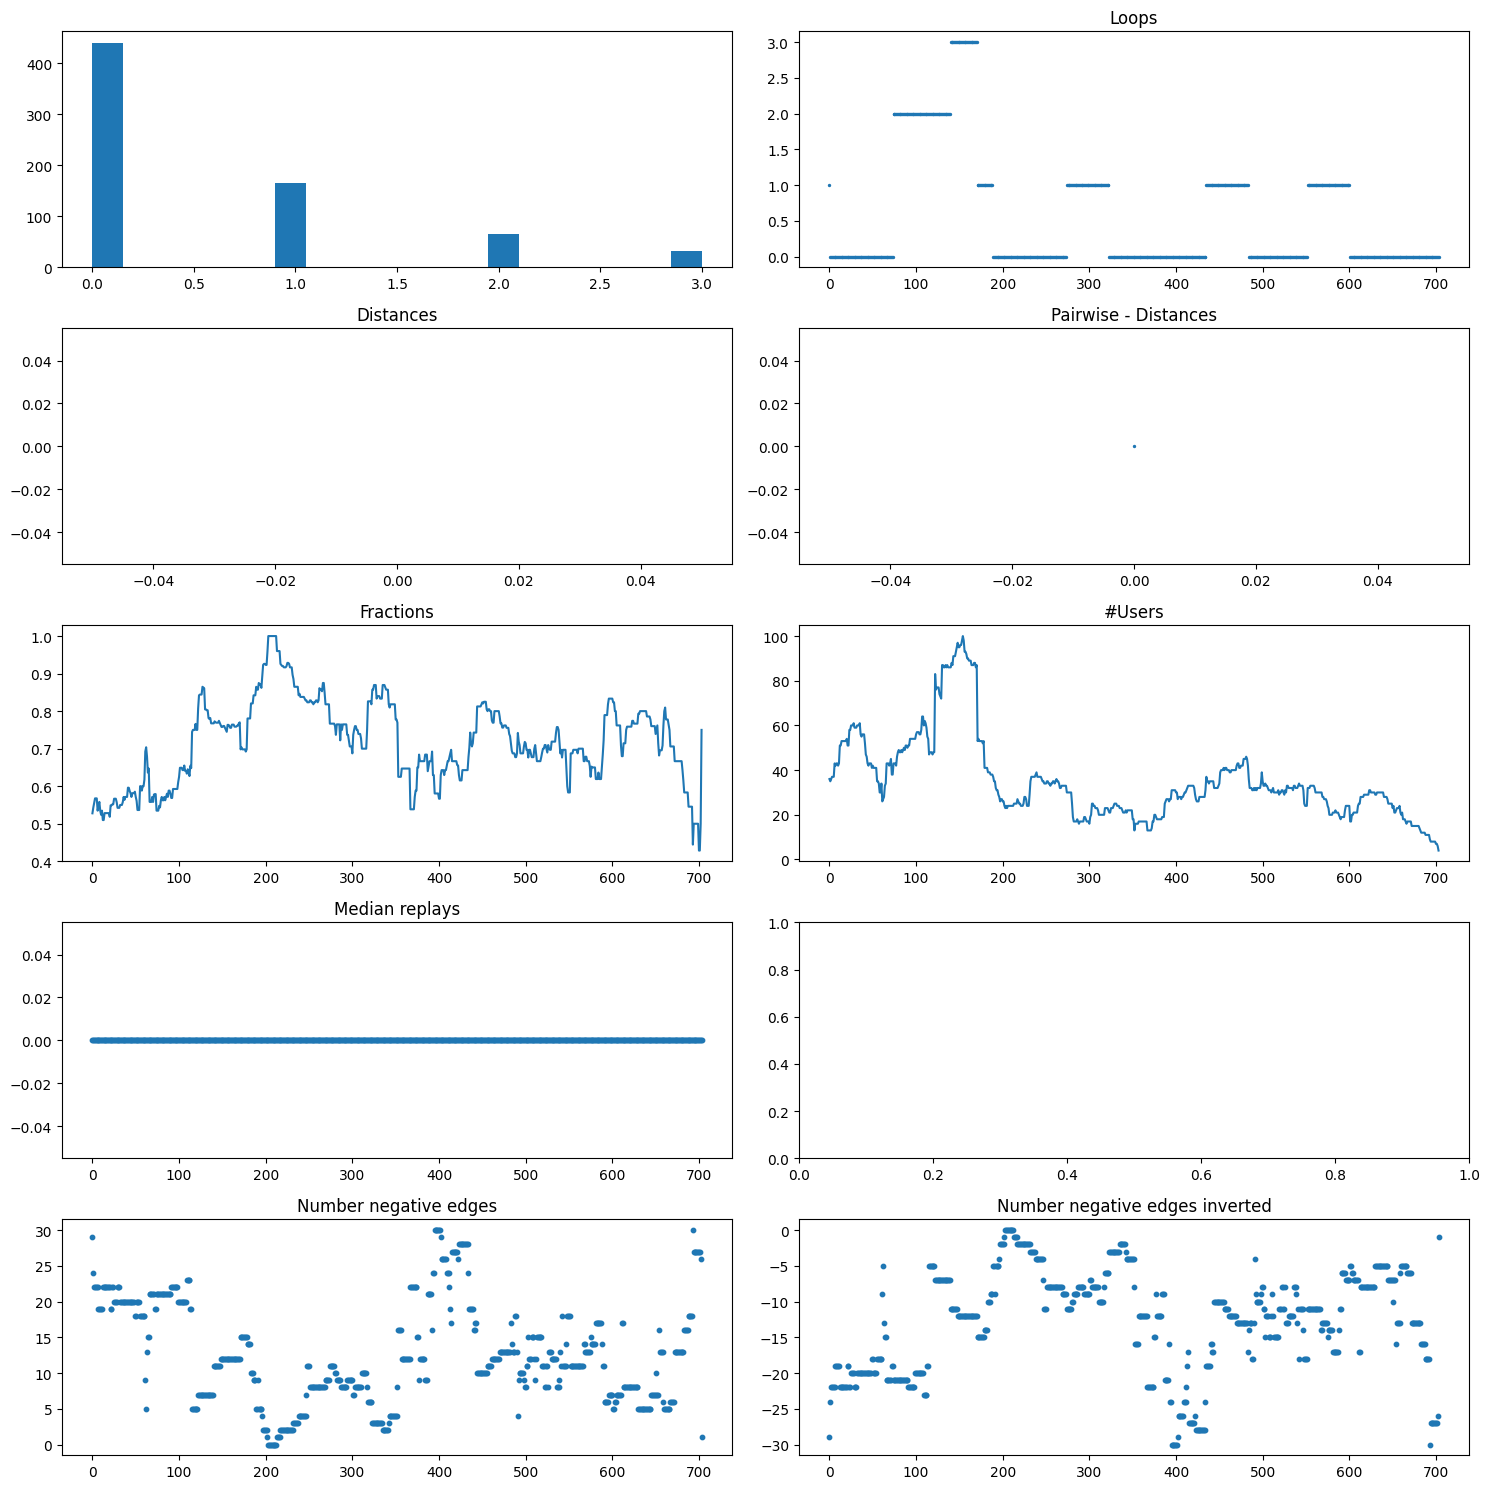

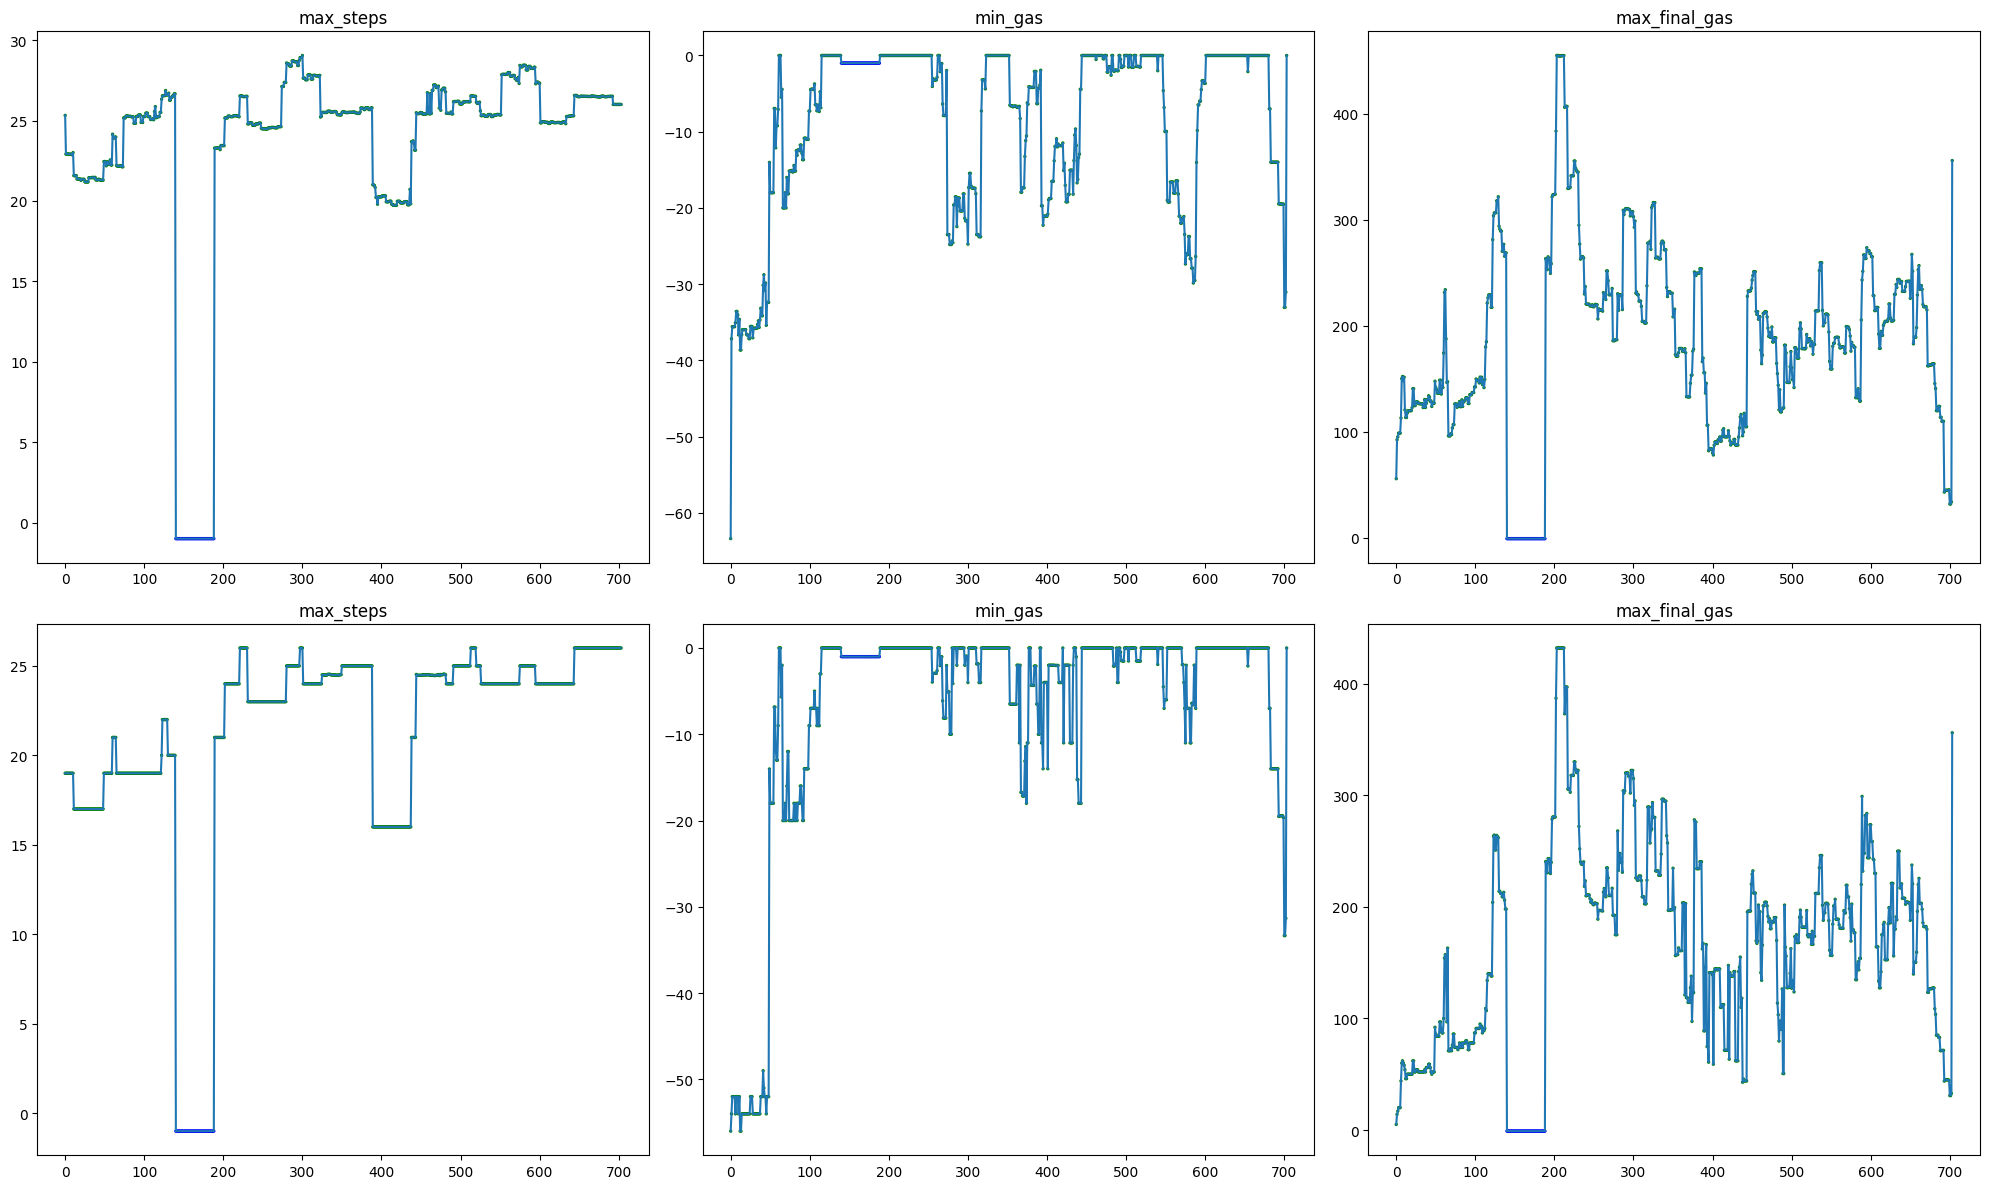

In [55]:
plot_results(result_dict_sequence)
plot_mc_results(result_dict_sequence["mc_results"], result_dict_sequence["colors"])

In [56]:
import itertools

def detect_range(L):
    for i, j in itertools.groupby(enumerate(L), lambda x: x[1] - x[0]):
        j = list(j)
        start = j[0][1]
        length = len(j)

        if length == 1:
            yield start
        else:
            yield (start, start+length)

correlations through strategy
[[1.         0.96362783]
 [0.96362783 1.        ]]
[[1.         0.78251904]
 [0.78251904 1.        ]]
[[1.         0.94266801]
 [0.94266801 1.        ]]
correlation min_gas, max_final_gas [[1.         0.32014932]
 [0.32014932 1.        ]]
range min gas 246 [(0, 55), 57, (66, 99), (274, 317), (367, 375), (393, 436), (437, 442), (552, 590), (683, 703)]
range max final 246 [(122, 140), (189, 195), (196, 238), (266, 268), (287, 303), (318, 342), 377, (384, 387), (452, 455), (535, 539), (590, 603), (652, 654), (660, 662), 703]


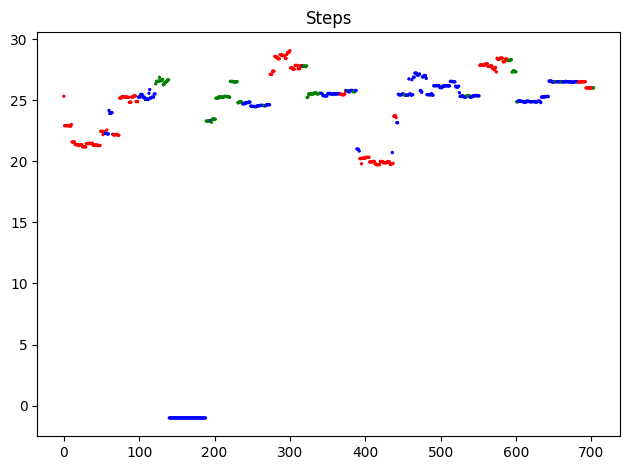

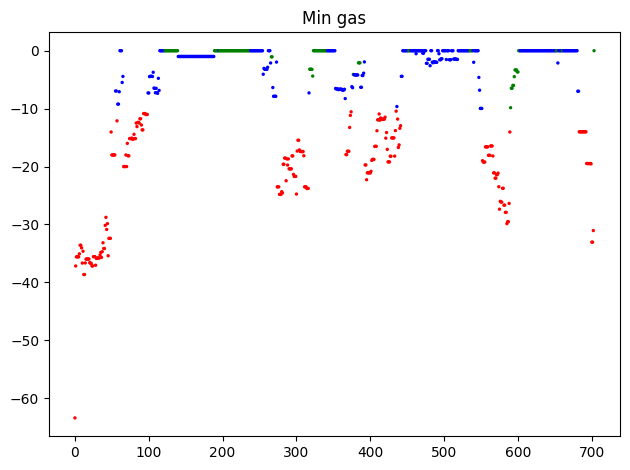

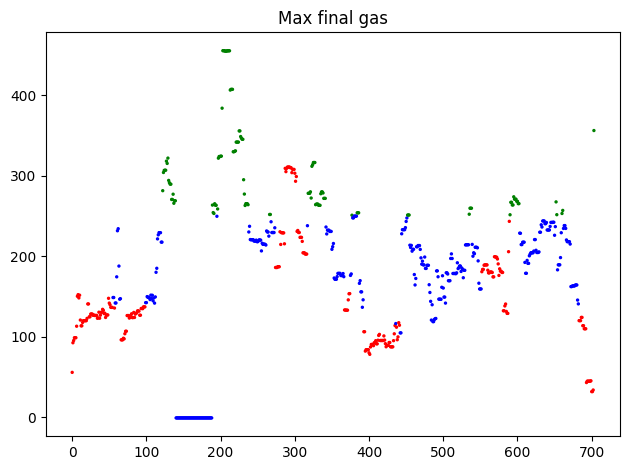

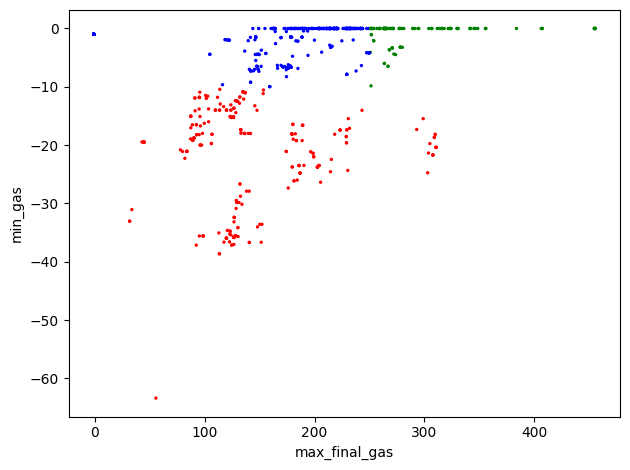

/tmp/ipykernel_135209/1224022968.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


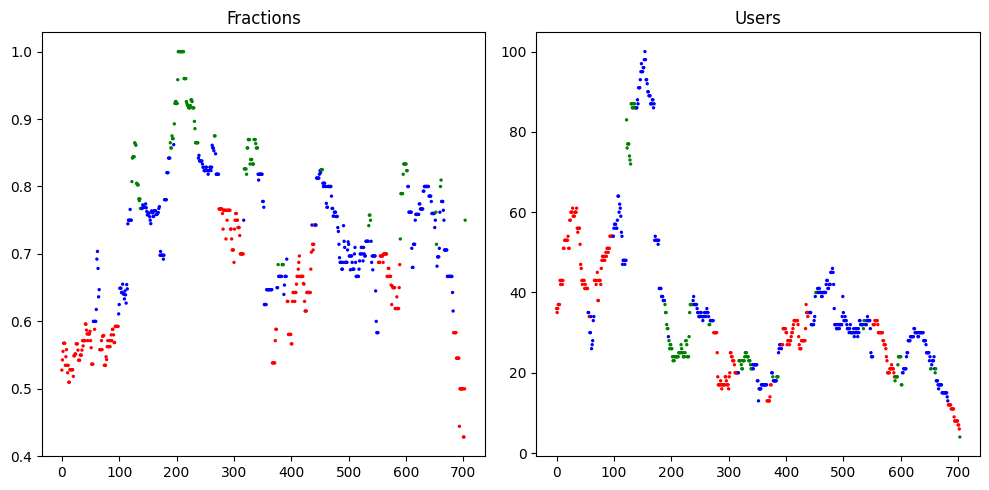

In [57]:
# analyse correlation between min_gas and max_final_gas
print("correlations through strategy")
for i in range(3):
    print(np.corrcoef([r[i] for r in result_dict_sequence["mc_results"]], [r[i+3] for r in result_dict_sequence["mc_results"]]))

steps = [r[0] for r in result_dict_sequence["mc_results"]]
min_gas = [r[1] for r in result_dict_sequence["mc_results"]]
max_final_gas = [r[2] for r in result_dict_sequence["mc_results"]]
print("correlation min_gas, max_final_gas", np.corrcoef(min_gas, max_final_gas))

min_gas_indices = [i for i in range(len(min_gas)) if min_gas[i]<=-10]
print("range min gas", len(min_gas_indices), list(detect_range(min_gas_indices)))

max_final_gas_indices = [i for i in range(len(max_final_gas)) if max_final_gas[i]>=250]
print("range max final", len(min_gas_indices), list(detect_range(max_final_gas_indices)))

colors = ["r" if i in min_gas_indices else "g" if i in max_final_gas_indices else "b" for i in range(len(min_gas))]

plt.scatter(range(len(steps)), steps, s = 2, c = colors)
plt.title("Steps")
plt.show()

plt.scatter(range(len(min_gas)), min_gas, s = 2, c = colors)
plt.title("Min gas")
plt.show()

plt.scatter(range(len(max_final_gas)), max_final_gas, s = 2, c = colors)
plt.title("Max final gas")
plt.show()

plt.scatter(max_final_gas, min_gas, s = 2,  c = colors)
plt.xlabel("max_final_gas")
plt.ylabel("min_gas")
plt.show()

#plt.plot(range(len(result_dict_sequence["fractions"])), result_dict_sequence["fractions"])
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(range(len(result_dict_sequence["fractions"])), result_dict_sequence["fractions"], s = 2, c = colors)
axs[0].set_title("Fractions")
axs[1].scatter(range(len(result_dict_sequence["sliced_logs"])), [len(l) for l in result_dict_sequence["sliced_logs"]], s = 2, c = colors)
axs[1].set_title("Users")
fig.show()

correlations through strategy
[[1.         0.96362783]
 [0.96362783 1.        ]]
[[1.         0.78251904]
 [0.78251904 1.        ]]
[[1.         0.94266801]
 [0.94266801 1.        ]]
correlation min_gas, max_final_gas [[1.         0.49462768]
 [0.49462768 1.        ]]
range min gas 145 [(0, 55), (57, 60), (66, 99), (277, 280), 365, (367, 377), (389, 391), (393, 396), 401, 421, (429, 433), (438, 444), 575, (581, 583), (683, 703)]
range max final 145 [(123, 130), (197, 233), 280, (287, 303), (318, 328), (336, 344), (377, 380), 589, (593, 596), (599, 603), 703]


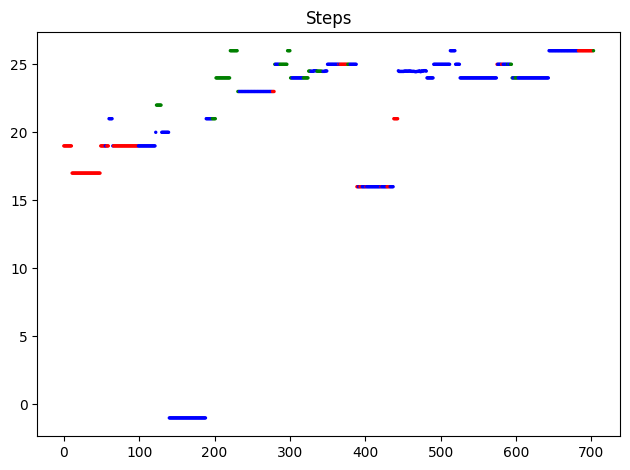

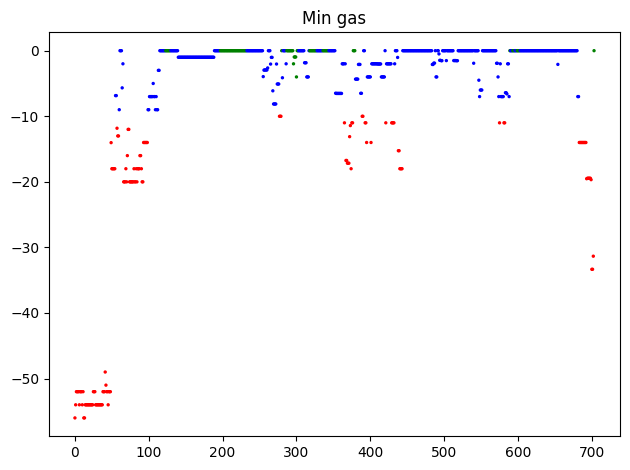

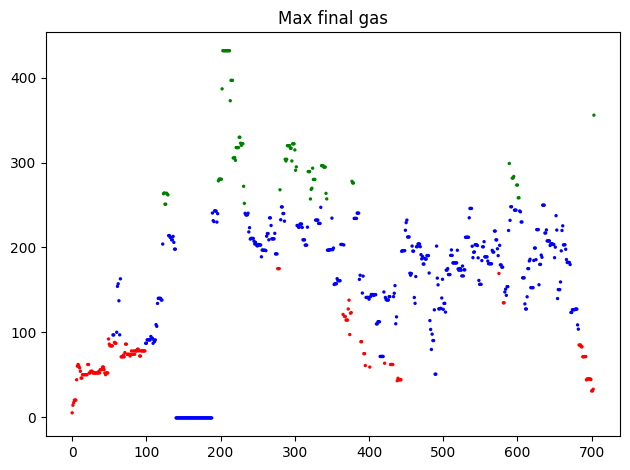

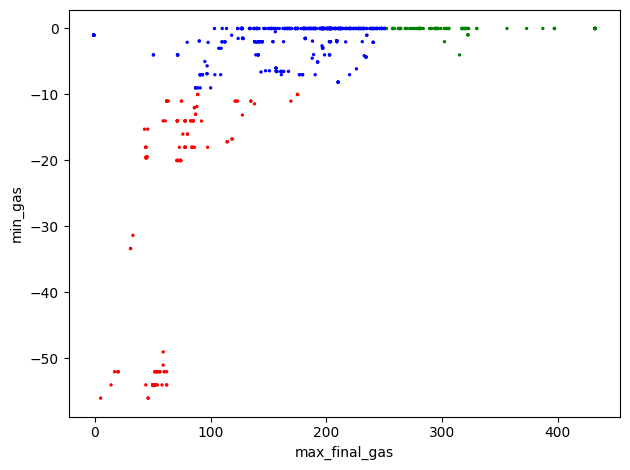

/tmp/ipykernel_135209/1169711757.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


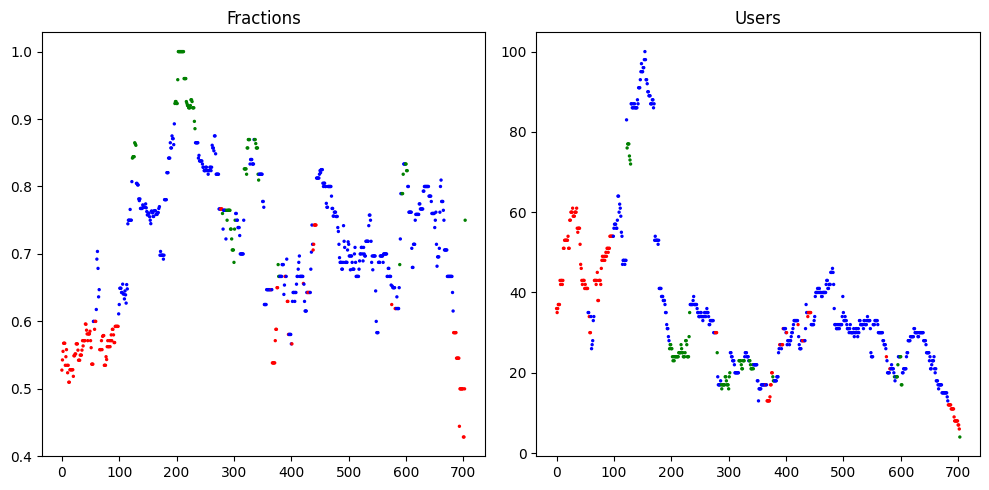

In [58]:
# analyse correlation between min_gas and max_final_gas
print("correlations through strategy")
for i in range(3):
    print(np.corrcoef([r[i] for r in result_dict_sequence["mc_results"]], [r[i+3] for r in result_dict_sequence["mc_results"]]))

steps = [r[3] for r in result_dict_sequence["mc_results"]]
min_gas = [r[4] for r in result_dict_sequence["mc_results"]]
max_final_gas = [r[5] for r in result_dict_sequence["mc_results"]]
print("correlation min_gas, max_final_gas", np.corrcoef(min_gas, max_final_gas))

min_gas_indices = [i for i in range(len(min_gas)) if min_gas[i]<=-10]
print("range min gas", len(min_gas_indices), list(detect_range(min_gas_indices)))

max_final_gas_indices = [i for i in range(len(max_final_gas)) if max_final_gas[i]>=250]
print("range max final", len(min_gas_indices), list(detect_range(max_final_gas_indices)))

colors = ["r" if i in min_gas_indices else "g" if i in max_final_gas_indices else "b" for i in range(len(min_gas))]

plt.scatter(range(len(steps)), steps, s = 2, c = colors)
plt.title("Steps")
plt.show()

plt.scatter(range(len(min_gas)), min_gas, s = 2, c = colors)
plt.title("Min gas")
plt.show()

plt.scatter(range(len(max_final_gas)), max_final_gas, s = 2, c = colors)
plt.title("Max final gas")
plt.show()

plt.scatter(max_final_gas, min_gas, s = 2,  c = colors)
plt.xlabel("max_final_gas")
plt.ylabel("min_gas")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(range(len(result_dict_sequence["fractions"])), result_dict_sequence["fractions"], s = 2, c = colors)
axs[0].set_title("Fractions")
axs[1].scatter(range(len(result_dict_sequence["sliced_logs"])), [len(l) for l in result_dict_sequence["sliced_logs"]], s = 2, c = colors)
axs[1].set_title("Users")
fig.show()

[8, 62, 129, 203, 204, 205, 266, 267, 290, 291, 292, 293, 325, 326, 327, 384, 385, 386, 414, 452, 453, 454, 511, 536, 537, 538, 569, 570, 595, 634, 635, 636, 652, 703]


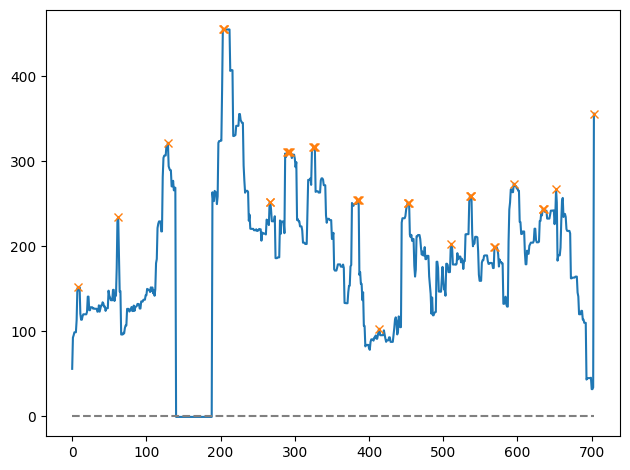

[8, 21, 22, 65, 124, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 297, 298, 299, 336, 337, 338, 377, 451, 491, 511, 536, 537, 538, 569, 570, 589, 634, 635, 636, 652, 703]


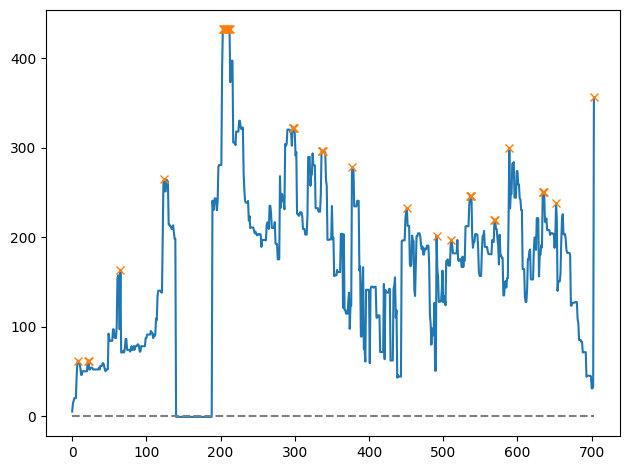

In [59]:
from scipy.signal import find_peaks

def local_peaks(x, width, thresh = 0):
    peaks = []
    for i in range(len(x)):
        results = [x[i] >= j and x[i] >= thresh for j in x[max(0,i-width):min(i+width+1, len(x))]]
        if all(results):
            peaks.append(i)
    return peaks

x = [r[2] for r in result_dict_sequence["mc_results"]]
#peaks, _ = find_peaks(x, height=0, width = 15)
peaks = local_peaks(x,15)
print(peaks)
plt.plot(x)
plt.plot(peaks, np.array(x)[np.array(peaks)], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

x = np.array([r[5] for r in result_dict_sequence["mc_results"]])
#peaks, _ = find_peaks(x, height=0, width = 10)
peaks = local_peaks(x,15)
print(peaks)
plt.plot(x)
plt.plot(peaks, np.array(x)[np.array(peaks)], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

not computed are [(140, 189)]


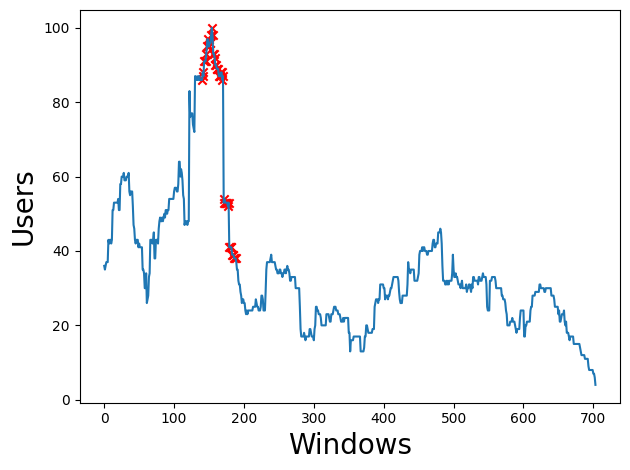

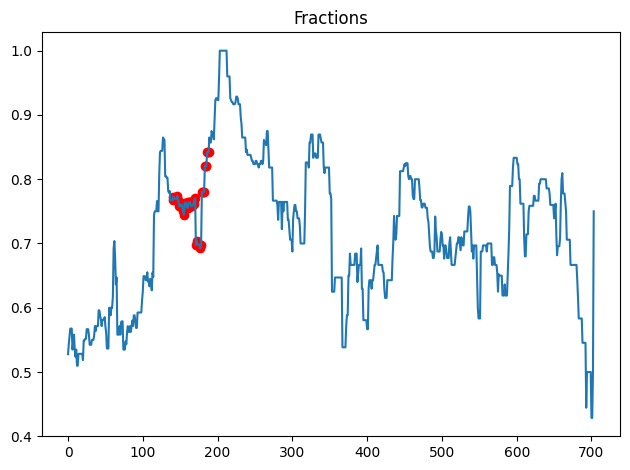

second cluster of negative mc results


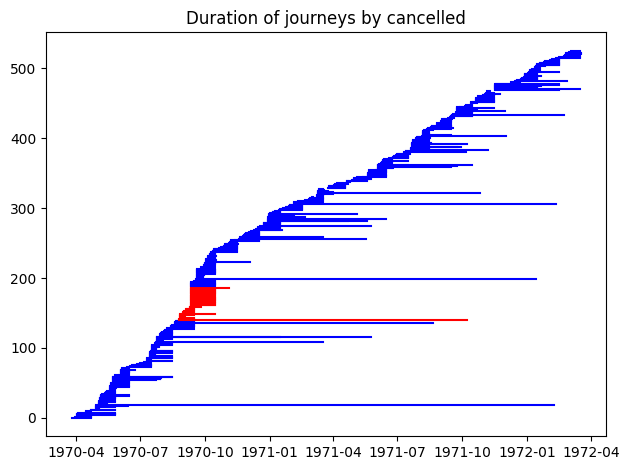

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
vpcAssignInstance after TaskEvent1 [(140, 189), (499, 548)]
not contained 479
not contained 480
not contained 481
not contained 482
not contained 483
True 202
not contained 0
Not same actions 502
False []
waitingForResultApproval - waitingForActivityReport point to finished [(0, 202)]


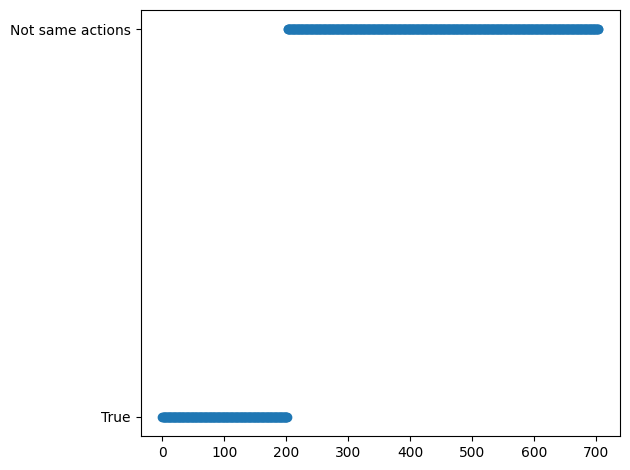

In [97]:
# analyse models without MC
not_computed_indices = [i for i in range(len(result_dict_sequence['mc_results'])) if result_dict_sequence['mc_results'][i] == [-1,-1,-1,-1,-1,-1]]

uncomputed_ranges = list(detect_range(not_computed_indices))
print("not computed are", uncomputed_ranges)

plt.plot(range(len(result_dict_sequence['sliced_logs'])), [len(l) for l in result_dict_sequence["sliced_logs"]])
plt.scatter(not_computed_indices, [[len(l) for l in result_dict_sequence["sliced_logs"]][i] for i in not_computed_indices], c = "r", marker = "x")
#plt.title("Number users")
plt.xlabel("Windows", size = 20)
plt.ylabel("Users", size = 20)
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/no_mc.png")
plt.show()

plt.plot(range(len(result_dict_sequence['fractions'])), result_dict_sequence["fractions"])
plt.scatter(not_computed_indices, [result_dict_sequence["fractions"][i] for i in not_computed_indices], c = "r")
plt.title("Fractions")
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/no_mc_fractions.png")
plt.show()

print("second cluster of negative mc results")

count = 0
for i in range(len(sorted_times)):
    t = sorted_times[i]
    plt.plot([t[1][0],t[1][1]], [count, count], c="red" if i in not_computed_indices else "b")
    count += 1
plt.title("Duration of journeys by cancelled")
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/no_mc_journeys.png")
plt.show()


for index in range(78, 134):
    l = result_dict_sequence["sliced_logs"][index]
    contained = False
    for trace in l:
        for pos in range(len(trace)-1):
            if trace[pos] == "Task event: 1" and trace[pos+1] == "vpcAssignInstance":
                contained = True
                

    
is_contained = []
for index in range(len(result_dict_sequence["sliced_logs"])):
    l = result_dict_sequence["sliced_logs"][index]
    contained = "False"
    containments = 0
    for trace in l:
        for pos in range(len(trace)-1):
            if trace[pos] == "Task event: 1" and trace[pos+1] == "vpcAssignInstance":
                contained = "True"
                containments += 1
    is_contained.append(contained)
    if containments != 0:
        print(containments)

#print([i for i in range(len(is_contained)) if is_contained[i] == "True"])
print("vpcAssignInstance after TaskEvent1", list(detect_range([i for i in range(len(is_contained)) if is_contained[i] == "True"])))
#generate_gif([result_dict_sequence["images"][i] for i in range(uncomputed_ranges[0][0], uncomputed_ranges[0][1])])

for index in range(479, 484):
    l = result_dict_sequence["sliced_logs"][index]
    help_g, edge_mapping = transition_system(l, 2, sequence)
    extend_graph_with_actors(help_g, actors, transition_system=True)
    next = sorted([e for e in help_g["waitingForScores - waitingForResultApproval"]])
    contained = False
    if next == sorted(['waitingForResultApproval - waitingForSubjectAcceptance', 'waitingForResultApproval - waitingForActivityReport']):
        contained = True
    if not contained:
        print("not contained", index)

is_contained = []
for index in range(len(result_dict_sequence["sliced_logs"])):
    l = result_dict_sequence["sliced_logs"][index]
    help_g, edge_mapping = transition_system(l, 2, sequence)
    extend_graph_with_actors(help_g, actors, transition_system=True)
    next = sorted([e for e in help_g["waitingForScores - waitingForResultApproval"]])
    if next == sorted(['waitingForResultApproval - waitingForSubjectAcceptance', 'waitingForResultApproval - waitingForActivityReport']):
        if "waitingForResultApproval - waitingForActivityReport" not in help_g:
            contained = "not contained"
        else:
            next1 = sorted([e for e in help_g["waitingForResultApproval - waitingForActivityReport"]])
            contained = "False"
            if 'waitingForActivityReport - finished' in next1:
                contained = "True"
    else:
        contained = "Not same actions"
    is_contained.append(contained)

plt.scatter(range(len(result_dict_sequence["sliced_logs"])), is_contained)
print("True", len([i for i in range(len(is_contained)) if is_contained[i] == "True"]))
print("not contained", len([i for i in range(len(is_contained)) if is_contained[i] == "not contained"]))
print("Not same actions", len([i for i in range(len(is_contained)) if is_contained[i] == "Not same actions"]))
print("False", [i for i in range(len(is_contained)) if is_contained[i] == "False"])
print("waitingForResultApproval - waitingForActivityReport point to finished", list(detect_range([i for i in range(len(is_contained)) if is_contained[i] == "True"])))

## Analyse negative edges - which part of journey

In [61]:
# parse uppaal output

def steps_to_phase(nodes):
    with open("/home/paul/Documents/User-Journey-Games/auto_sim.q", 'w+') as outfile:
        outfile.write("strategy goPos = control: A<> reached_positive\n")
        outfile.write("strategy goPosFast = minE(steps) [t<=100] : <> reached_positive under goPos\n")
        outfile.write("simulate 10 [# <= 100] {")
        outfile.write(("+".join(["Journey."+s.replace(" ","").replace(".","").replace(":", "").replace("-", "") for s in nodes])))
        #outfile.write(", gas} under goPosFast")
        outfile.write("} under goPosFast")

    out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.xml", "/home/paul/Documents/User-Journey-Games/auto_sim.q", "-s"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
    out.wait()
    results, err = out.communicate()
    results = results.decode("utf-8")
    err = err.decode("utf-8") 
    if err != "" and err != "Please restart UPPAAL with Internet.\n":
        results = [-1,-1,-1,-1,-1,-1]
        min_gas_index = -1
        
    else:
        results = results.split("\n")

        query = (" + ".join(["Journey."+s.replace(" ","").replace(".","").replace(":", "").replace("-", "") for s in nodes]))+":"
        # parse gas simulation values
        gas_index = [i for i in range(len(results)) if results[i] == query] # one by one
        assert(len(gas_index) == 1)
        gas_index = gas_index[0]
        gas = results[gas_index+1:-1]
        gas = [g.split("]: ")[1] for g in gas]
        gas = list(set(gas))
        min_gas_index = []
        for i in range(len(gas)): # for each execution
            current_gas = gas[i].split(" ")
            current_gas = [(float(g.split(",")[0][1:]),float(g.split(",")[1][:-1])) for g in current_gas]

            min_index = np.argmax([g[1] for g in current_gas])+1
            min_gas_index.append(current_gas[min_index][0])
            
        min_gas_index = sum(min_gas_index)/len(min_gas_index)
    
    return min_gas_index


In [62]:
import statistics
def negative_edge_occurences(logs):
    minimum_steps = []
    gas_simulation = []
    phases = []
    for l in logs:
        if len(l) == 0:
            minimum_steps.append(-10)
            gas_simulation.append([])
            phases.append("none")
            continue
        gas_parsed = []

        help_g, edge_mapping = transition_system(l, 2, sequence)
        extend_graph_with_actors(help_g,actors, transition_system=True)
        help_edge_cost = compute_edge_cost(help_g, l, edge_mapping)
        help_g = annotate_graph(help_g, help_edge_cost)
        help_g_outgoing = color_graph(help_g)

        target = [s for s in help_g.nodes if "finPos" in s or "finNeg" in s]
        help_g_unroll = unroll(help_g, "start", target, 1)

        to_uppaal_transition(help_g_unroll, "unrolled_graph_transition.xml", layout = "dot")

        out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.xml", "/home/paul/Documents/User-Journey-Games/simulation.q", "-s"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
        out.wait()
        results, err = out.communicate()
        results = results.decode("utf-8") 
        err = err.decode("utf-8") 
        if err != "" and err != "Please restart UPPAAL with Internet.\n":
            results = [-1,-1,-1,-1,-1,-1]
            min_gas_index = -1
            phases.append("none")
        else:
            results = results.split("\n")
            # parse gas simulation values
            gas_index = [i for i in range(len(results)) if results[i] == "gas:"]
            assert(len(gas_index) == 1)
            gas_index = gas_index[0]
            gas = results[gas_index+1:-1]
            gas = [g.split("]: ")[1] for g in gas]
            gas = list(set(gas))
            min_gas_index = []
            for i in range(len(gas)): # for each execution
                current_gas = gas[i].split(" ")
                current_gas = [(float(g.split(",")[0][1:]),float(g.split(",")[1][:-1])) for g in current_gas]
                gas_parsed.append(current_gas)
                min_index = np.argmin([g[1] for g in current_gas])+1

                min_gas_index.append(current_gas[min_index][0])

            min_gas_index = statistics.median(min_gas_index)#/len(min_gas_index))

            end_start_nodes = [s for s in help_g_unroll.nodes if "started - Task event: 0" in s]
            end_work = [e[1] for e in help_g_unroll.edges if "waitingForResultApproval" in e[1]]
            start_phase = steps_to_phase(end_start_nodes)
            work_phase = steps_to_phase(end_work)

            if min_gas_index < start_phase:
                phases.append("start")
            elif min_gas_index < work_phase:
                phases.append("work")
            else:
                phases.append("submit")
                
        minimum_steps.append(min_gas_index)
        gas_simulation.append(gas_parsed)
    return minimum_steps, gas_simulation, phases

In [63]:
minimum_steps, gas_simulation, phases = negative_edge_occurences(sliced_logs)

Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was u

693 23.5


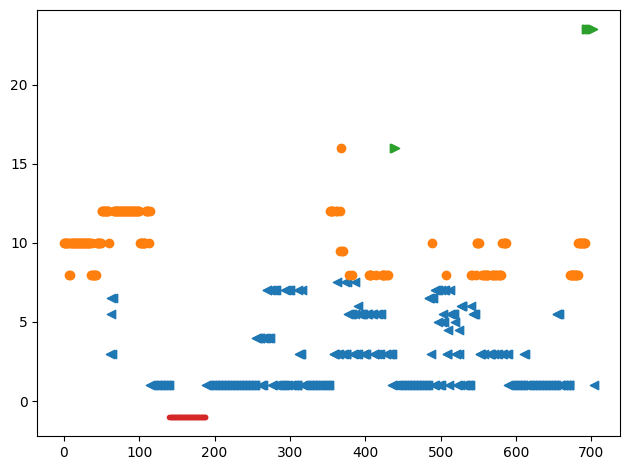

In [64]:
phase_markers = ["<" if c == "start" else "o" if c == "work" else ">" if c == "submit" else "." for c in phases]

x = np.array(range(len(minimum_steps)))

for m in ["<","o",">", "."]:
    x_index = [i for i in x if phase_markers[i] == m]
    plt.scatter(x_index, np.array(minimum_steps)[x_index], marker = m)
print(np.argmax(minimum_steps), minimum_steps[np.argmax(minimum_steps)])
plt.show()

[[(0.0, 0.0), (1.0, 0.0), (1.0, -22.0), (2.0, -22.0), (2.0, -44.0), (3.0, -44.0), (3.0, -46.0), (4.0, -46.0), (4.0, -48.0), (5.0, -48.0), (5.0, -50.0), (6.0, -50.0), (6.0, -52.0), (7.0, -52.0), (7.0, -54.0), (8.0, -54.0), (8.0, -55.0), (9.0, -55.0), (9.0, -56.0), (10.0, -56.0), (10.0, -55.0), (11.0, -55.0), (11.0, -54.0), (12.0, -54.0), (12.0, -49.0), (13.0, -49.0), (13.0, -44.0), (14.0, -44.0), (14.0, -41.0), (15.0, -41.0), (15.0, -39.0), (16.0, -39.0), (16.0, -38.0), (17.0, -38.0), (17.0, -31.0), (18.0, -31.0), (18.0, -13.0), (19.0, -13.0), (19.0, 5.0)]]


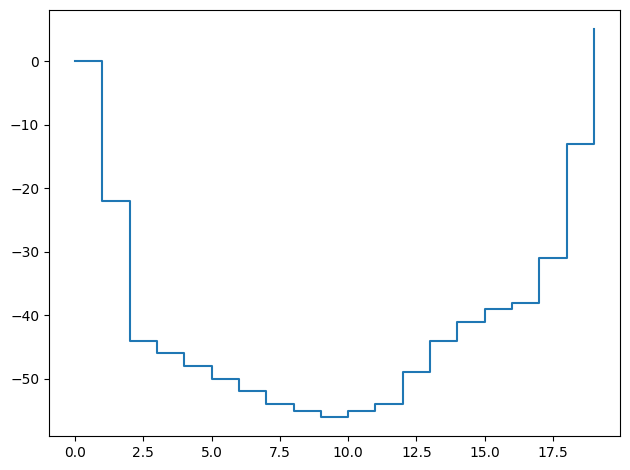

In [65]:
def plot_simulation(simulation_results):
    print(simulation_results)
    for run in simulation_results:
        x = [s[0] for s in run]
        y = [s[1] for s in run]
        plt.plot(x,y)
        
    plt.show()
plot_simulation(gas_simulation[0])

## Edge cost development analysis

# Analyse by company

In [66]:
# most prominent companies
reduced_sorted_times = [t for t in sorted_times if (t[1][1]- t[1][0]).days < MAX_DURATION_JOURNEY]
company_counts = {}
for t in reduced_sorted_times:
    company_index = company_iterator[companies[t[0]]]
    if company_index not in company_counts:
        company_counts[company_index] = 1
    else:
        company_counts[company_index] += 1
for c in company_counts:
    if company_counts[c] >= 10:
        print(c, company_counts[c], company_counts[c]/sum([company_counts[h] for h in company_counts]))

print("users total", len(reduced_sorted_times))

8 260 0.5029013539651838
6 96 0.18568665377176016
4 46 0.08897485493230174
12 15 0.029013539651837523
17 14 0.027079303675048357
7 17 0.03288201160541586
10 34 0.06576402321083172
users total 517


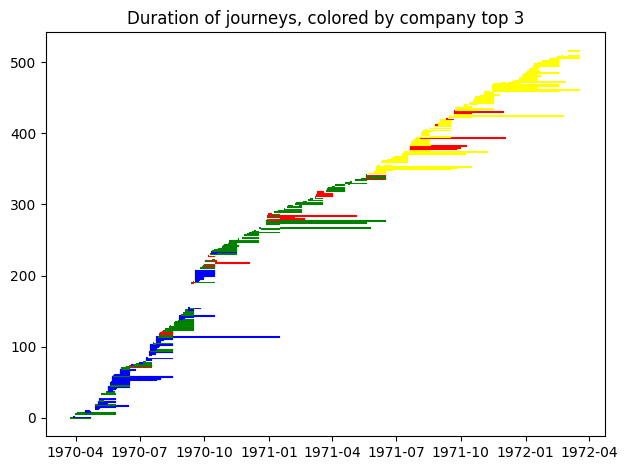

In [67]:
# top 3 companies
count = 0

company_8_counter = 0
for t in reduced_sorted_times:
    # 3 companies represent 80% of users
    company_it = company_iterator[companies[t[0]]]
    if company_it == 4:
        color = "red"
    elif company_it == 6:
        color = "blue"
    elif company_it == 8:
        if company_8_counter <= 120:
            color = "green"
        else: 
            color = "yellow"
        company_8_counter += 1
    else:
        color = "white"
    plt.plot([t[1][0],t[1][1]], [count, count], c=color)
    count += 1
plt.title("Duration of journeys, colored by company top 3")
plt.show()


In [68]:
def log_by_company(log, sorted_times, company_id):
    new_log = []
    assert(len(log)) == len(sorted_times)
    for i in range(len(log)):
        trace = log[i]
        time = sorted_times[i]
        company_it = company_iterator[companies[time[0]]]
        if company_it == company_id:
            new_log.append(trace)
    return new_log
log_4 = log_by_company(log, reduced_sorted_times, 4)
log_6 = log_by_company(log, reduced_sorted_times, 6)
log_8 = log_by_company(log, reduced_sorted_times, 8)
log_8_1 = log_8[:120]
log_8_2 = log_8[120:]

In [69]:
"""
def sequence_game_sampling(log, edge_threshold, company_id, plot = False):
    g, edge_mapping =  transition_system(log, 2, sequence)
    extend_graph_with_actors(g,actors, transition_system=True)
    edge_cost = compute_edge_cost(g, log, edge_mapping)
    g = annotate_graph(g, edge_cost)
    edge_to_remove = []
    for e in g.edges:
        if len(edge_mapping[e]) <= edge_threshold:
            edge_to_remove.append(e)
    g.remove_edges_from(edge_to_remove)
    g.remove_nodes_from(list(nx.isolates(g)))

    nodes_to_remove = []
    for n in g.nodes:
        if "finPos" in n or "finNeg" in n:
            continue
        desc = nx.descendants(g,n)
        pos_desc = set(["finPos" in n for n in desc])
        neg_desc = set(["finNeg" in n for n in desc])
        if (True not in pos_desc and True not in neg_desc) or not desc:
            print("removed", n)
            nodes_to_remove.append(n)
    g.remove_nodes_from(nodes_to_remove)

    if plot:
        draw_dfg(g, "graph_company"+str(company_id)+".png")

    target = [s for s in g.nodes if "finPos" in s or "finNeg" in s]
    g_unroll = unroll(g, "start", target, 1)
    to_uppaal_transition(g_unroll, "unrolled_graph_transition.xml", layout = "dot")

    out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
    out.wait()
    results, err = out.communicate()
    results = results.decode("utf-8") 
    err = err.decode("utf-8") 
    if err != "" and err != "Please restart UPPAAL with Internet.\n":
        results = [-1,-1,-1,-1,-1,-1]
    else:
        results = results.split("\n")
        results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
        results = [r.replace("≈", "") for r in results]
        results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
    assert(len(results) == 6)

    return results

def group(results):
    grouped_results = [ [] for i in range(len(results[0]))]
    for r in results:
        for i in range(len(r)):
            grouped_results[i].append(r[i])
    return grouped_results

sequence_game_sampling(log_4, 0, 4, plot = True)
sequence_game_sampling(log_6, 0, 6, plot = True)
sequence_game_sampling(log_8, 0, 8, plot = True)
sequence_game_sampling(log_8_1, 0, "8_1", plot = True)
sequence_game_sampling(log_8_2, 0, "8_2", plot = True)
print("Log4")
results = []
for i in range(10):
    running_log = random.sample(log_4, int(0.8*len(log_4)))
    results.append(sequence_game_sampling(running_log, 0, 4))
results = group(results)
print("mean", np.mean(results, axis = 1))
print("var", np.var(results, axis = 1))
print()
print("Log6")
results = []
for i in range(10):
    running_log = random.sample(log_6, int(0.8*len(log_6)))
    results.append(sequence_game_sampling(running_log, 0, 6))
results = group(results)
print("mean", np.mean(results, axis = 1))
print("var", np.var(results, axis = 1))
print()
print("Log8")
results = []
for i in range(10):
    running_log = random.sample(log_8, int(0.8*len(log_8)))
    results.append(sequence_game_sampling(running_log, 0, 8))
results = group(results)
print("mean", np.mean(results, axis = 1))
print("var", np.var(results, axis = 1))
print("Log8_1")
results = []
for i in range(10):
    running_log = random.sample(log_8_1, int(0.8*len(log_8_1)))
    results.append(sequence_game_sampling(running_log, 0, "8_1"))
results = group(results)
print("mean", np.mean(results, axis = 1))
print("var", np.var(results, axis = 1))
print("Log8_2")
results = []
for i in range(10):
    running_log = random.sample(log_8_2, int(0.8*len(log_8_2)))
    results.append(sequence_game_sampling(running_log, 0, "8_2"))
results = group(results)
print("mean", np.mean(results, axis = 1))
print("var", np.var(results, axis = 1))
print()
"""

'\ndef sequence_game_sampling(log, edge_threshold, company_id, plot = False):\n    g, edge_mapping =  transition_system(log, 2, sequence)\n    extend_graph_with_actors(g,actors, transition_system=True)\n    edge_cost = compute_edge_cost(g, log, edge_mapping)\n    g = annotate_graph(g, edge_cost)\n    edge_to_remove = []\n    for e in g.edges:\n        if len(edge_mapping[e]) <= edge_threshold:\n            edge_to_remove.append(e)\n    g.remove_edges_from(edge_to_remove)\n    g.remove_nodes_from(list(nx.isolates(g)))\n\n    nodes_to_remove = []\n    for n in g.nodes:\n        if "finPos" in n or "finNeg" in n:\n            continue\n        desc = nx.descendants(g,n)\n        pos_desc = set(["finPos" in n for n in desc])\n        neg_desc = set(["finNeg" in n for n in desc])\n        if (True not in pos_desc and True not in neg_desc) or not desc:\n            print("removed", n)\n            nodes_to_remove.append(n)\n    g.remove_nodes_from(nodes_to_remove)\n\n    if plot:\n        dr

In [70]:
def filter_by_company(sliced_logs, sliced_companies, company):
    filtered_logs = []
    for l, companies in zip(sliced_logs, sliced_companies):
        current_log = [l[i] for i in range(len(l)) if companies[i] == company]
        filtered_logs.append(current_log)
    return filtered_logs

sliced_log_8 = filter_by_company(sliced_logs, sliced_companies, 8)
sliced_log_6 = filter_by_company(sliced_logs, sliced_companies, 6)
sliced_log_4 = filter_by_company(sliced_logs, sliced_companies, 4)

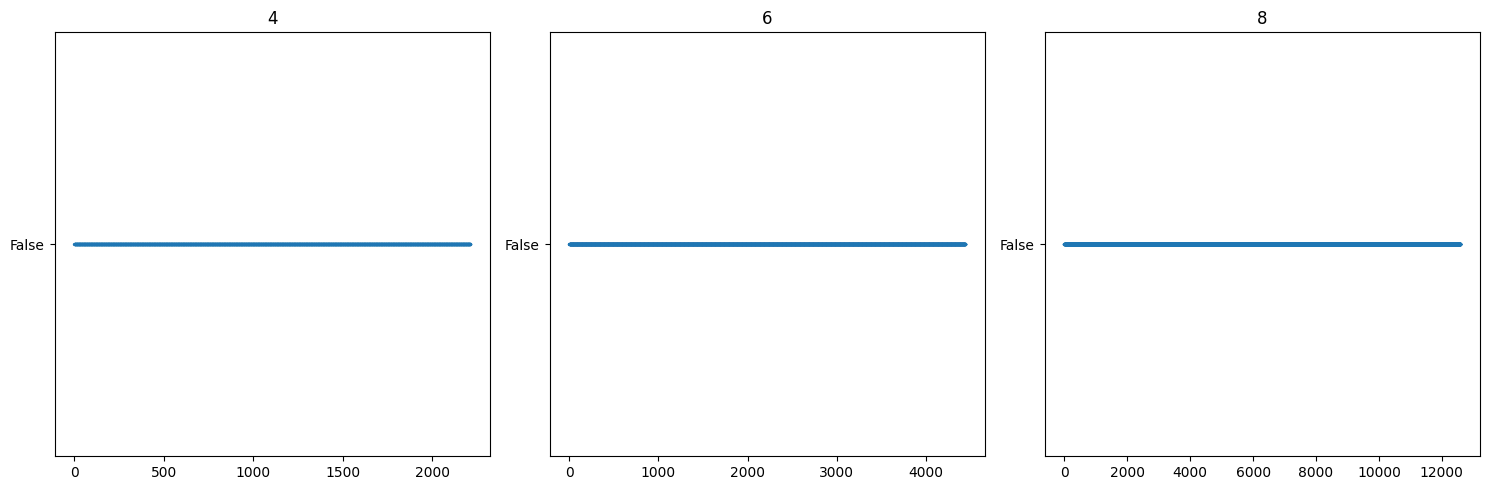

In [71]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

contained = []
for l in sliced_log_4:
    for t in l:
        if "Preliminary results updated for overall score:" in t:
            contained.append("True")
            break
        contained.append("False")
axs[0].scatter(range(len(contained)), contained, s = 2)
axs[0].set_title("4")


contained = []
for l in sliced_log_6:
    for t in l:
        if "Preliminary results updated for overall score:" in t:
            contained.append("True")
            break
        contained.append("False")
axs[1].scatter(range(len(contained)), contained, s = 2)
axs[1].set_title("6")

contained = []
for l in sliced_log_8:
    for t in l:
        if "Preliminary results updated for overall score:" in t:
            contained.append("True")
            break
        contained.append("False")
axs[2].scatter(range(len(contained)), contained, s = 2)
axs[2].set_title("8")

plt.show()

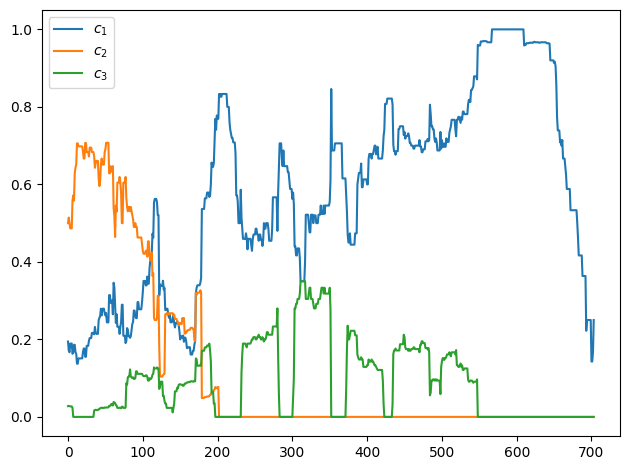

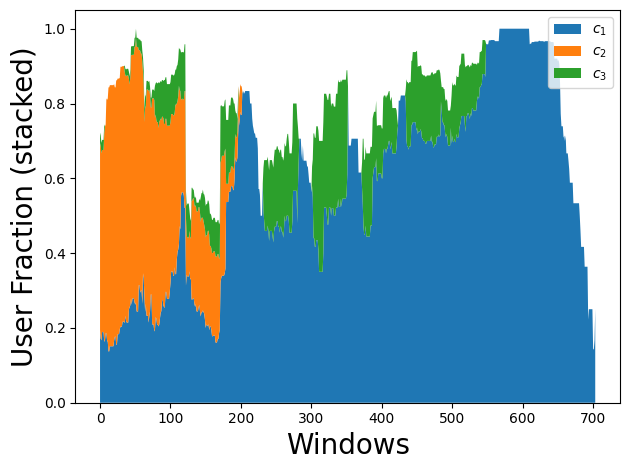

In [74]:
plt.plot(range(len(sliced_log_8)),[len(sliced_log_8[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))], label = r'$c_1$')
plt.plot(range(len(sliced_log_6)), [len(sliced_log_6[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))], label = r'$c_2$')
plt.plot(range(len(sliced_log_4)), [len(sliced_log_4[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))], label = r'$c_3$')
plt.legend()
plt.show()

d4 = [len(sliced_log_4[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))]
d6 = [len(sliced_log_6[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))]
d8 = [len(sliced_log_8[i])/len(sliced_logs[i]) for i in range(len(sliced_logs))]

y = np.vstack([d8, d6, d4])
labels = [r'$c_1$', r'$c_2$', r'$c_3$']
plt.stackplot(range(len(sliced_logs)), y, labels = labels)
plt.xlabel("Windows", size = 20)
plt.ylabel("User Fraction (stacked)", size = 20)
plt.legend()
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/company_ratios.png")
plt.show()

Edge cost was computed
Graph was unrolled
Progress 1 / 704
Edge cost was computed
Graph was unrolled
Progress 2 / 704
Edge cost was computed
Graph was unrolled
Progress 3 / 704
Edge cost was computed
Graph was unrolled
Progress 4 / 704
Edge cost was computed
Graph was unrolled
Progress 5 / 704
Edge cost was computed
Graph was unrolled
Progress 6 / 704
Edge cost was computed
Graph was unrolled
Progress 7 / 704
Edge cost was computed
Graph was unrolled
Progress 36 / 704
Edge cost was computed
Graph was unrolled
Progress 37 / 704
Edge cost was computed
Graph was unrolled
Progress 38 / 704
Edge cost was computed
Graph was unrolled
Progress 39 / 704
Edge cost was computed
Graph was unrolled
Progress 40 / 704
Edge cost was computed
Graph was unrolled
Progress 41 / 704
Edge cost was computed
Graph was unrolled
Progress 42 / 704
Edge cost was computed
Graph was unrolled
Progress 43 / 704
Edge cost was computed
Graph was unrolled
Progress 44 / 704
Edge cost was computed
Graph was unrolled
Progr

/tmp/ipykernel_135209/4105243223.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_135209/4105243223.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


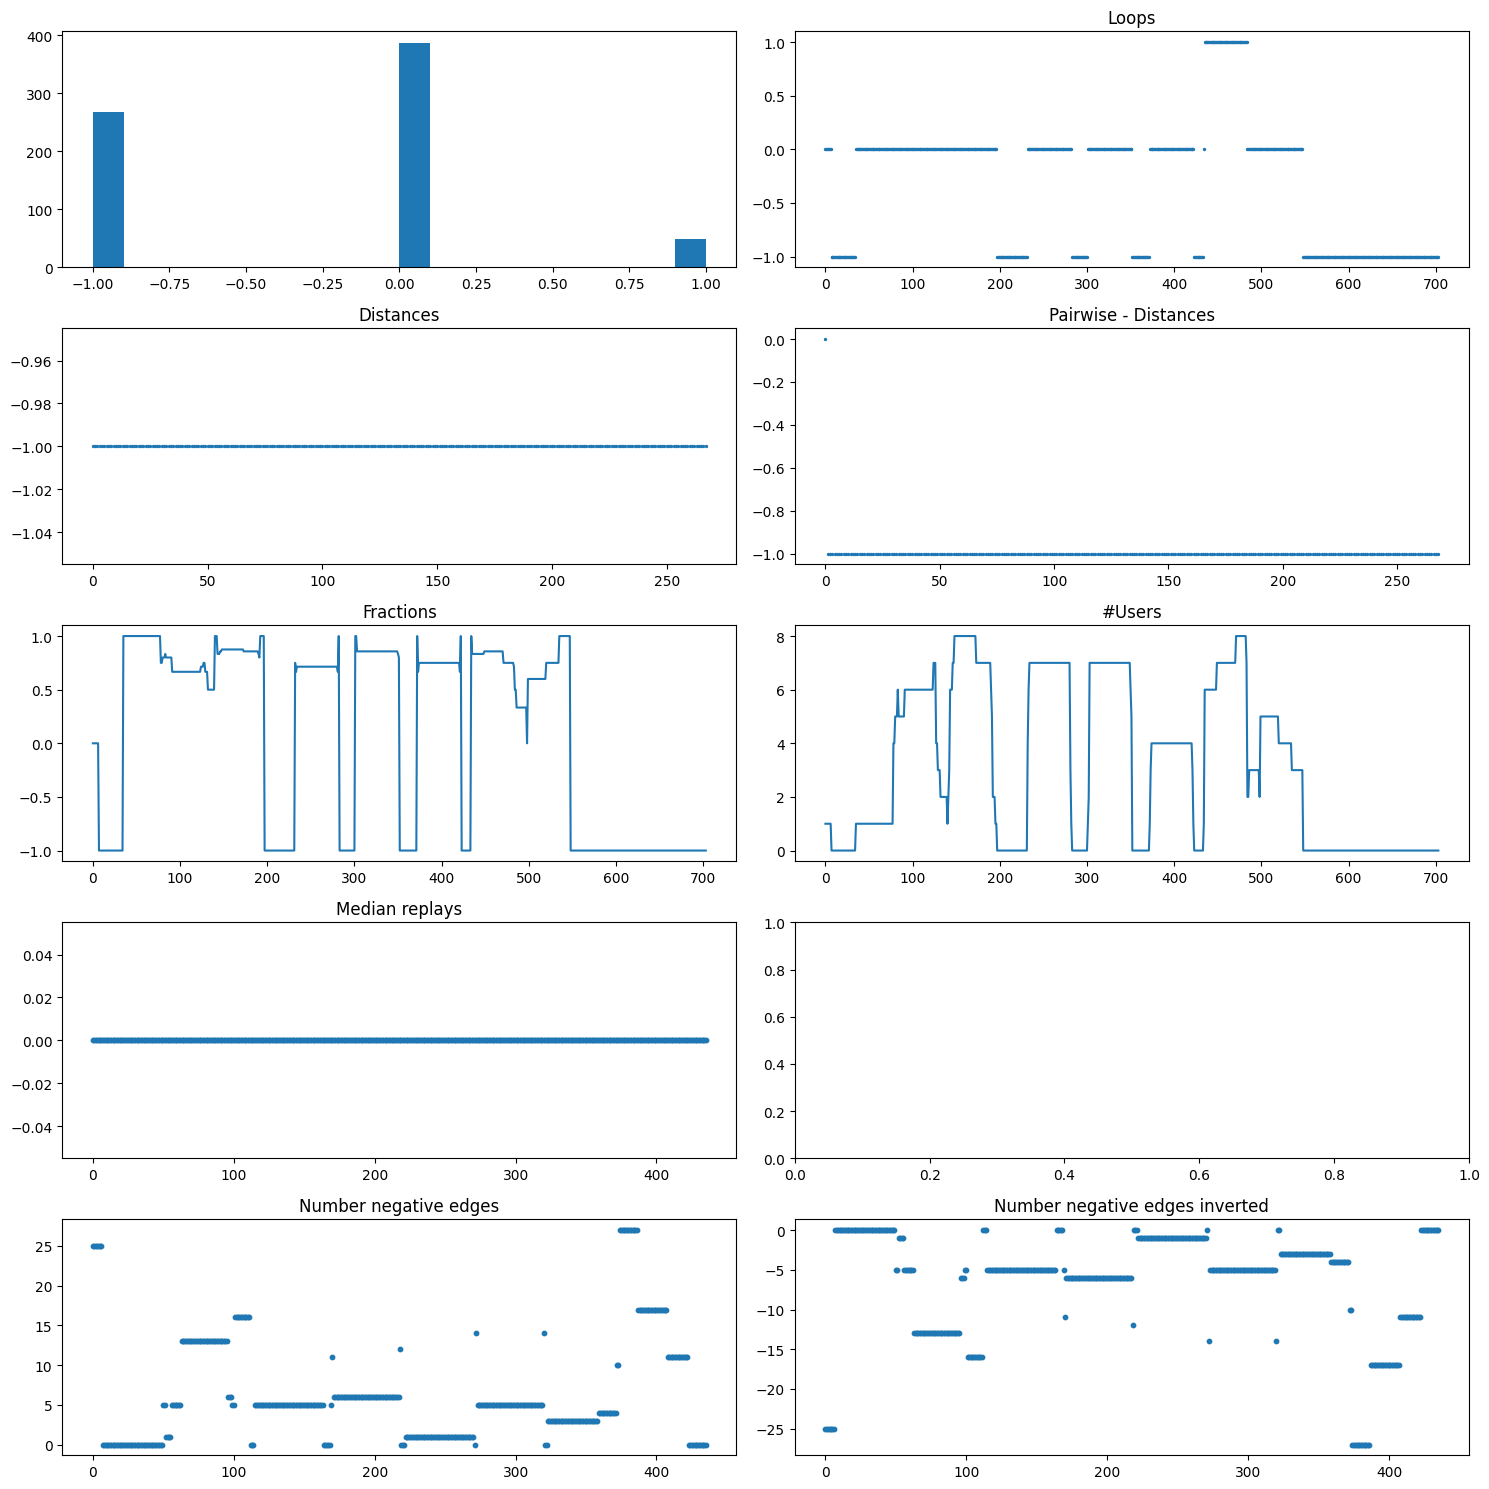

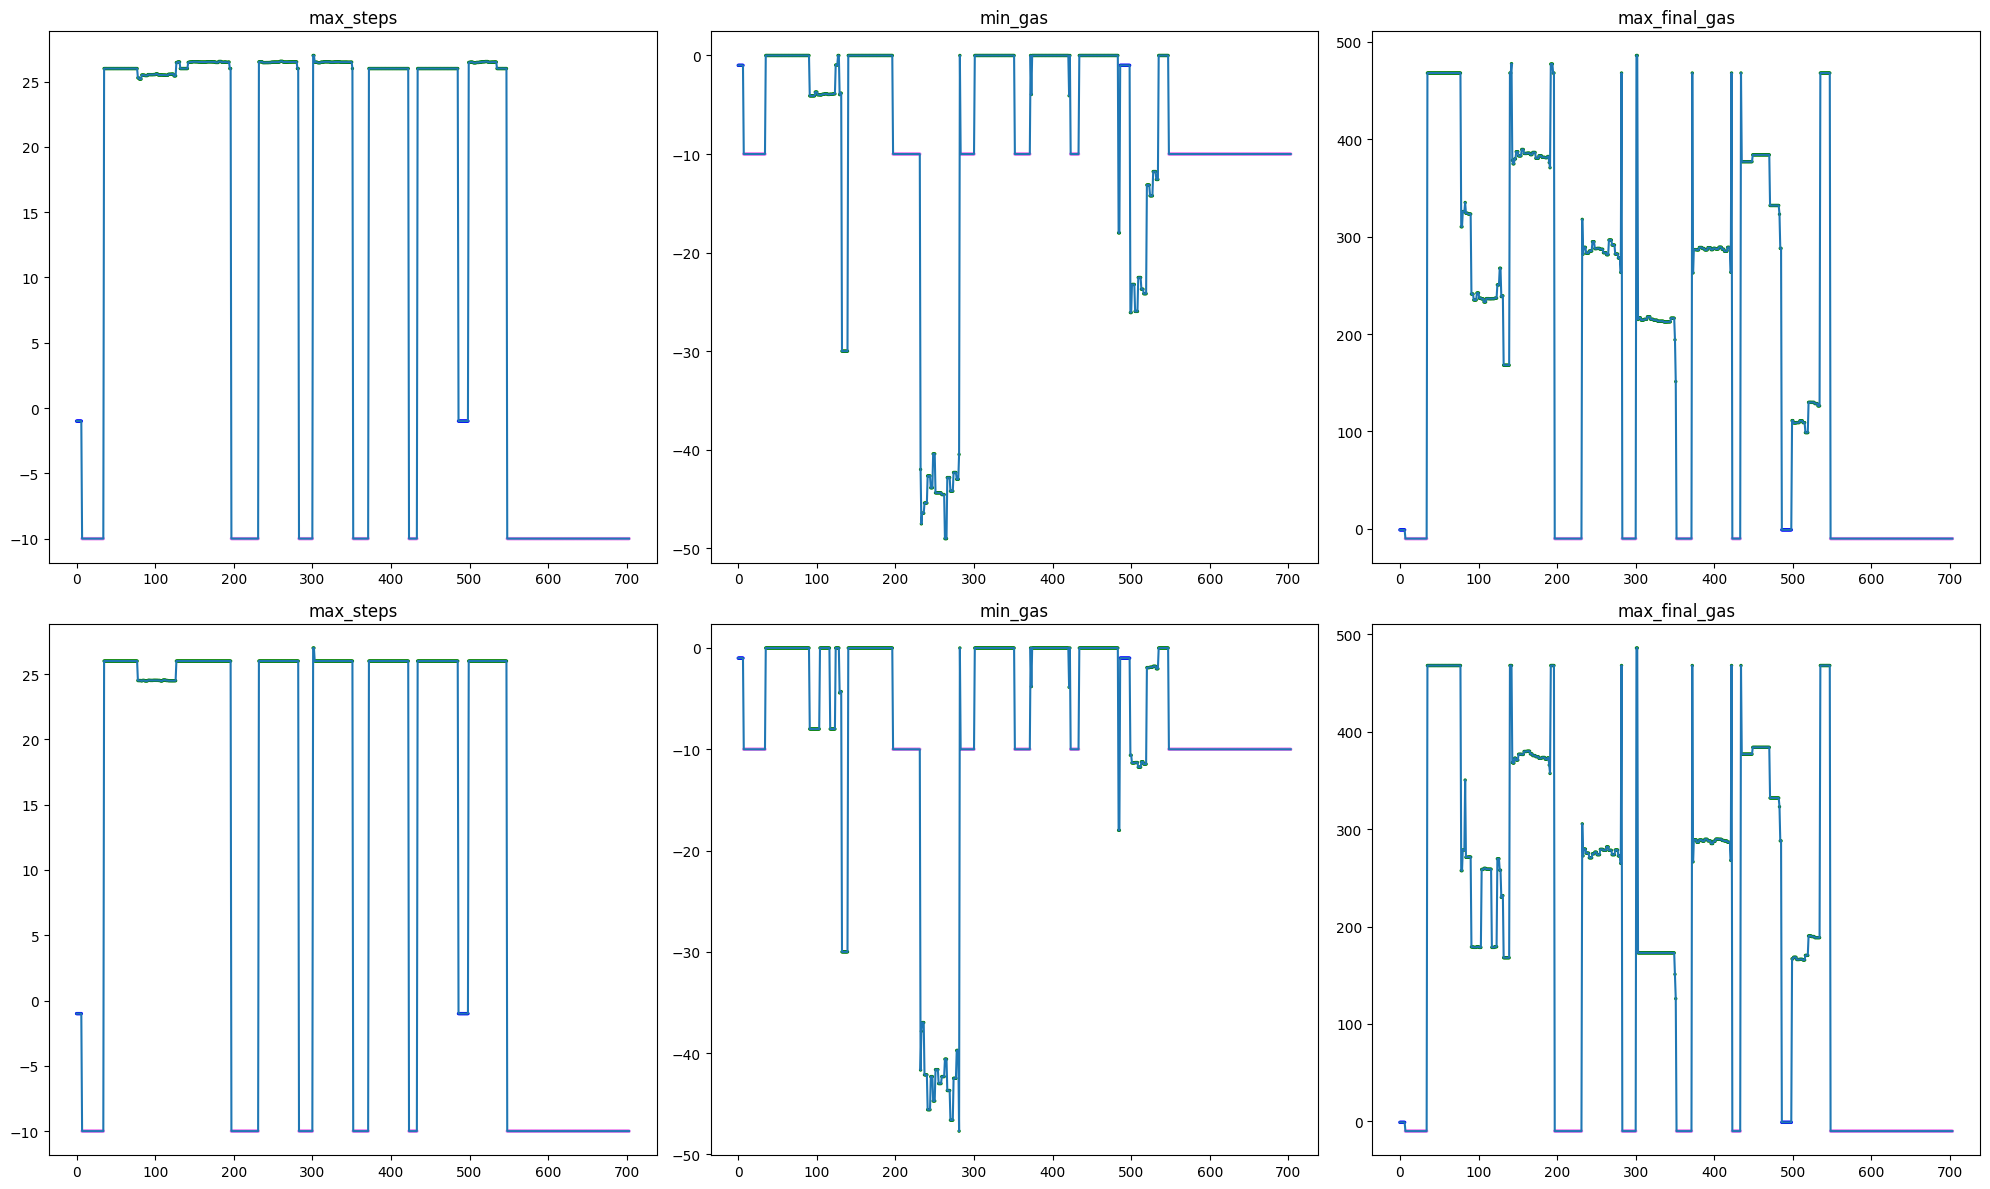

In [77]:
result_dict_help_4 = time_analysis(sliced_log_4, abstraction_length = 2, edge_threshold = 0, compute_distance=False)
plot_results(result_dict_help_4)
plot_mc_results(result_dict_help_4["mc_results"], result_dict_help_4["colors"])

Edge cost was computed
Graph was unrolled
Progress 1 / 704
Edge cost was computed
Graph was unrolled
Progress 2 / 704
Edge cost was computed
Graph was unrolled
Progress 3 / 704
Edge cost was computed
Graph was unrolled
Progress 4 / 704
Edge cost was computed
Graph was unrolled
Progress 5 / 704
Edge cost was computed
Graph was unrolled
Progress 6 / 704
Edge cost was computed
Graph was unrolled
Progress 7 / 704
Edge cost was computed
Graph was unrolled
Progress 8 / 704
Edge cost was computed
Graph was unrolled
Progress 9 / 704
Edge cost was computed
Graph was unrolled
Progress 10 / 704
Edge cost was computed
Graph was unrolled
Progress 11 / 704
Edge cost was computed
Graph was unrolled
Progress 12 / 704
Edge cost was computed
Graph was unrolled
Progress 13 / 704
Edge cost was computed
Graph was unrolled
Progress 14 / 704
Edge cost was computed
Graph was unrolled
Progress 15 / 704
Edge cost was computed
Graph was unrolled
Progress 16 / 704
Edge cost was computed
Graph was unrolled
Progres

/tmp/ipykernel_135209/4105243223.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_135209/4105243223.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


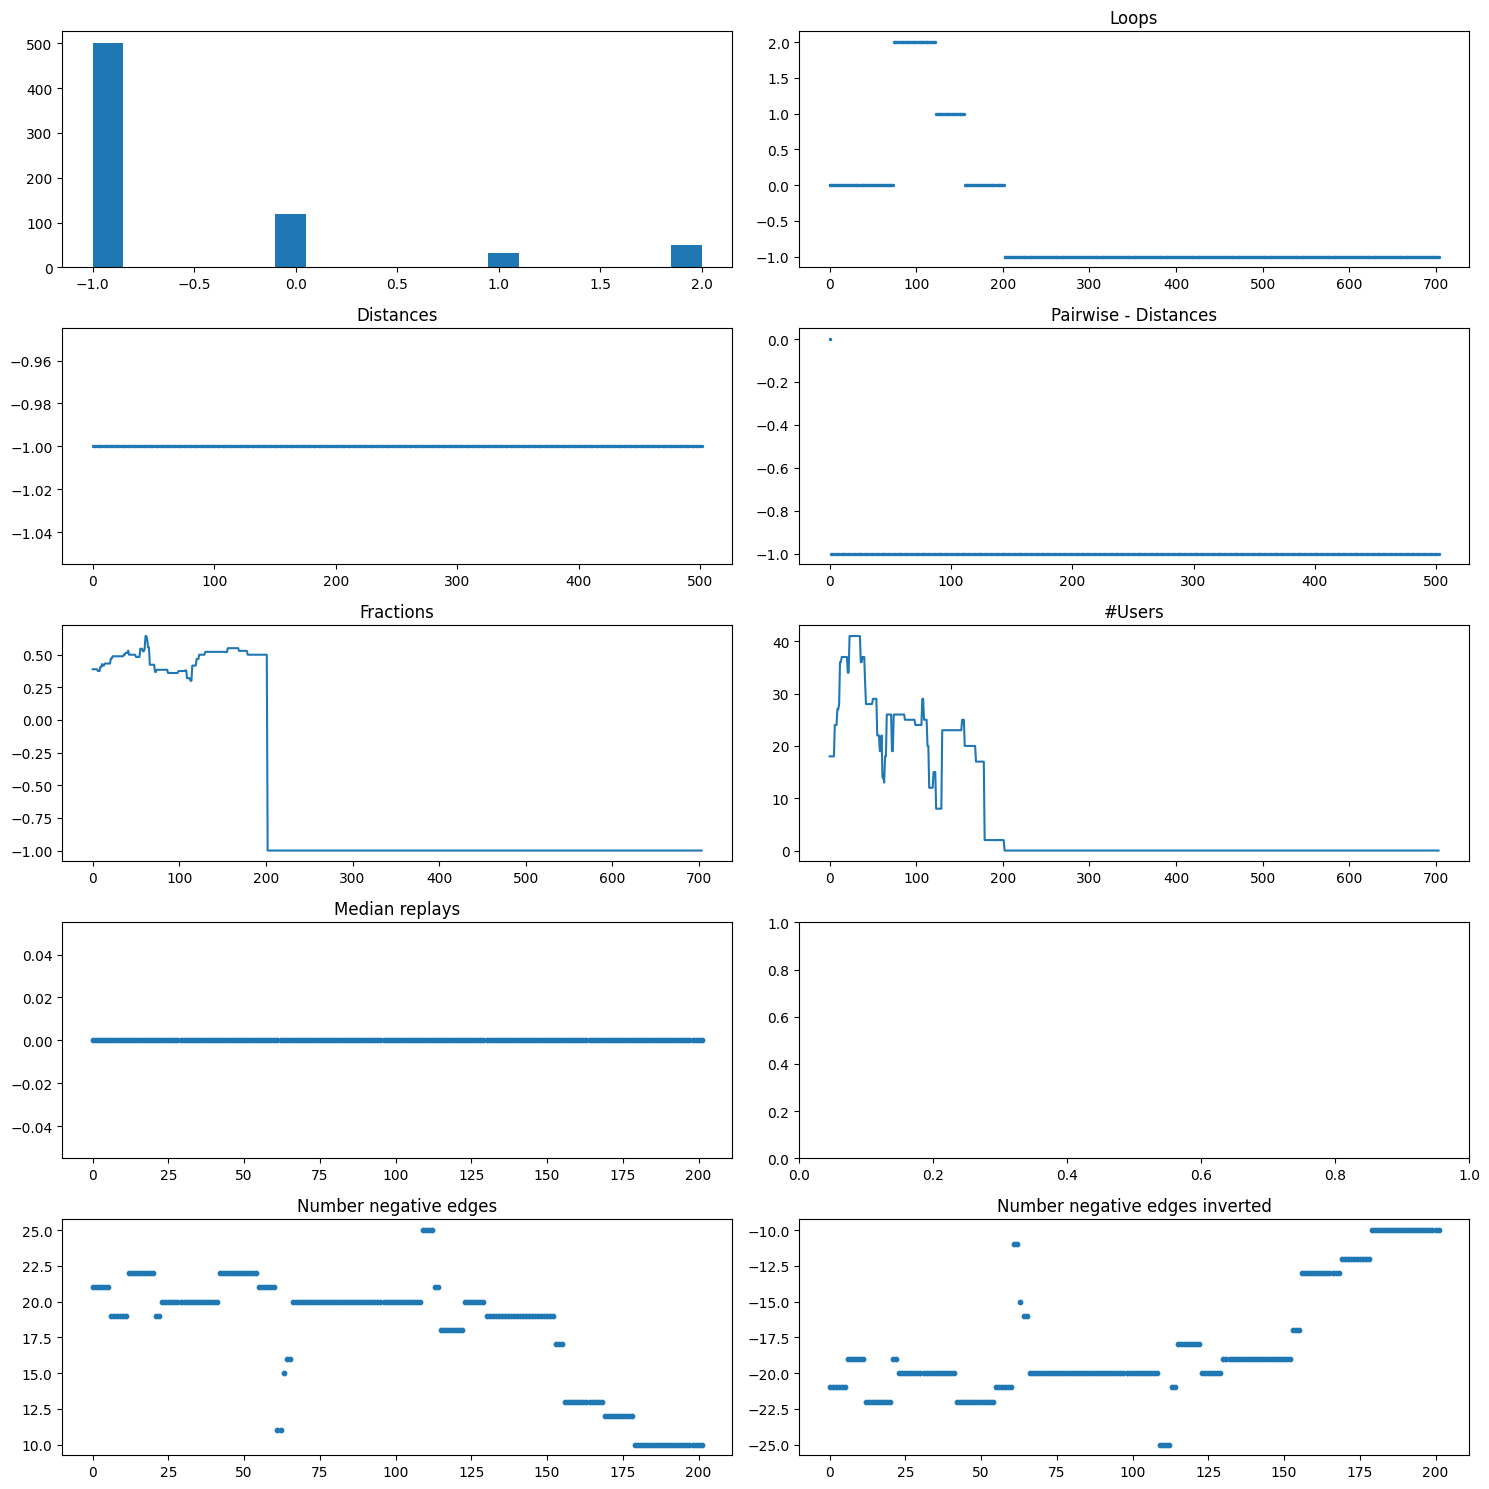

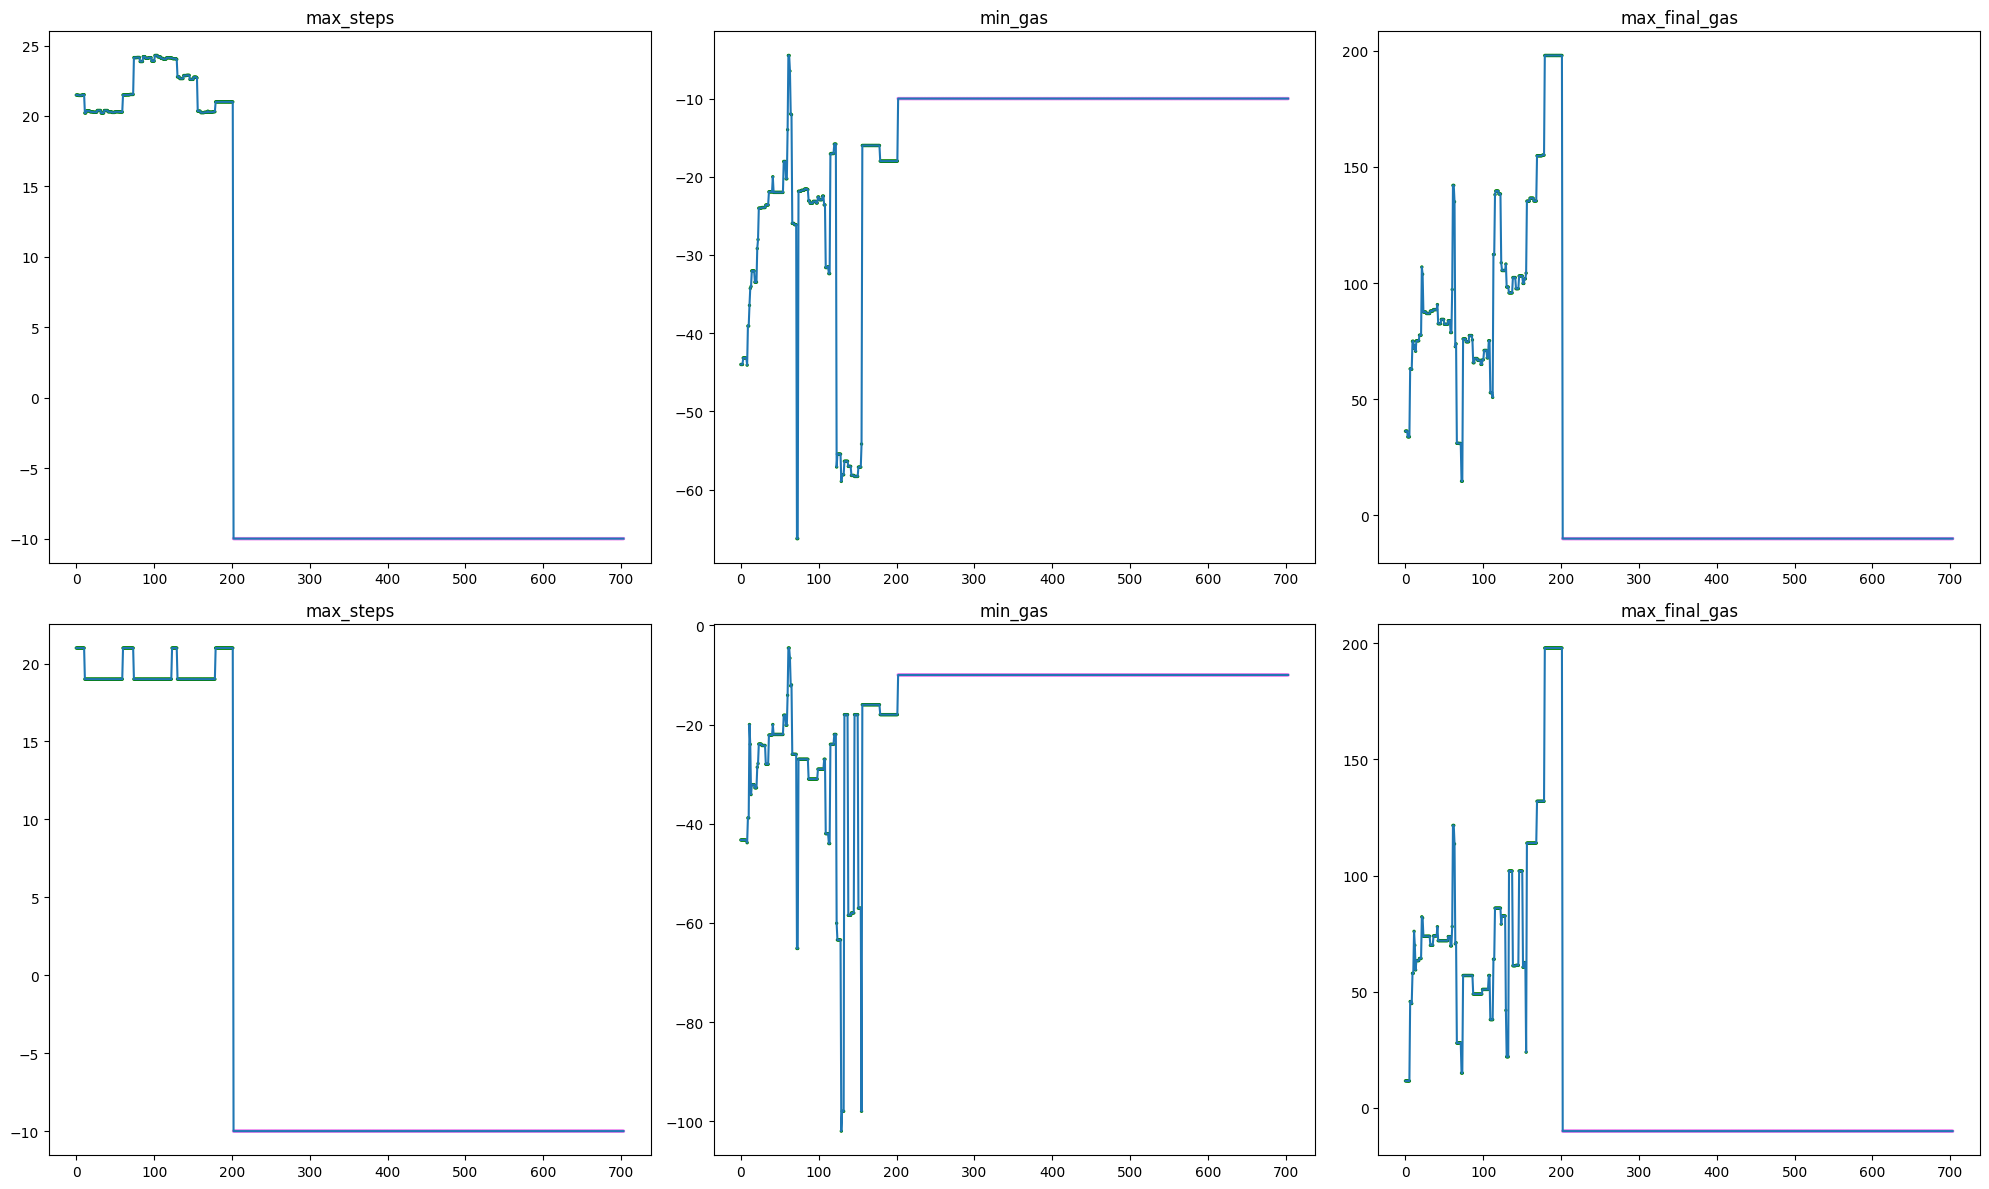

In [78]:
result_dict_help_6 = time_analysis(sliced_log_6, abstraction_length = 2, edge_threshold = 0, compute_distance=False)
plot_results(result_dict_help_6)
plot_mc_results(result_dict_help_6["mc_results"], result_dict_help_6["colors"])

In [79]:
minimum_steps_6, gas_simulation_6, phases_6 = negative_edge_occurences(sliced_log_6)

Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was u

0 14.0


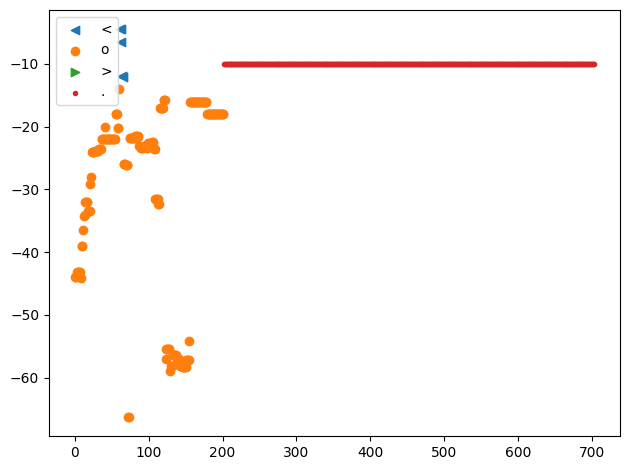

In [80]:
colors = []
for i in range(len(minimum_steps_6)):
    simulation_values = gas_simulation_6[i]

    """
    g = []
    for r in simulation_values:
        min_steps = list([s for s in r if s[0] == minimum_steps_6[i]])
        print(min_steps, minimum_steps_6[i])
        assert(len(min_steps) == 2)# or minimum_steps_6[i] == 0)
        if min([s[1] for s in r]) != min([s[1] for s in min_steps]):
            print(r, minimum_steps_6[i])
            print(simulation_values)
            print(min([s[1] for s in r]), min([s[1] for s in min_steps]))
        assert(min([s[1] for s in r]) == min([s[1] for s in min_steps]))
        g.append(min([s[1] for s in min_steps]))
    assert(len(g)==len(simulation_values))
    """

    g = [result_dict_help_6["mc_results"][i][4]]
    #g = [r[int(2*minimum_steps_6[i])][1] for r in simulation_values] # was halved before, two steps in log records
    if(len(g)==0):
        colors.append("b")
        continue
    g = sum(g)/len(g)
    if g >= 0:
        colors.append("green")
    elif g >= -10:
        colors.append("orange")
    elif g >= -30 :
        colors.append("red")
    else:
        colors.append("black")

phase_markers = ["<" if c == "start" else "o" if c == "work" else ">" if c == "submit" else "." for c in phases_6]
x = np.array(range(len(minimum_steps_6)))
for m in ["<","o",">", "."]:
    x_index = [i for i in x if phase_markers[i] == m]
    plt.scatter(x_index, np.array([r[1] for r in result_dict_help_6["mc_results"]])[x_index], marker = m, label = m)
    #plt.scatter(x_index, np.array(minimum_steps_6)[x_index], marker = m, c = np.array(colors)[x_index], s = 2)

#plt.scatter(range(len(minimum_steps_6)), minimum_steps_6, s = 2, c = colors)
#plt.plot(range(len(minimum_steps_6)), minimum_steps_6)
plt.legend()
print(np.argmax(minimum_steps_6), minimum_steps_6[np.argmax(minimum_steps_6)])
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/steps_6.png")
plt.show()

Edge cost was computed
Graph was unrolled
Progress 1 / 704
Edge cost was computed
Graph was unrolled
Progress 2 / 704
Edge cost was computed
Graph was unrolled
Progress 3 / 704
Edge cost was computed
Graph was unrolled
Progress 4 / 704
Edge cost was computed
Graph was unrolled
Progress 5 / 704
Edge cost was computed
Graph was unrolled
Progress 6 / 704
Edge cost was computed
Graph was unrolled
Progress 7 / 704
Edge cost was computed
Graph was unrolled
Progress 8 / 704
Edge cost was computed
Graph was unrolled
Progress 9 / 704
Edge cost was computed
Graph was unrolled
Progress 10 / 704
Edge cost was computed
Graph was unrolled
Progress 11 / 704
Edge cost was computed
Graph was unrolled
Progress 12 / 704
Edge cost was computed
Graph was unrolled
Progress 13 / 704
Edge cost was computed
Graph was unrolled
Progress 14 / 704
Edge cost was computed
Graph was unrolled
Progress 15 / 704
Edge cost was computed
Graph was unrolled
Progress 16 / 704
Edge cost was computed
Graph was unrolled
Progres

/tmp/ipykernel_135209/4105243223.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_135209/4105243223.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


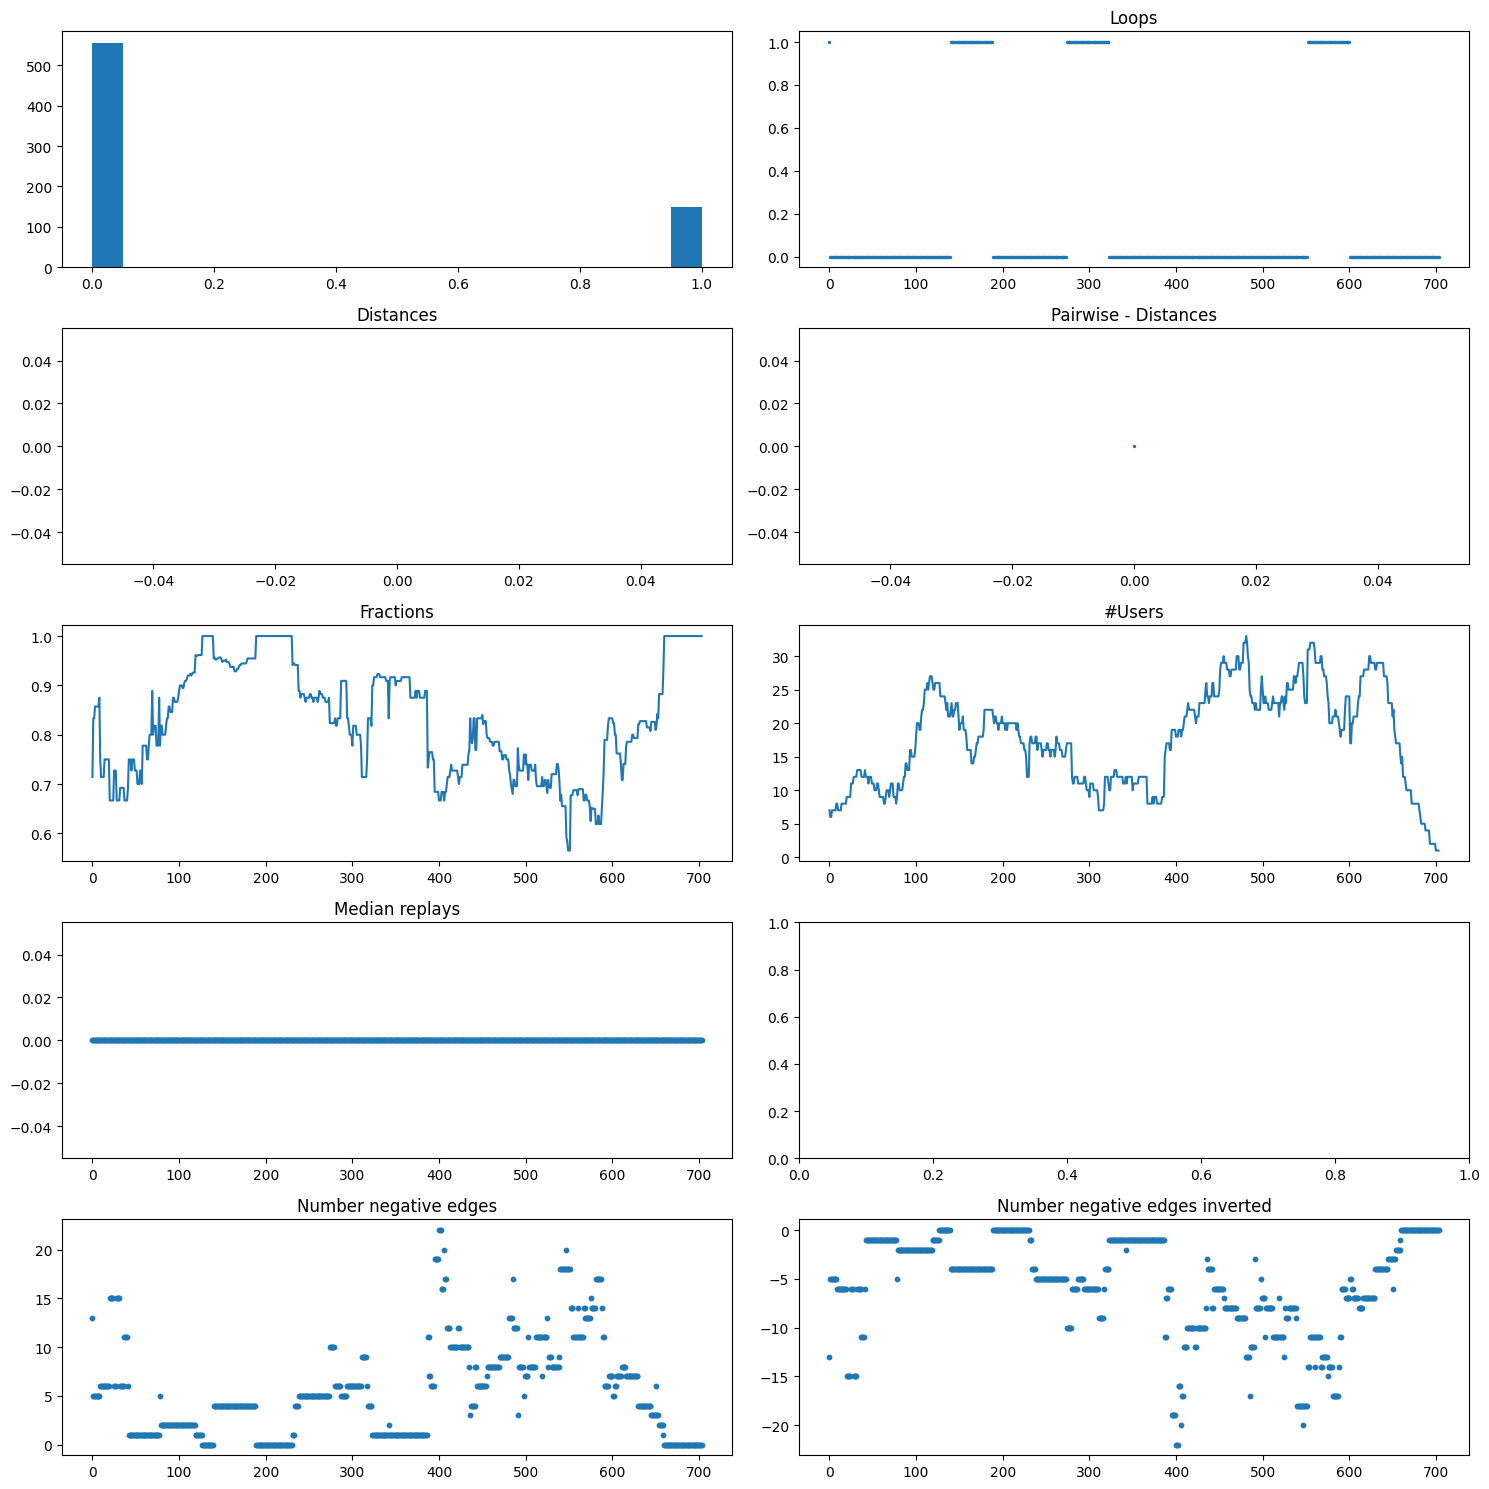

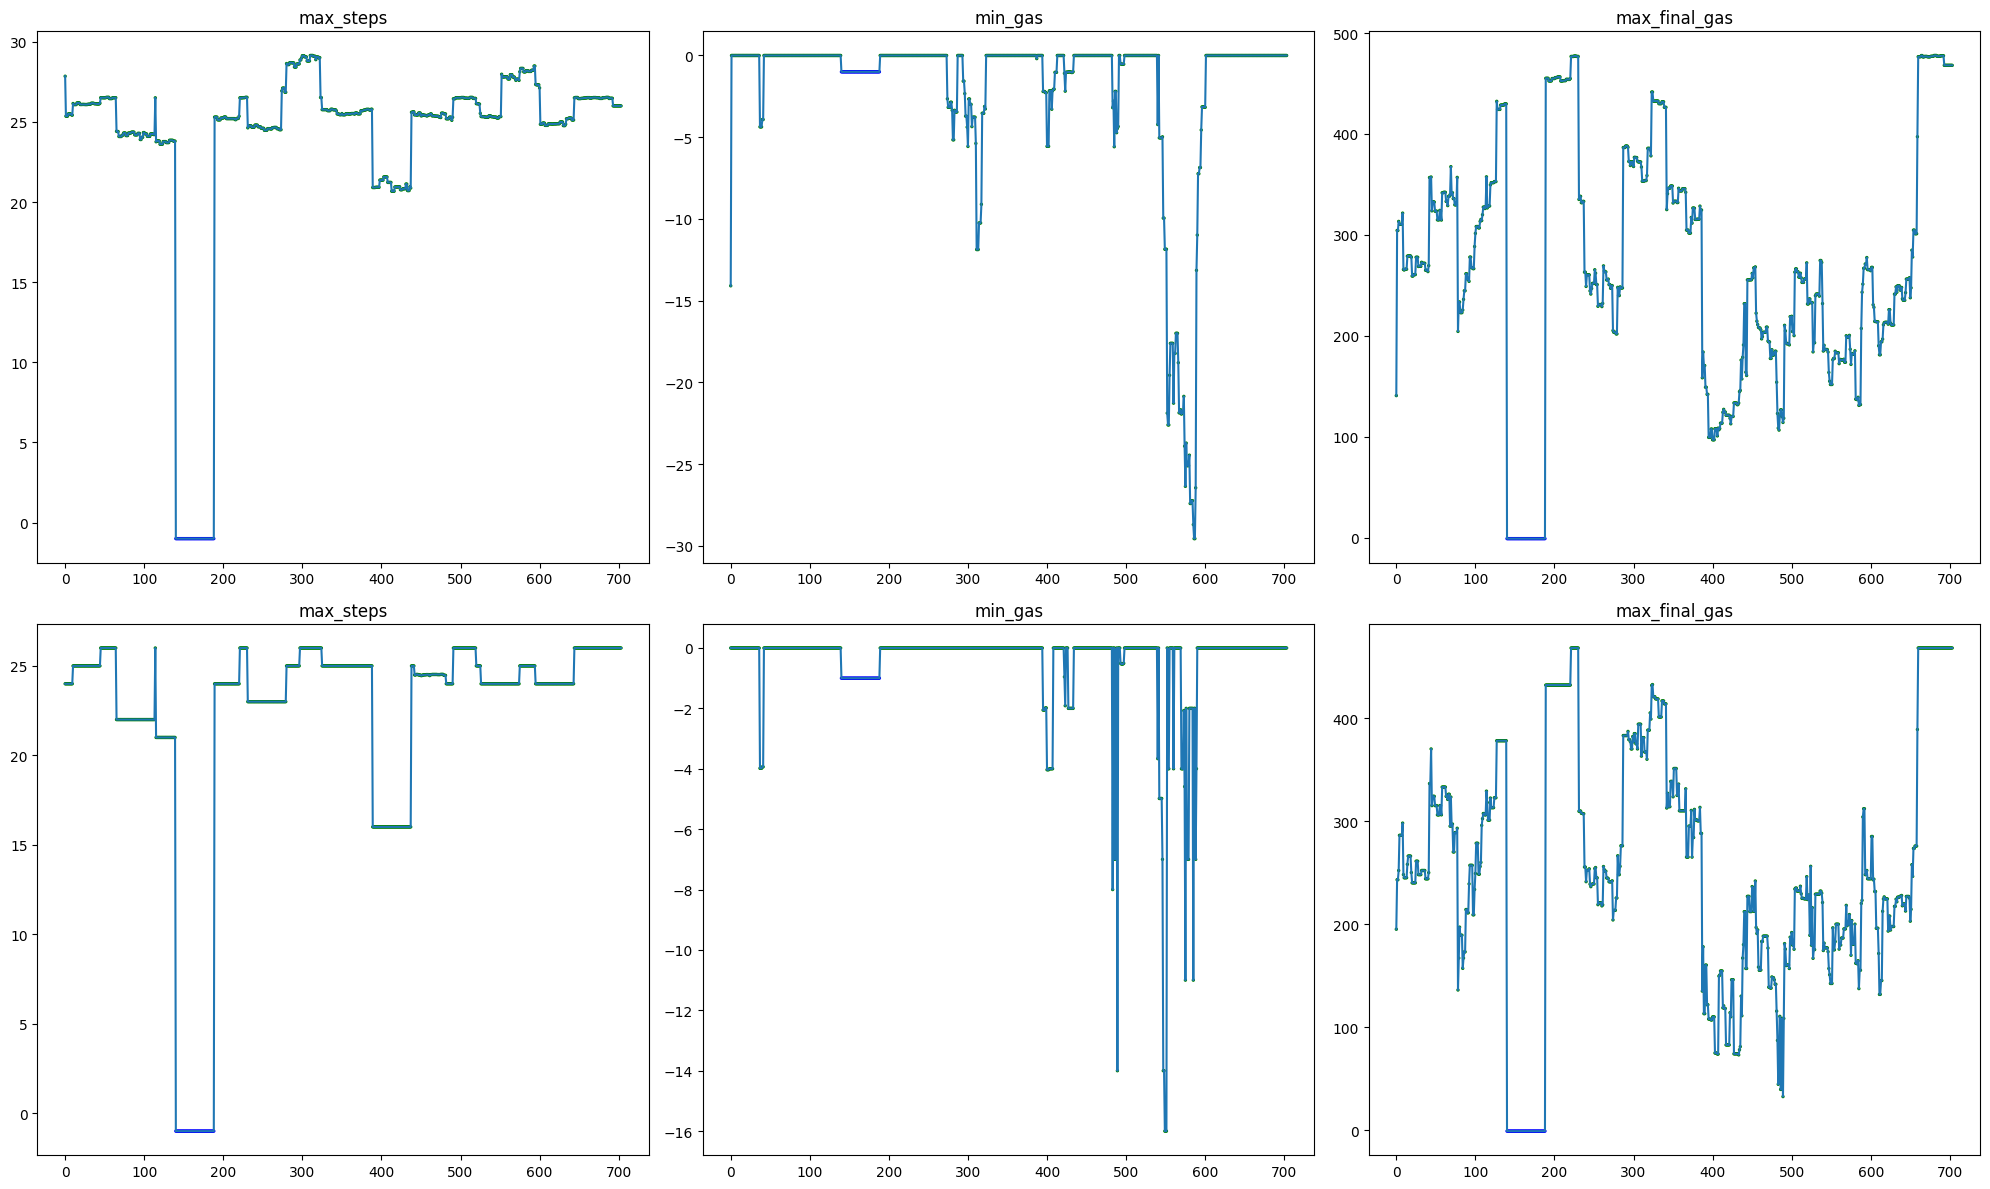

In [81]:
result_dict_help_8 = time_analysis(sliced_log_8, abstraction_length = 2, edge_threshold = 0, compute_distance=False)
plot_results(result_dict_help_8)
plot_mc_results(result_dict_help_8["mc_results"], result_dict_help_8["colors"])

In [82]:
minimum_steps_8, gas_simulation_8, phases_8 = negative_edge_occurences(sliced_log_8)

Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was unrolled
Edge cost was computed
Graph was u

484 20.0


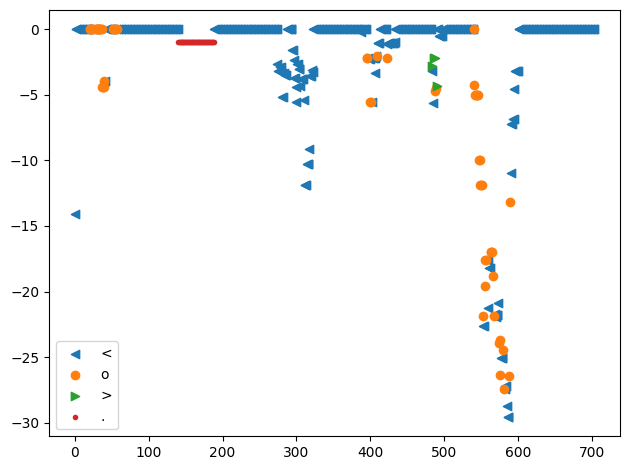

In [83]:
colors = []
for i in range(len(minimum_steps_8)):
    #simulation_values = gas_simulation_8[i]
    #g = [r[int(2*minimum_steps_8[i])][1] for r in simulation_values] # was halved before, two steps in log records
    g = [result_dict_help_8["mc_results"][i][4]]
    if(len(g)==0):
        colors.append("b")
        continue
    g = sum(g)/len(g)
    if g >= 0:
        colors.append("green")
    elif g >= -10:
        colors.append("orange")
    elif g >= -30 :
        colors.append("red")
    else:
        colors.append("black")

phase_markers = ["<" if c == "start" else "o" if c == "work" else ">" if c == "submit" else "." for c in phases_8]
x = np.array(range(len(minimum_steps_8)))
for m in ["<","o",">", "."]:
    x_index = [i for i in x if phase_markers[i] == m]
    plt.scatter(x_index, np.array([r[1] for r in result_dict_help_8["mc_results"]])[x_index], marker = m, label = m)
    #plt.scatter(x_index, np.array(minimum_steps_8)[x_index], marker = m, c = np.array(colors)[x_index], s = 2)

#plt.scatter(range(len(minimum_steps_8)), minimum_steps_8, c = colors)
#plt.plot(range(len(minimum_steps_8)), minimum_steps_8)
plt.legend()
print(np.argmax(minimum_steps_8), minimum_steps_8[np.argmax(minimum_steps_8)])
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/steps_8.png")
plt.show()

range(0, 704)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

ValueError: x and y must have same first dimension, but have shapes (2,) and (114,)

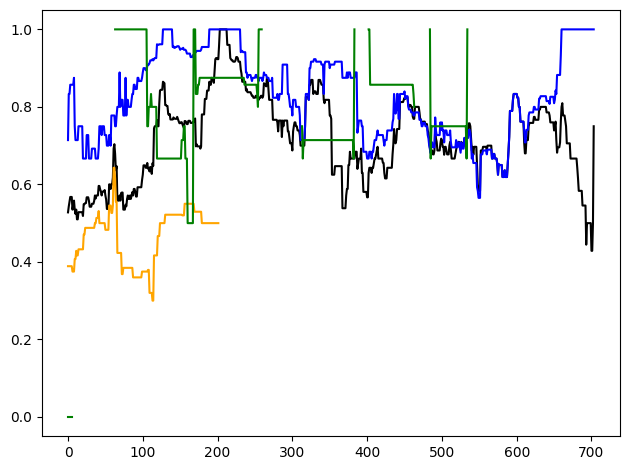

In [111]:
result_dicts = [result_dict_help_8,result_dict_help_6,result_dict_help_4]
sub_titles = [r'Comp. $c_1$', r'Comp. $c_2$', r'Comp. $c_3$']
colors = ["blue", "orange", "green"]

fractions = []
for l in sliced_logs:
    pos = [t for t in l if "finPos" in t]
    neg = [t for t in l if "finNeg" in t]
    fractions.append(len(pos)/len(l))
    assert(len(pos)+len(neg) == len(l))

plt.plot(range(len(fractions)), fractions, label = "all", c = "black") # global value
for dict, label, color in zip(result_dicts, sub_titles, colors):
    x = dict["fractions"]
    x_index = [i for i in range(len(x)) if x[i] != -1]
    ranges = list(detect_range(x_index))
    for r in ranges:
        print(range(r[0], r[1]))
        plt.plot(np.array(x_index)[r[0]:r[1]], np.array(x)[r[0]:r[1]], label = label, c = color)
    print(x_index, list(detect_range(x_index)))
    
#plt.title("Fractions")
plt.legend()
plt.xlabel("Windows", size = 20)
plt.ylabel("Ratio of Successful Users", size = 20)
plt.savefig("/home/paul/Documents/User-Journey-Games/windows/company_fractions.png")
plt.show()

lables = ["max_steps", "min_gas", "max_final_gas"]
n = len(result_dicts)

for j in range(3):
    fig, axs = plt.subplots(1,n+1, figsize=(20, 6))
    axs[n].scatter(range(len(result_dict_sequence["mc_results"])), [r[j] for r in result_dict_sequence["mc_results"]], s = 2, c = result_dict_sequence["colors"])
    for i in range(n):
        axs[i].scatter(range(len(result_dicts[i]["mc_results"])), [r[j] for r in result_dicts[i]["mc_results"]], s = 2, c = result_dicts[i]["colors"])
        axs[i].set_title(sub_titles[i])
    fig.suptitle(lables[j%3])
    plt.savefig("/home/paul/Documents/User-Journey-Games/windows/company"+lables[j%3]+".png")
    fig.show()

    fig, axs = plt.subplots(1,n, figsize=(20, 6))
    for i in range(n):
        axs[i].scatter(range(len(result_dicts[i]["mc_results"])), [r[j+3] for r in result_dicts[i]["mc_results"]], s = 2, c = result_dicts[i]["colors"])
        axs[i].set_title(sub_titles[i])
    fig.suptitle(lables[j%3])
    fig.show()


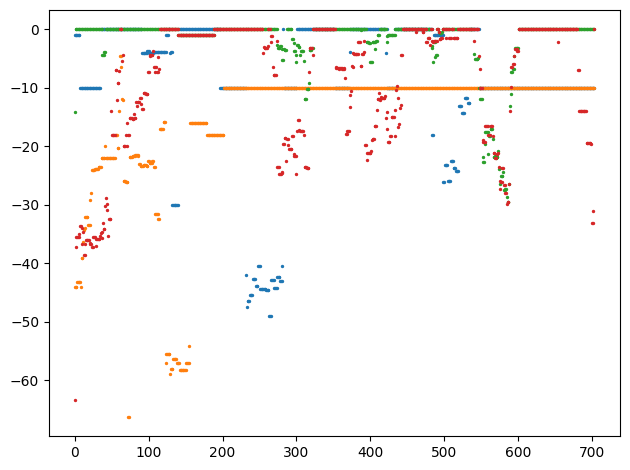

In [85]:
plt.scatter(range(len(result_dict_help_4["mc_results"])), [r[1] for r in result_dict_help_4["mc_results"]], s = 2)
plt.scatter(range(len(result_dict_help_6["mc_results"])), [r[1] for r in result_dict_help_6["mc_results"]], s = 2)
plt.scatter(range(len(result_dict_help_8["mc_results"])), [r[1] for r in result_dict_help_8["mc_results"]], s = 2)
plt.scatter(range(len(result_dict_sequence["mc_results"])), [r[1] for r in result_dict_sequence["mc_results"]], s = 2)
plt.show()

# Analysis big data set

In [86]:
# best reduction on big data set
def iterate_dfg(l, max_edge, min_edge = 0):
    s = ""
    for t in range(min_edge, max_edge+1):
        g =  build_dfg(l, t)
        extend_graph_with_actors(g,actors)
        edge_cost = compute_edge_cost(g, l)
        g = annotate_graph(g, edge_cost)

        s += "thresh. " + str(t) + " nodes " + str(len(g.nodes)) + " loops "+ str(len(list(nx.simple_cycles(g)))) + " neg edges " +  str(len([e for e in g.edges if edge_cost[e] < 0])) 
        s += " abort edges " + str(len([e for e in g.edges if "finNeg" in e[1]]))
        s += '\n'
    print(s)
iterate_dfg(log, 50, min_edge = 5)

Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost w

In [87]:
# best reduction on big data set
def iterate_transition(l, max_history, min_history = 1):
    string = ""
    for abstraction in [sequence, ms]:
        string += "Type " + str(abstraction) + '\n'
        for history in range(min_history, max_history+1):
            string += "  History " + str(history) + '\n'
            for thresh in range(0,11):
                g, edge_mapping =  transition_system(l, history, abstraction)
                extend_graph_with_actors(g,actors, transition_system=True)
                edge_cost = compute_edge_cost(g, l, edge_mapping)
                g = annotate_graph(g, edge_cost)

                edge_to_remove = []
                for e in g.edges:
                    if len(edge_mapping[e]) <= thresh:
                        edge_to_remove.append(e)
                g.remove_edges_from(edge_to_remove)
                g.remove_nodes_from(list(nx.isolates(g)))


                # compute traces represented - works only for sequence
                if abstraction == sequence:
                    contained = 0
                    for trace in l:
                        current_pos = 1
                        not_contained = False
                        s = trace[0]
                        while current_pos != len(trace):
                            actions = [t1 for t1 in g[s] if g[s][t1]['action'] == trace[current_pos]]
                            assert(len(actions) <= 1)
                            if len(actions) == 0:
                                not_contained = True
                                break
                            else:
                                s = actions[0]
                                current_pos +=1
                        if not not_contained:
                            contained += 1
                string += "   thresh " + str(thresh) + " nodes " + str(len(g.nodes)) + " loops "+ str(len(list(nx.simple_cycles(g)))) + " neg edges " +  str(len([e for e in g.edges if edge_cost[e] < 0])) 
                string += " abort edges " + str(len([e for e in g.edges if "finNeg" in e[1]]))
                if abstraction == sequence:
                    string += " coveres " + str(round(contained/len(l),2))
                string += '\n'
    print(string)

iterate_transition(log, 10)

Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost w

KeyboardInterrupt: 

In [ ]:
g, edge_mapping =  transition_system(log, 2, sequence)
extend_graph_with_actors(g,actors, transition_system=True)
edge_cost = compute_edge_cost(g, log, edge_mapping)
g = annotate_graph(g, edge_cost)
edge_to_remove = []
for e in g.edges:
    if len(edge_mapping[e]) <= 1:
        edge_to_remove.append(e)
g.remove_edges_from(edge_to_remove)
g.remove_nodes_from(list(nx.isolates(g)))

nodes_to_remove = []
for n in g.nodes:
    if "finPos" in n or "finNeg" in n:
        continue
    desc = nx.descendants(g,n)
    pos_desc = set(["finPos" in n for n in desc])
    neg_desc = set(["finNeg" in n for n in desc])
    if (True not in pos_desc and True not in neg_desc) or not desc:
        print("removed", n)
        nodes_to_remove.append(n)
g.remove_nodes_from(nodes_to_remove)

draw_dfg(g, "graph_all.png")

target = [s for s in g.nodes if "finPos" in s or "finNeg" in s]
g_unroll = unroll(g, "start", target, 1)
to_uppaal_transition(g_unroll, "unrolled_graph_transition.xml", layout = "dot")

out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
out.wait()
results, err = out.communicate()
results = results.decode("utf-8") 
err = err.decode("utf-8") 
if err != "":
    results = [-1,-1,-1,-1,-1,-1]
else:
    results = results.split("\n")
    results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
    results = [r.replace("≈", "") for r in results]
    results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
assert(len(results) == 6)

print(results)

Edge cost was computed
removed Task event: 3 - waitingForScores
removed Task event: 0 - waitingForManualScores
removed Task event: 1 - vpcAssignInstance
removed Task event: 3 - waitingForManualScores


/home/paul/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/paul/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


plotted graph_all.png
Graph was unrolled
[-1, -1, -1, -1, -1, -1]


In [ ]:
running_log = sliced_logs[0]
#g, edge_mapping = transition_system(running_log, 1, sequence)
g =  build_dfg(running_log, 10)

extend_graph_with_actors(g,actors)
edge_cost = compute_edge_cost(g, running_log)
g = annotate_graph(g, edge_cost)

"""
edge_to_remove = []
for e in g.edges:
    if len(edge_mapping[e]) < 10:
        edge_to_remove.append(e)
g.remove_edges_from(edge_to_remove)
node_to_remove = []
for n in g:
    if len(g[n])==0:
        node_to_remove.append(n)
g.remove_nodes_from(node_to_remove)
"""

draw_dfg(g, "graph.ps")

g_outgoing = color_graph(g)
g_outgoing = nx.relabel_nodes(g_outgoing, naming)
#draw_dfg_clustered(g_outgoing, 'outgoing_clustered.png')

"""
# mc part
target = [s for s in g.nodes if "finPos" in s or "finNeg" in s]
g_unroll = unroll(g, "start", target, 1)
#draw_dfg(help_g_unroll, "graph_loops_unrolled.ps")
to_uppaal(g_unroll, "unrolled_graph_transition.xml", layout = "dot")

out = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)
out.wait()
results, err = out.communicate()
results = results.decode("utf-8") 
err = err.decode("utf-8") 
#if "Formula is NOT satisfied" in results:
if err != "":
    results = [-1,-1,-1,-1,-1,-1]
    print(err)
    print("mc error")
else:
    results = results.split("\n")
    results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]
    results = [r.replace("≈", "") for r in results]
    results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].strip()) for r in results]
    print(results)
assert(len(results) == 6)
"""

Edge cost was computed
plotted graph.ps


'\n# mc part\ntarget = [s for s in g.nodes if "finPos" in s or "finNeg" in s]\ng_unroll = unroll(g, "start", target, 1)\n#draw_dfg(help_g_unroll, "graph_loops_unrolled.ps")\nto_uppaal(g_unroll, "unrolled_graph_transition.xml", layout = "dot")\n\nout = subprocess.Popen([VERIFYTA_PATH, "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.xml", "/home/paul/Documents/User-Journey-Games/unrolled_graph_transition.q"], stdout=subprocess.PIPE, stderr = subprocess.PIPE)\nout.wait()\nresults, err = out.communicate()\nresults = results.decode("utf-8") \nerr = err.decode("utf-8") \n#if "Formula is NOT satisfied" in results:\nif err != "":\n    results = [-1,-1,-1,-1,-1,-1]\n    print(err)\n    print("mc error")\nelse:\n    results = results.split("\n")\n    results = [results[i+1] for i in range(len(results)-1) if "Formula" in results[i] and "E" in results[i+1]]\n    results = [r.replace("≈", "") for r in results]\n    results = [float(r.split("±")[0].split("runs)")[1].split("=")[1].

In [ ]:
# both constructions are indeed equal...
def test_equality(sliced_logs):
    for running_log in sliced_logs:
        print("new")
        for n in range(100)[0::4]:
            g1 =  build_dfg(running_log, n)
            extend_graph_with_actors(g1,actors)
            edge_cost = compute_edge_cost(g1, running_log)
            g1 = annotate_graph(g1, edge_cost)
            draw_dfg(g1, "graph1.ps")


            g2, edge_mapping =  transition_system(running_log, 1, sequence)
            extend_graph_with_actors(g2, actors, transition_system=True)
            
            draw_dfg(g2, "graph2_before.ps")
            edge_cost2 = compute_edge_cost(g2, running_log, edge_mapping)
            g2 = annotate_graph(g2, edge_cost2)
            edge_to_remove = []
            for e in g2.edges: 
                if len(edge_mapping[e]) <= n:
                    edge_to_remove.append(e)
            g2.remove_edges_from(edge_to_remove)
            g2.remove_nodes_from(list(nx.isolates(g2)))
            draw_dfg(g2, "graph2_after.ps")

            if not nx.is_isomorphic(g1, g2):
                draw_dfg(build_dfg(running_log, 0), "graph1_before.ps")
                print(n)
            assert(nx.is_isomorphic(g1, g2))
            for e in edge_cost:
                if edge_cost[e] == edge_cost2[e]:
                    continue
                print(e, n)
                print(edge_cost[e], edge_cost2[e])
                print(distribution(e[0],e[1],running_log, edge_mapping))
                print(distribution(e[0],e[1],running_log))
                print(len(running_log))
                print(edge_mapping[e])
                print(running_log[49])
                assert(e in edge_cost2 and edge_cost2[e] == edge_cost[e])
#test_equality(sliced_logs)

In [ ]:
negative_edges_big = [e for e in g.edges if edge_cost[e] < 0 and "finNeg" not in e[1]]
print(negative_edges_big)

[('Give feedback 1', 'Task event: 2'), ('activated', 'vpcCreateUserOnInstance'), ('activated', 'vpcAssignInstance'), ('registered', 'activated'), ('vpcCreateUserOnInstance', 'vpcAssignInstance'), ('vpcCreateUserOnInstance', 'readyToStart'), ('vpcAssignInstance', 'readyToStart'), ('vpcAssignInstance', 'vpcCreateUserOnInstance'), ('Task event: 0', 'Give feedback 0'), ('Give feedback 0', 'Task event: 1'), ('readyToStart', 'started'), ('started', 'Task event: 0'), ('start', 'registered'), ('Task event: 1', 'Give feedback 1')]


Abort edges [] 0


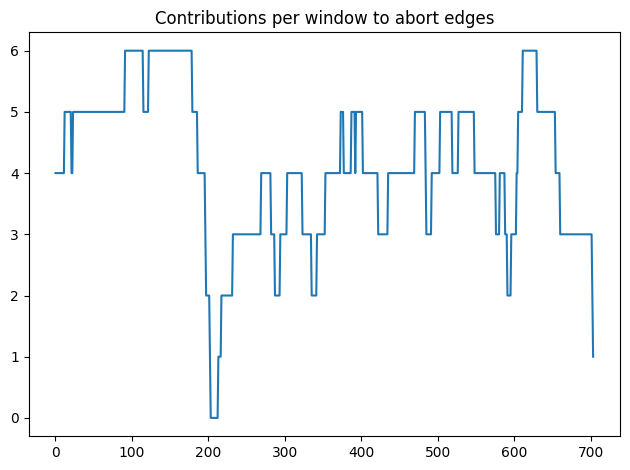

In [ ]:
# investiagte origin of abort edges
abort_edges_big = [e for e in g.edges if "finNeg" in e[1]]
print("Abort edges", abort_edges_big, len(abort_edges_big))

contributions = []
for l in sliced_logs:
    current_contributions = set()
    for t in l:
        pairs = [(t[i-1], t[i]) for i in range(1, len(t)) if "finNeg" in t[i]]
        current_contributions.update(pairs) # can also compare to certain window, number does not align with frequencies - but eitherways high fluctuation
        #for p in pairs:
        #    if p in abort_edges_big:
        #        current_contributions.add(p)
    contributions.append(len(current_contributions))
plt.plot(range(len(contributions)), contributions)
plt.title("Contributions per window to abort edges")
plt.show()

In [ ]:
print(len(list(nx.simple_cycles(g))))

1


In [ ]:
g_unroll = unroll(g, "start", ["finPos", "finNeg"], 1)
A = to_agraph(g_unroll)
A.layout('dot')
if SAVE_ELEMENTS:
    A.draw('unrolled.ps')

Graph was unrolled


Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed
Edge cost was computed


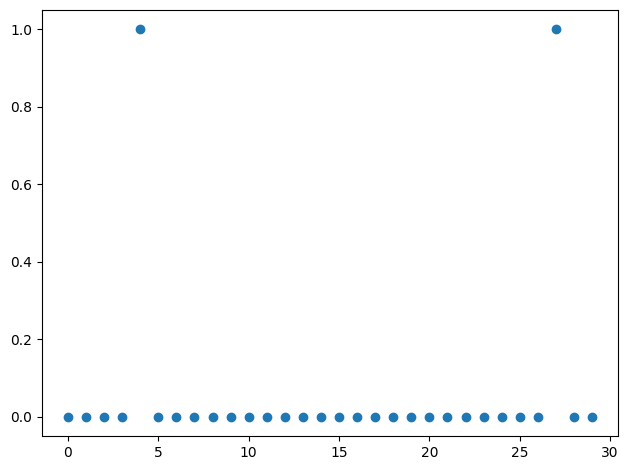

0.06666666666666667


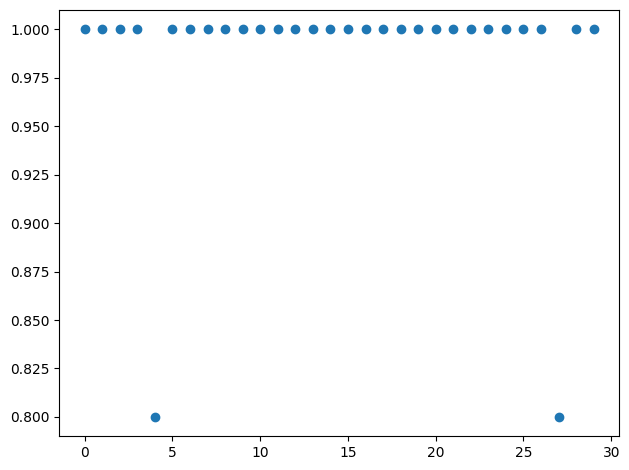

In [ ]:
def test_robustness(l, iterations, ratio = 0.8):
    g = build_dfg(l, 10)
    extend_graph_with_actors(g,actors)
    edge_cost = compute_edge_cost(g, l)
    g = annotate_graph(g, edge_cost)
    abort_edges = [e for e in g.edges if "finNeg" in e[1]]
    negative_edges = [e for e in g.edges if edge_cost[e] < 0]
    missing_edges = []
    missing_negative_edges = []
    for i in range(iterations):
        running_log = random.sample(l, int(ratio*len(l)))
        g_sample =  build_dfg(running_log, 10)
        extend_graph_with_actors(g_sample,actors)
        edge_cost_sample = compute_edge_cost(g_sample, running_log)
        g_sample = annotate_graph(g_sample, edge_cost_sample)
        abort_edges_sample = [e for e in g_sample.edges if "finNeg" in e[1]]
        negative_edges_sample = [e for e in g_sample.edges if edge_cost_sample[e] < 0]

        missing = [e for e in abort_edges if e not in abort_edges_sample]
        missing_edges.append(missing)
        missing_negative_edges.append(len(negative_edges_sample)/len(negative_edges))

    plt.scatter(range(iterations), [len(m) for m in missing_edges])
    plt.show()

    plt.scatter(range(iterations), missing_negative_edges)
    print(np.mean([len(m) for m in missing_edges]))

test_robustness(log, 30, ratio = 0.90)
# with full dataset and "aggressive" reduction, still good chances to find all abort edges, in many windows we cant even detect all abort edges...

In [ ]:
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

n_clusters = 6
r_state = 2359

X = [float(s.timestamp()) for s in start_times]
X = np.array(X).reshape(-1,1)
model = BayesianGaussianMixture(n_components=n_cluster, random_state=r_state, max_iter = 1000000).fit(X)

model = KMeans(n_clusters=n_clusters, random_state=r_state).fit(X)
print(model.score(X))

sorted_times = sorted(times.items(), key=lambda item: item[1])
count = 0
for t in sorted_times:
    cluster = model.predict([[t[1][0].timestamp()]])[0]
    plt.plot([t[1][0],t[1][1]], [count, count], c= sns.color_palette("husl", 10)[cluster])
    count += 1
plt.title("Duration of journeys")
plt.show()

NameError: name 'n_cluster' is not defined

In [ ]:
clustered_logs = []
predictions = model.predict(X)
for c in range(n_clusters):
    clustered_logs.append([log[i] for i in range(len(log)) if predictions[i] == c])
print(len(clustered_logs))

1


In [ ]:
for i in range(len(clustered_logs)):
    l = clustered_logs[i]
    print("log", i)
    print("has length", len(l))
    print("ratio", len([t for t in l if "finPos" in t])/len(l))
    print("total cancellations", len([t for t in l if "finNeg" in t]))

log 0
has length 526
ratio 0.7129277566539924
total cancellations 151


In [ ]:
#g, edge_mapping = transition_system(running_log, 3, sequence)
for i in range(len(clustered_logs)):
    l = clustered_logs[i]
    edge_threshold = 3

    g =  build_dfg(l, edge_threshold)
    #g, edge_mapping = transition_system(l, 3, ms)
    loop_number = len(list(nx.simple_cycles(g)))
    #while(loop_number>10):
    #    edge_threshold += 1
    #    g =  build_dfg(l, edge_threshold)
    #    loop_number = len(list(nx.simple_cycles(g)))
    print("edge_threshold", edge_threshold, "with", loop_number, "loops")
    extend_graph_with_actors(g,actors)
    edge_cost = compute_edge_cost(g, l)
    g = annotate_graph(g, edge_cost)

    draw_dfg(g, "./clusters/graph"+str(i)+".ps")
    
    g_outgoing = color_graph(g)
    g_outgoing = nx.relabel_nodes(g_outgoing, naming)
    draw_dfg_clustered(g_outgoing, 'outgoing_clustered.png')

edge_threshold 3 with 6418 loops
Edge cost was computed
plotted ./clusters/graph0.ps
